# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb
from sklearn.model_selection import train_test_split 

In [2]:
torch.__version__

'2.2.2'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module, ZINB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed, get_activation
from base.model.decoder import Decoder
from base.data.combined import GeneExpressionDatasetCombined, StratifiedBatchSampler
from base.engine.train import train_midgd

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 14

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cuda


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_transposed.tsv", sep='\t', index_col=[0])
# tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_transposed.tsv", sep='\t', index_col=[0])
tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

In [6]:
def data_filtering(df, filter_zero=True, filter_tumor=True):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal', 'Primary Blood Derived Cancer - Peripheral Blood'])]
    return df

# Filter data
tcga_mrna = data_filtering(tcga_mrna_raw)
tcga_mirna = data_filtering(tcga_mirna_raw)

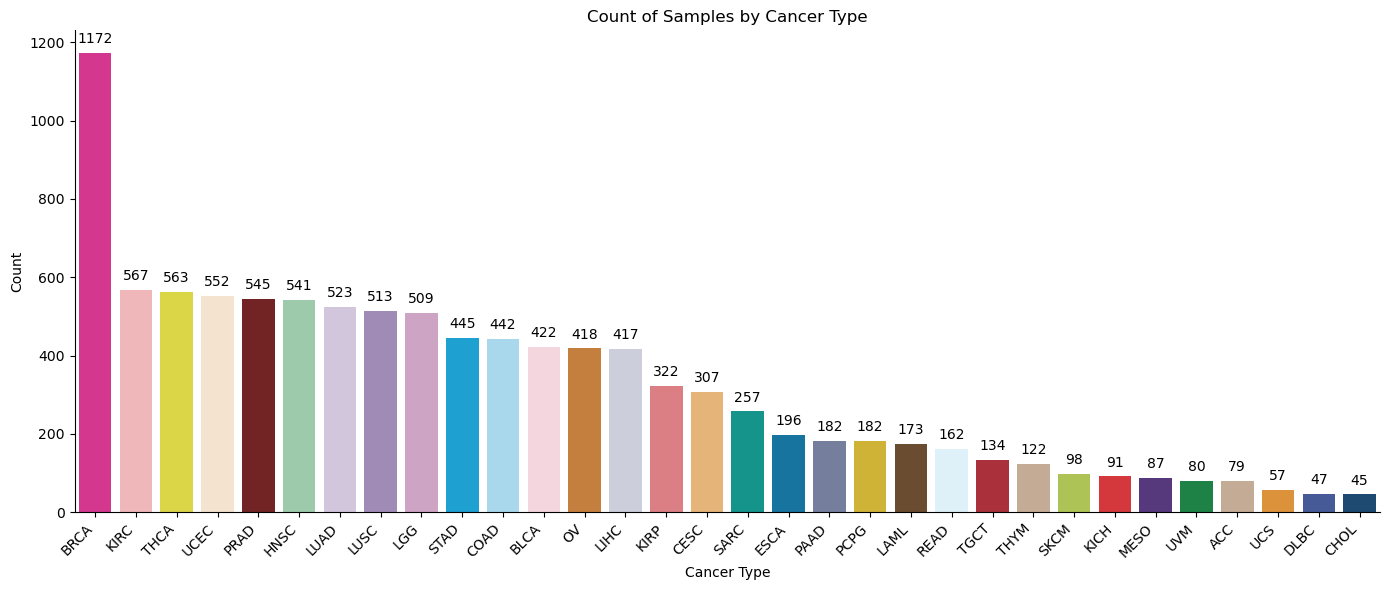

In [7]:
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

primary_site_counts = tcga_mrna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 6))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
sns.despine()
plt.show()

In [8]:
# shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

In [9]:
# make data split for train, validation, and test sets
train_ratio= 0.70
batch_size = 128
scaling_type = 'mean'

# Split data
train_mrna, val_mrna = train_test_split(tcga_mrna, train_size=train_ratio, stratify=tcga_mrna['cancer_type'], random_state=seed) 
val_mrna, test_mrna = train_test_split(val_mrna, test_size=0.50, stratify=val_mrna['cancer_type'], random_state=seed)

# Get the indices of the samples in each split
train_idx = train_mrna.index
val_idx = val_mrna.index
test_idx = test_mrna.index

# Use the same indices to split tcga_mirna
train_mirna = tcga_mirna.loc[train_idx]
val_mirna = tcga_mirna.loc[val_idx]
test_mirna = tcga_mirna.loc[test_idx]

# Default scaling_type = "mean"
train_dataset = GeneExpressionDatasetCombined(train_mrna, train_mirna, scaling_type=scaling_type)
validation_dataset = GeneExpressionDatasetCombined(val_mrna, val_mirna, scaling_type=scaling_type)
test_dataset = GeneExpressionDatasetCombined(test_mrna, test_mirna, scaling_type=scaling_type)

# Stratified Sampler
train_sampler = StratifiedBatchSampler(train_dataset.__getlabel__(), batch_size=batch_size)
validation_sampler = StratifiedBatchSampler(validation_dataset.__getlabel__(), batch_size=batch_size)
test_sampler = StratifiedBatchSampler(test_dataset.__getlabel__(), batch_size=batch_size)

# Data Loader
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           #batch_size=batch_size,
                                           batch_sampler=train_sampler,
                                           #shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                #batch_size=batch_size, 
                                                batch_sampler=validation_sampler,
                                                #shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          #batch_sampler=test_sampler,
                                          shuffle=False,
                                          num_workers=num_workers)

In [10]:
# make data split for train and validation sets
mrna_out_dim = tcga_mrna.shape[1]-4
mirna_out_dim = tcga_mirna.shape[1]-4

In [11]:
print(train_dataset.mrna_data.shape)
print(validation_dataset.mrna_data.shape)
# print(test_dataset.mrna_data.shape)

print(train_dataset.mirna_data.shape)
print(validation_dataset.mirna_data.shape)
# print(test_dataset.mirna_data.shape)

print(mrna_out_dim)
print(mirna_out_dim)

torch.Size([7174, 19741])
torch.Size([1538, 19741])
torch.Size([7174, 2024])
torch.Size([1538, 2024])
19741
2024


In [12]:
n_tissues = len(np.unique(train_dataset.label))
n_tissues = 32
n_tissues

32

# Model Setup

In [13]:
# hyperparameters
latent_dim = 22
hidden_dims = [100, 100, 100]
fc_mrna = 256
fc_mirna = 128
activation = "relu"
reduction_type = "sum" # output loss reduction
r_init_mrna = 2
r_init_mirna = 2
pi_init = 0.75

In [14]:
# Decoder setup
big_mirna = True

# set up an output module for the miRNA expression data

if big_mirna:
    mirna_out_fc = nn.Sequential(
        nn.Linear(hidden_dims[-1], 100),
        get_activation(activation),
        nn.Linear(100, fc_mirna),
        get_activation(activation),
        nn.Linear(fc_mirna, mirna_out_dim))
    output_mirna_layer = ZINB_Module(mirna_out_fc, mirna_out_dim, r_init=r_init_mirna, pi_init=pi_init, scaling_type=scaling_type)
    output_mirna_layer.n_features = mirna_out_dim
else:
    mirna_out_fc = nn.Sequential(
        nn.Linear(hidden_dims[-1], fc_mirna),
        get_activation(activation),
        nn.Linear(fc_mirna, mirna_out_dim))
    output_mirna_layer = ZINB_Module(mirna_out_fc, mirna_out_dim, r_init=r_init_mirna, pi_init=pi_init, scaling_type=scaling_type)
    output_mirna_layer.n_features = mirna_out_dim

# set up an output module for the mRNA expression data
mrna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], 128),
    get_activation(activation),
    nn.Linear(128, fc_mrna),
    get_activation(activation),
    nn.Linear(fc_mrna, mrna_out_dim))
output_mrna_layer = NB_Module(mrna_out_fc, mrna_out_dim, r_init=r_init_mrna, scaling_type=scaling_type)
output_mrna_layer.n_features = mrna_out_dim

# set up the decoder
decoder = Decoder(latent_dim, 
                  hidden_dims, 
                  output_module_mirna=output_mirna_layer, 
                  output_module_mrna=output_mrna_layer, 
                  activation=activation).to(device)

# setup gmm init
gmm_mean_scale = 3.0 # usually between 2 and 10
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

In [15]:
# init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

# Training

[1371, 1304, 34, 359]


  0%|                                                                                                                                                                                                                                | 0/1500 [00:00<?, ?it/s]

0 train_loss: 25.5380025066202 train_recon_mirna: 7.406487944774224 train_recon_mrna: 10.926653748422897 train_gmm: 7.204860813423077 train_mse: 830906176.0 train_mae: 6464.83935546875 train_r2: -0.01209712028503418 train_spearman: 0.08595430850982666 train_pearson: 0.03708379343152046 train_msle: 44.991363525390625
0 test_loss: 21.435189423582568 test_recon_mirna: 7.3071474153461455 test_recon_mrna: 10.856559480381474 test_gmm: 3.2714825278549475 test_mse: 721418944.0 test_mae: 6103.79296875 test_r2: -0.012013673782348633 test_spearman: 0.08104059100151062 test_pearson: 0.030800659209489822 test_msle: 44.92422103881836


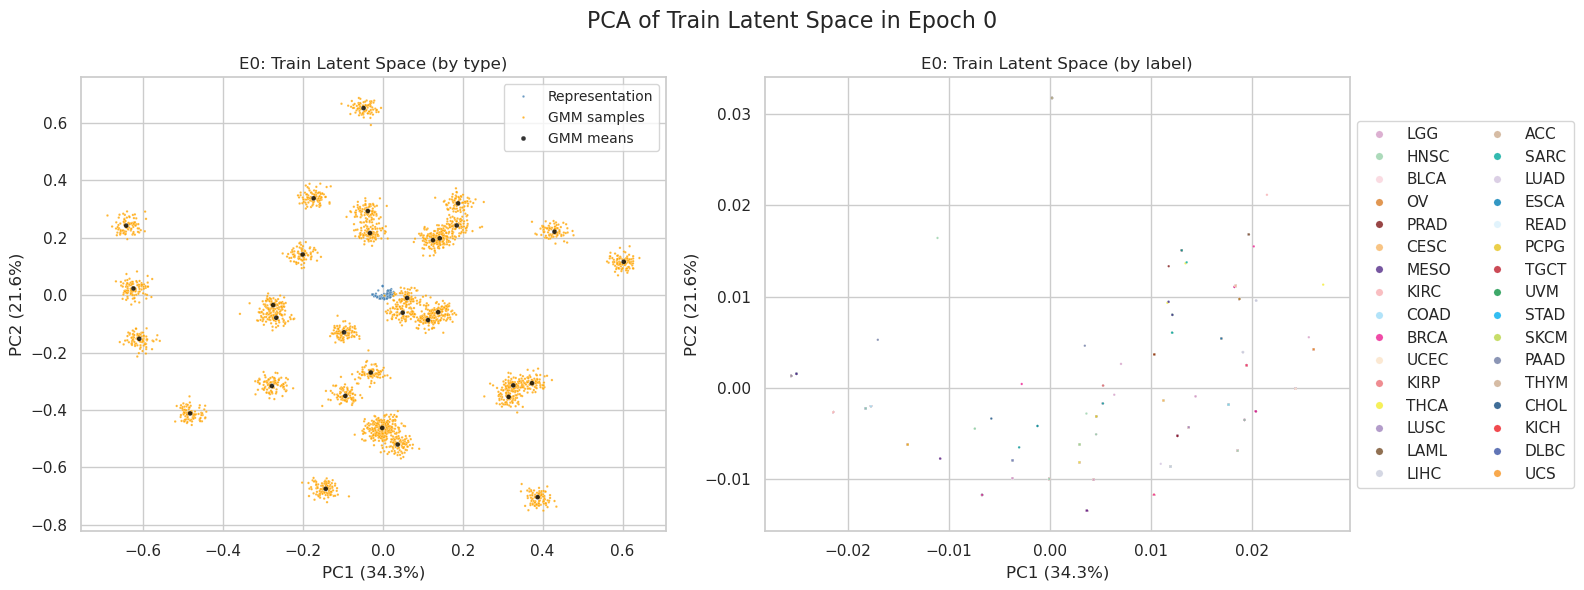

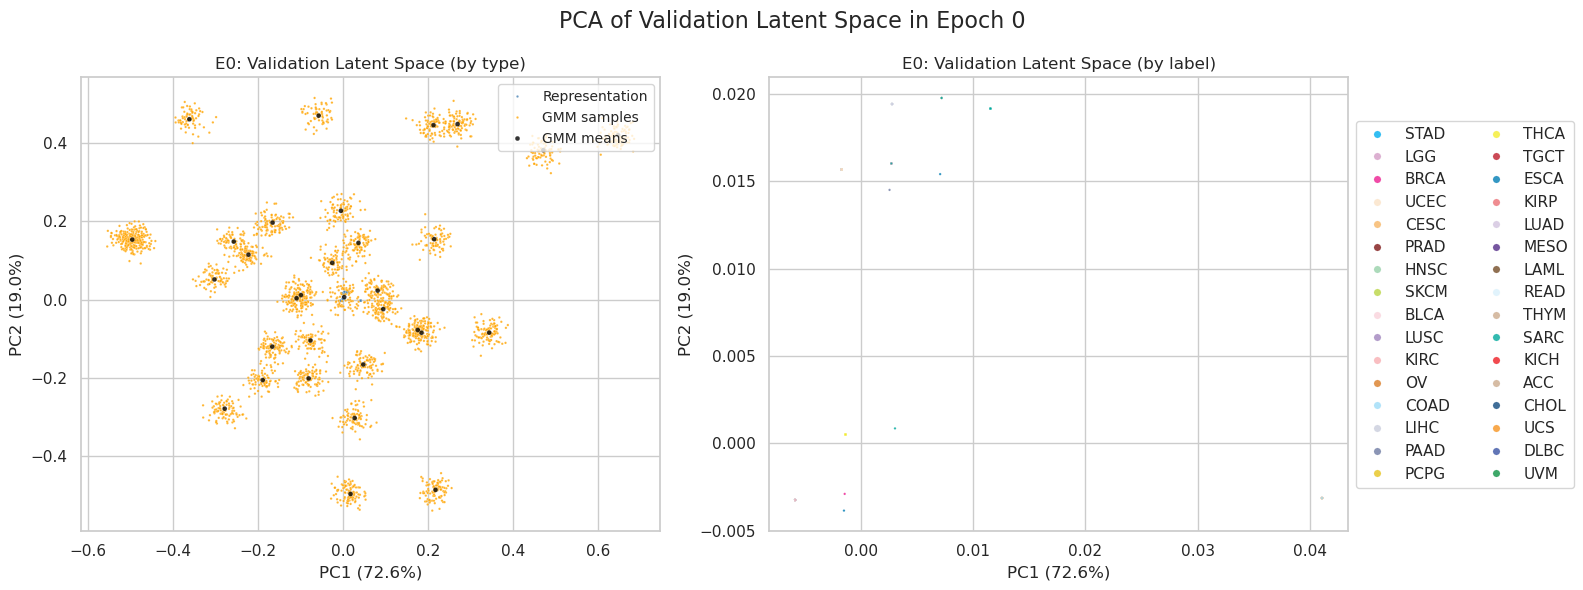

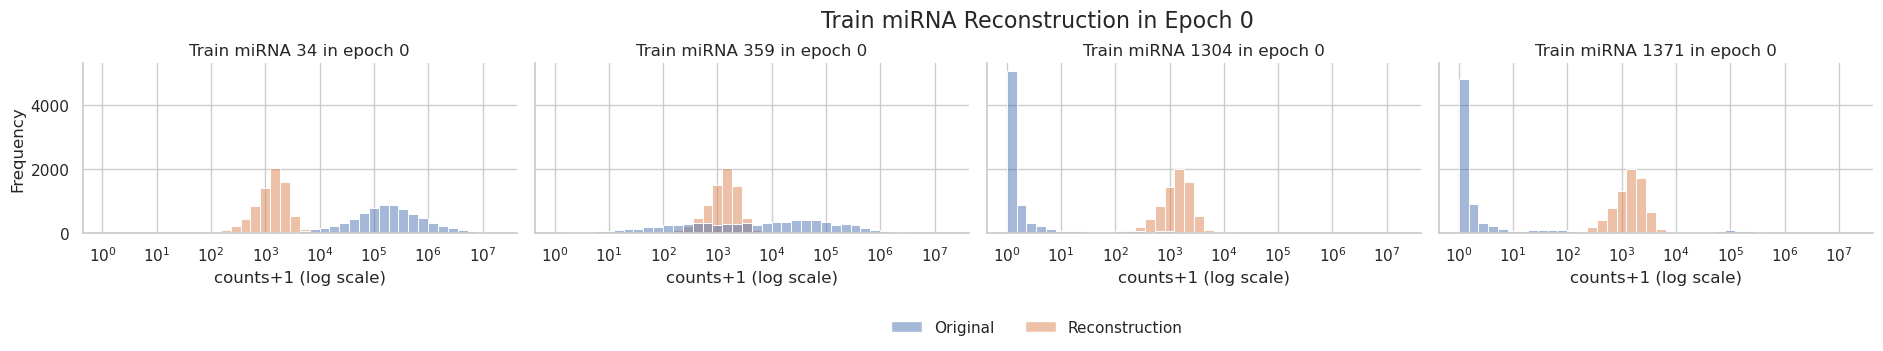

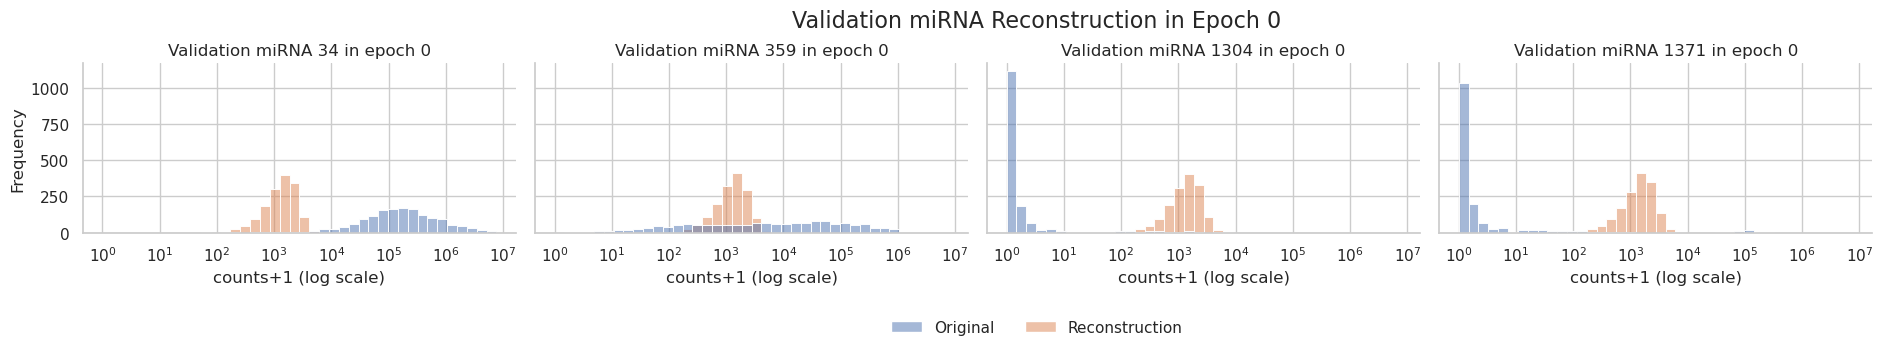

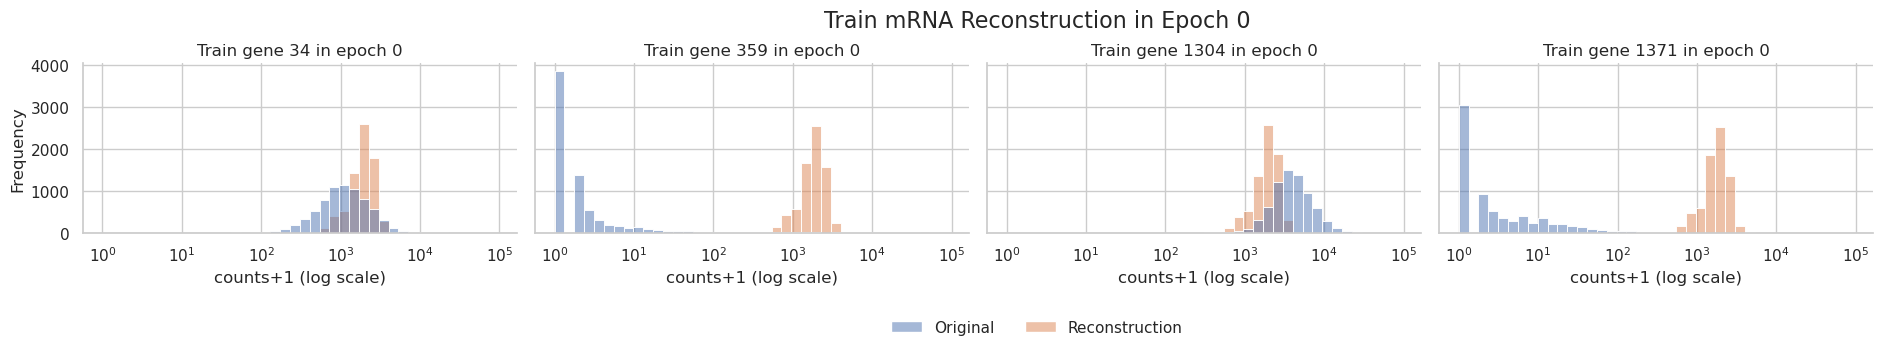

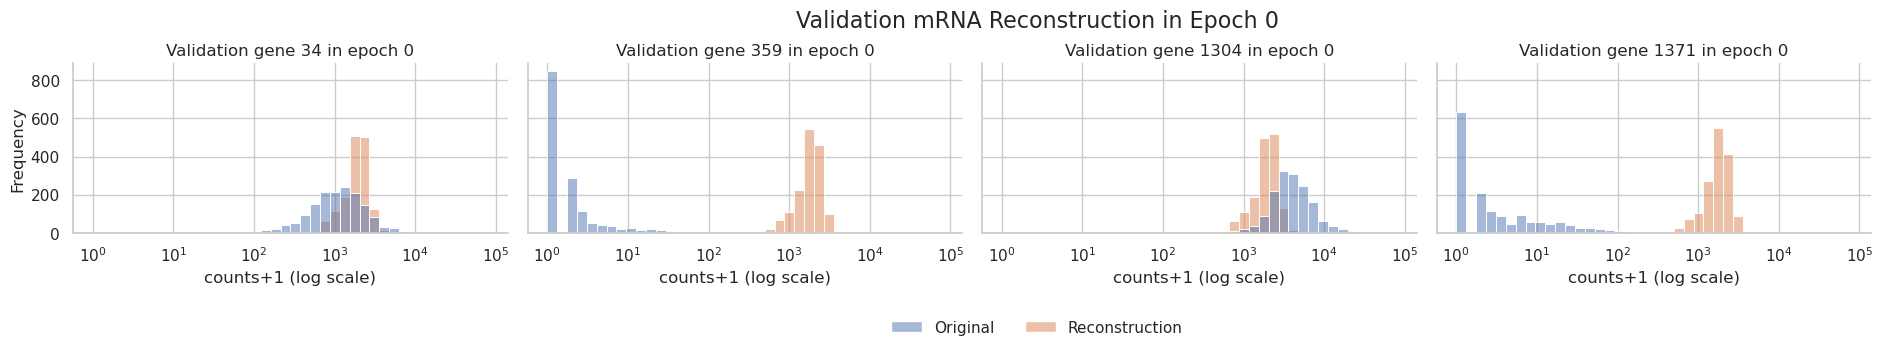

  0%|▊                                                                                                                                                                                                                     | 6/1500 [00:35<1:41:56,  4.09s/it]

5 train_loss: 14.069995578597789 train_recon_mirna: 4.522636011781125 train_recon_mrna: 7.957091928994558 train_gmm: 1.590267637822107 train_mse: 831966976.0 train_mae: 11167.125 train_r2: -0.013389229774475098 train_spearman: 0.08047507703304291 train_pearson: 0.039453890174627304 train_msle: 64.58958435058594
5 test_loss: 13.322628476086637 test_recon_mirna: 3.9065562044477966 test_recon_mrna: 7.824055326622808 test_gmm: 1.5920169450160333 test_mse: 725389888.0 test_mae: 10701.0146484375 test_r2: -0.01758408546447754 test_spearman: 0.07217127084732056 test_pearson: 0.032173797488212585 test_msle: 64.56897735595703


  1%|█▌                                                                                                                                                                                                                   | 11/1500 [00:50<1:22:26,  3.32s/it]

10 train_loss: 11.924914868928454 train_recon_mirna: 2.666432572855866 train_recon_mrna: 7.665272202821351 train_gmm: 1.5932100932512372 train_mse: 1032521024.0 train_mae: 20136.55078125 train_r2: -0.25767695903778076 train_spearman: 0.06181235611438751 train_pearson: 0.05012183263897896 train_msle: 78.90345001220703
10 test_loss: 11.913137562909117 test_recon_mirna: 2.6608961119042234 test_recon_mrna: 7.658695055454482 test_gmm: 1.5935463955504123 test_mse: 910301504.0 test_mae: 19385.2734375 test_r2: -0.27698004245758057 test_spearman: 0.05397818237543106 test_pearson: 0.05450696125626564 test_msle: 78.8348388671875


  1%|██▎                                                                                                                                                                                                                  | 16/1500 [01:06<1:18:34,  3.18s/it]

15 train_loss: 11.825807118554096 train_recon_mirna: 2.5947810308910855 train_recon_mrna: 7.637791770305863 train_gmm: 1.5932343173571466 train_mse: 994402240.0 train_mae: 19106.408203125 train_r2: -0.21124589443206787 train_spearman: 0.062376976013183594 train_pearson: 0.05135965719819069 train_msle: 77.74391174316406
15 test_loss: 11.810911542491105 test_recon_mirna: 2.589017373443258 test_recon_mrna: 7.6288434577584665 test_gmm: 1.593050711289381 test_mse: 880303040.0 test_mae: 18483.96875 test_r2: -0.23489797115325928 test_spearman: 0.05442029982805252 test_pearson: 0.05226821079850197 test_msle: 77.76616668701172


  1%|██▉                                                                                                                                                                                                                  | 21/1500 [01:23<1:20:51,  3.28s/it]

20 train_loss: 11.766665268224887 train_recon_mirna: 2.5620145590866117 train_recon_mrna: 7.612005764587285 train_gmm: 1.5926449445509907 train_mse: 994176064.0 train_mae: 19134.69140625 train_r2: -0.21097028255462646 train_spearman: 0.06490842252969742 train_pearson: 0.0529954694211483 train_msle: 77.79883575439453
20 test_loss: 11.771527130033117 test_recon_mirna: 2.5612590598449296 test_recon_mrna: 7.618012165211795 test_gmm: 1.5922559049763936 test_mse: 880308032.0 test_mae: 18530.455078125 test_r2: -0.23490488529205322 test_spearman: 0.05757688358426094 test_pearson: 0.05435498431324959 test_msle: 77.85159301757812


  2%|███▋                                                                                                                                                                                                                 | 26/1500 [01:39<1:18:30,  3.20s/it]

25 train_loss: 11.708391323936905 train_recon_mirna: 2.5412026427916574 train_recon_mrna: 7.574798095893819 train_gmm: 1.5923905852514288 train_mse: 972591360.0 train_mae: 18586.49609375 train_r2: -0.1846787929534912 train_spearman: 0.07321956753730774 train_pearson: 0.05865245312452316 train_msle: 77.18203735351562
25 test_loss: 11.670144474201713 test_recon_mirna: 2.5174764215949565 test_recon_mrna: 7.560876747903556 test_gmm: 1.5917913047032006 test_mse: 858706112.0 test_mae: 17933.24609375 test_r2: -0.20460152626037598 test_spearman: 0.0674644410610199 test_pearson: 0.059264518320560455 test_msle: 77.14193725585938


  2%|████▍                                                                                                                                                                                                                | 31/1500 [01:54<1:17:27,  3.16s/it]

30 train_loss: 11.5865494196297 train_recon_mirna: 2.509777158520668 train_recon_mrna: 7.481790101807253 train_gmm: 1.5949821593017794 train_mse: 974917632.0 train_mae: 18569.48046875 train_r2: -0.18751239776611328 train_spearman: 0.07644420862197876 train_pearson: 0.05585859343409538 train_msle: 77.09197998046875
30 test_loss: 11.544140420044029 test_recon_mirna: 2.4851114888567363 test_recon_mrna: 7.464082890334908 test_gmm: 1.5949460408523835 test_mse: 862626560.0 test_mae: 17972.1015625 test_r2: -0.21010112762451172 test_spearman: 0.06893938034772873 test_pearson: 0.05404305458068848 test_msle: 77.12825012207031


  2%|█████                                                                                                                                                                                                                | 36/1500 [02:11<1:19:39,  3.26s/it]

35 train_loss: 11.486940194307124 train_recon_mirna: 2.4823412006163013 train_recon_mrna: 7.406836330875131 train_gmm: 1.5977626628156918 train_mse: 928373760.0 train_mae: 17348.923828125 train_r2: -0.13081884384155273 train_spearman: 0.0703573077917099 train_pearson: 0.08216709643602371 train_msle: 75.54084777832031
35 test_loss: 11.44774124573062 test_recon_mirna: 2.4738767711711733 test_recon_mrna: 7.3761504724149125 test_gmm: 1.5977140021445355 test_mse: 817422272.0 test_mae: 16714.587890625 test_r2: -0.14668810367584229 test_spearman: 0.0619519017636776 test_pearson: 0.08218929171562195 test_msle: 75.47431945800781


  3%|█████▊                                                                                                                                                                                                               | 41/1500 [02:27<1:17:21,  3.18s/it]

40 train_loss: 11.38377551141304 train_recon_mirna: 2.459809207891144 train_recon_mrna: 7.325508603773198 train_gmm: 1.598457699748698 train_mse: 820191296.0 train_mae: 13390.7109375 train_r2: 0.0009542703628540039 train_spearman: 0.0724439024925232 train_pearson: 0.17047807574272156 train_msle: 69.18460083007812
40 test_loss: 11.35798775487729 test_recon_mirna: 2.4504115037623935 test_recon_mrna: 7.309785058510309 test_gmm: 1.5977911926045854 test_mse: 718367168.0 test_mae: 12893.0048828125 test_r2: -0.0077326297760009766 test_spearman: 0.0658276304602623 test_pearson: 0.16536188125610352 test_msle: 69.15161895751953


  3%|██████▌                                                                                                                                                                                                              | 46/1500 [02:43<1:19:07,  3.26s/it]

45 train_loss: 11.32564589063335 train_recon_mirna: 2.4413635206625597 train_recon_mrna: 7.285844705382996 train_gmm: 1.598437664587795 train_mse: 759272896.0 train_mae: 8246.65234375 train_r2: 0.0751568078994751 train_spearman: 0.1058211550116539 train_pearson: 0.3650403320789337 train_msle: 52.82243347167969
45 test_loss: 11.287377531496945 test_recon_mirna: 2.4181532235732974 test_recon_mrna: 7.271209365443745 test_gmm: 1.598014942479903 test_mse: 656220224.0 test_mae: 7851.27490234375 test_r2: 0.0794476866722107 test_spearman: 0.10259155184030533 test_pearson: 0.361642450094223 test_msle: 52.73271942138672


  3%|███████▏                                                                                                                                                                                                             | 51/1500 [02:59<1:18:48,  3.26s/it]

50 train_loss: 11.262759650984393 train_recon_mirna: 2.415061889573515 train_recon_mrna: 7.249012345785364 train_gmm: 1.5986854156255148 train_mse: 739008000.0 train_mae: 7226.64453125 train_r2: 0.09984076023101807 train_spearman: 0.1360127329826355 train_pearson: 0.478366881608963 train_msle: 45.36334228515625
50 test_loss: 11.241669808020534 test_recon_mirna: 2.4030661844922054 test_recon_mrna: 7.240482123868203 test_gmm: 1.5981214996601254 test_mse: 636352832.0 test_mae: 6855.0703125 test_r2: 0.10731786489486694 test_spearman: 0.13259971141815186 test_pearson: 0.4744260311126709 test_msle: 45.26268005371094


  4%|███████▉                                                                                                                                                                                                             | 56/1500 [03:15<1:16:21,  3.17s/it]

55 train_loss: 11.214131269413057 train_recon_mirna: 2.4022455073891664 train_recon_mrna: 7.2128974739181295 train_gmm: 1.5989882881057622 train_mse: 729957376.0 train_mae: 6645.3564453125 train_r2: 0.11086499691009521 train_spearman: 0.13913917541503906 train_pearson: 0.5453083515167236 train_msle: 40.07245635986328
55 test_loss: 11.206764330997318 test_recon_mirna: 2.3968380330057517 test_recon_mrna: 7.211029055132628 test_gmm: 1.5988972428589372 test_mse: 629084864.0 test_mae: 6232.36669921875 test_r2: 0.11751353740692139 test_spearman: 0.1366543471813202 test_pearson: 0.5400898456573486 test_msle: 39.544307708740234


  4%|████████▋                                                                                                                                                                                                            | 61/1500 [03:31<1:18:08,  3.26s/it]

60 train_loss: 11.173047173816002 train_recon_mirna: 2.3932127398111427 train_recon_mrna: 7.180221278435584 train_gmm: 1.5996131555692747 train_mse: 725967296.0 train_mae: 6499.376953125 train_r2: 0.11572515964508057 train_spearman: 0.1342693716287613 train_pearson: 0.5483551621437073 train_msle: 37.37779998779297
60 test_loss: 11.139231787272813 test_recon_mirna: 2.380645136290393 test_recon_mrna: 7.158384631036948 test_gmm: 1.6002020199454723 test_mse: 626266048.0 test_mae: 6127.2783203125 test_r2: 0.12146776914596558 test_spearman: 0.1308465301990509 test_pearson: 0.532951295375824 test_msle: 37.05424499511719


  4%|█████████▎                                                                                                                                                                                                           | 66/1500 [03:47<1:15:21,  3.15s/it]

65 train_loss: 11.10637034409781 train_recon_mirna: 2.3745717639717316 train_recon_mrna: 7.130132525940509 train_gmm: 1.6016660541855692 train_mse: 719923072.0 train_mae: 6493.916015625 train_r2: 0.12308740615844727 train_spearman: 0.1335783153772354 train_pearson: 0.5355018377304077 train_msle: 35.1882209777832
65 test_loss: 11.095200216642331 test_recon_mirna: 2.3620581789655475 test_recon_mrna: 7.130713876034043 test_gmm: 1.60242816164274 test_mse: 619660480.0 test_mae: 6119.19287109375 test_r2: 0.13073408603668213 test_spearman: 0.1340108960866928 test_pearson: 0.5276691317558289 test_msle: 34.847084045410156


  5%|██████████                                                                                                                                                                                                           | 71/1500 [04:03<1:14:13,  3.12s/it]

70 train_loss: 11.05733944568373 train_recon_mirna: 2.3534526845611237 train_recon_mrna: 7.098363873494342 train_gmm: 1.6055228876282646 train_mse: 710542656.0 train_mae: 6214.27294921875 train_r2: 0.13451343774795532 train_spearman: 0.1534949690103531 train_pearson: 0.575119137763977 train_msle: 30.652944564819336
70 test_loss: 11.021560368290295 test_recon_mirna: 2.3274565744229196 test_recon_mrna: 7.088029382321611 test_gmm: 1.6060744115457648 test_mse: 611223296.0 test_mae: 5887.15087890625 test_r2: 0.142569899559021 test_spearman: 0.15019387006759644 test_pearson: 0.5595816373825073 test_msle: 30.47890853881836


  5%|██████████▋                                                                                                                                                                                                          | 75/1500 [04:15<1:14:05,  3.12s/it]

75 train_loss: 10.988337548444106 train_recon_mirna: 2.3252574039047462 train_recon_mrna: 7.052647395706374 train_gmm: 1.610432748832986 train_mse: 702637696.0 train_mae: 5797.43115234375 train_r2: 0.14414215087890625 train_spearman: 0.17963746190071106 train_pearson: 0.6461528539657593 train_msle: 25.82086753845215
75 test_loss: 10.975546064573999 test_recon_mirna: 2.3141674700409136 test_recon_mrna: 7.048891862229659 test_gmm: 1.6124867323034269 test_mse: 603388160.0 test_mae: 5441.28173828125 test_r2: 0.1535610556602478 test_spearman: 0.18061690032482147 test_pearson: 0.6387844681739807 test_msle: 25.534786224365234


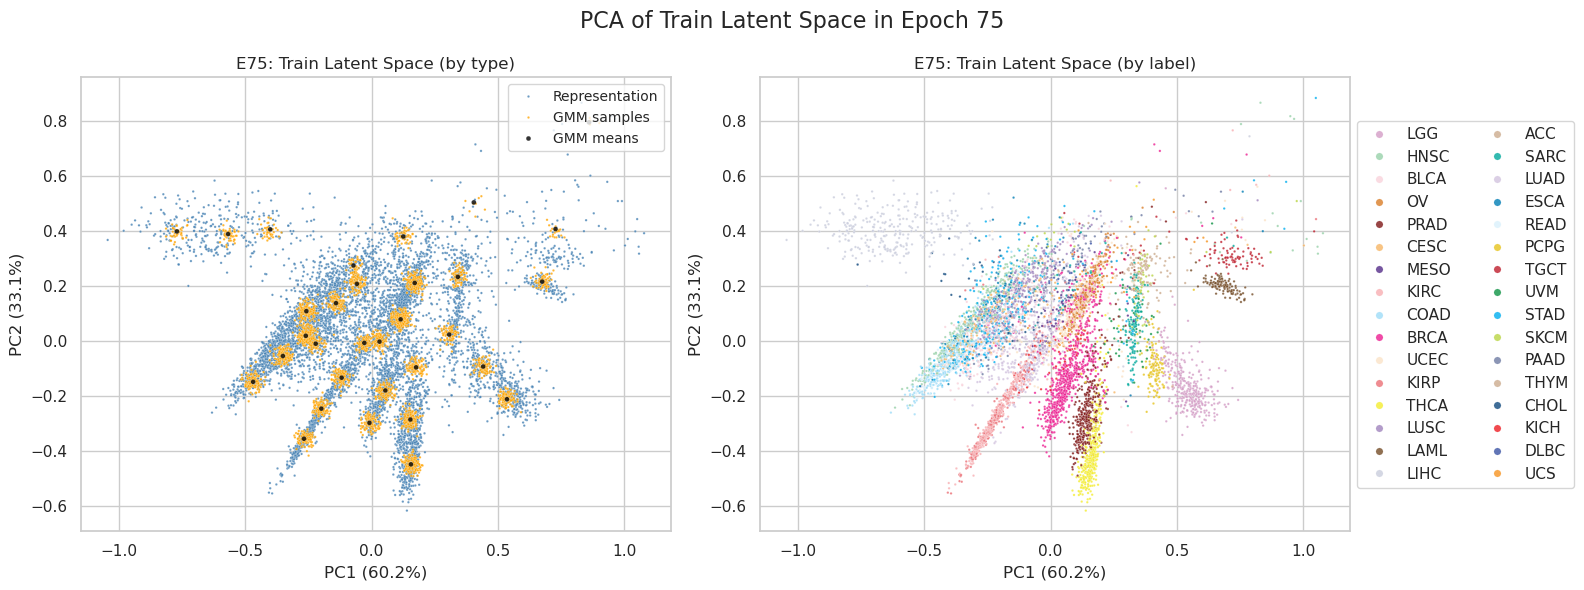

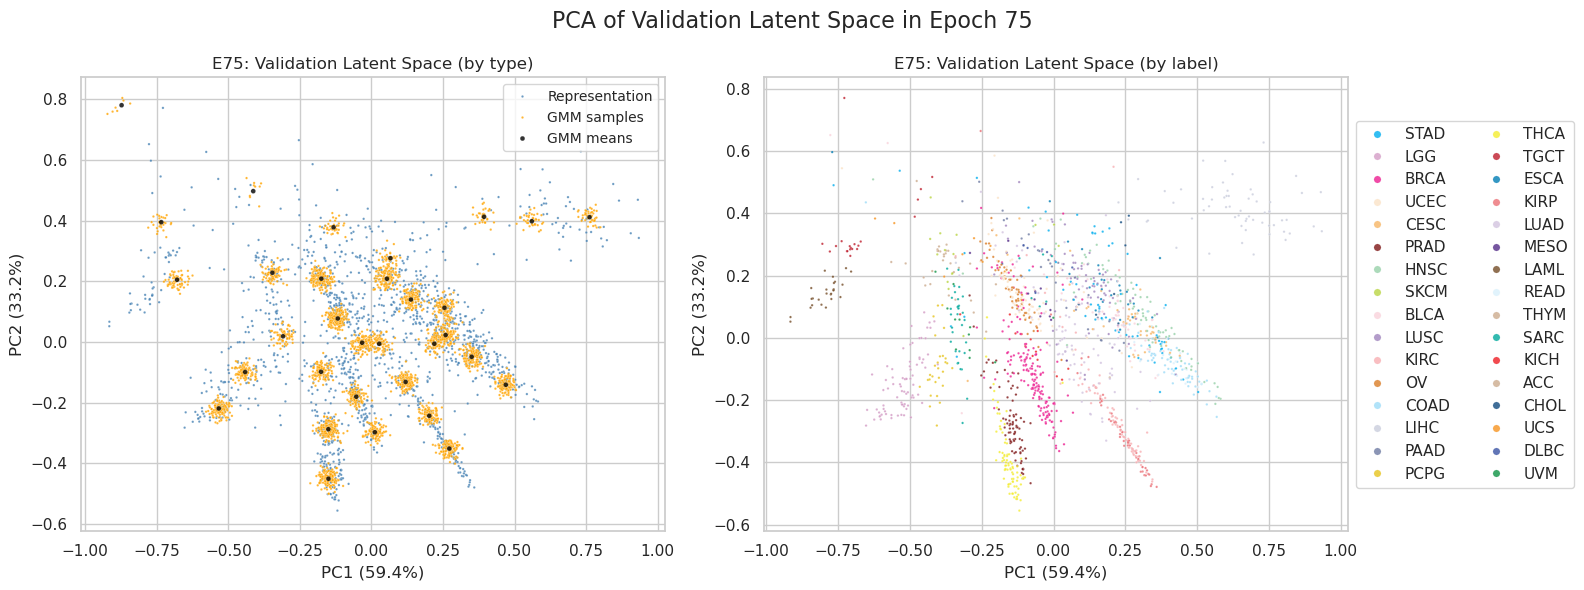

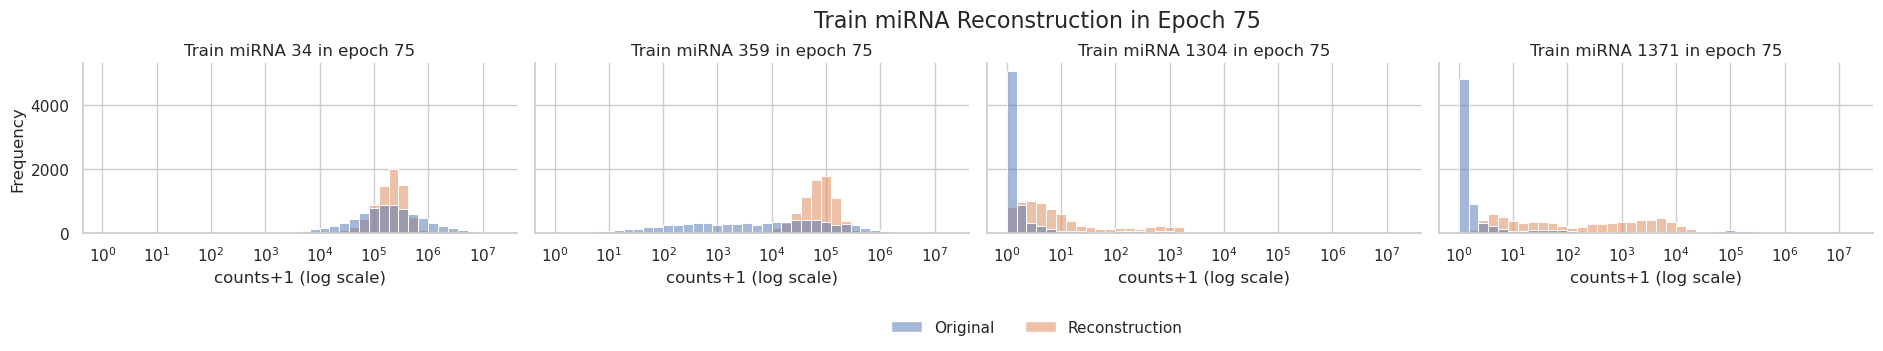

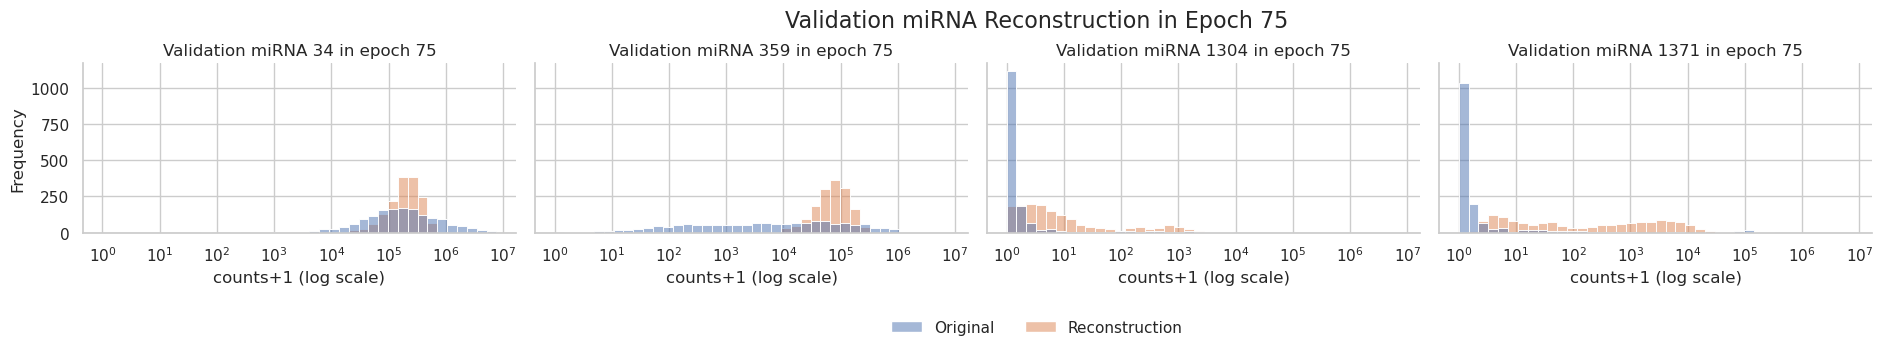

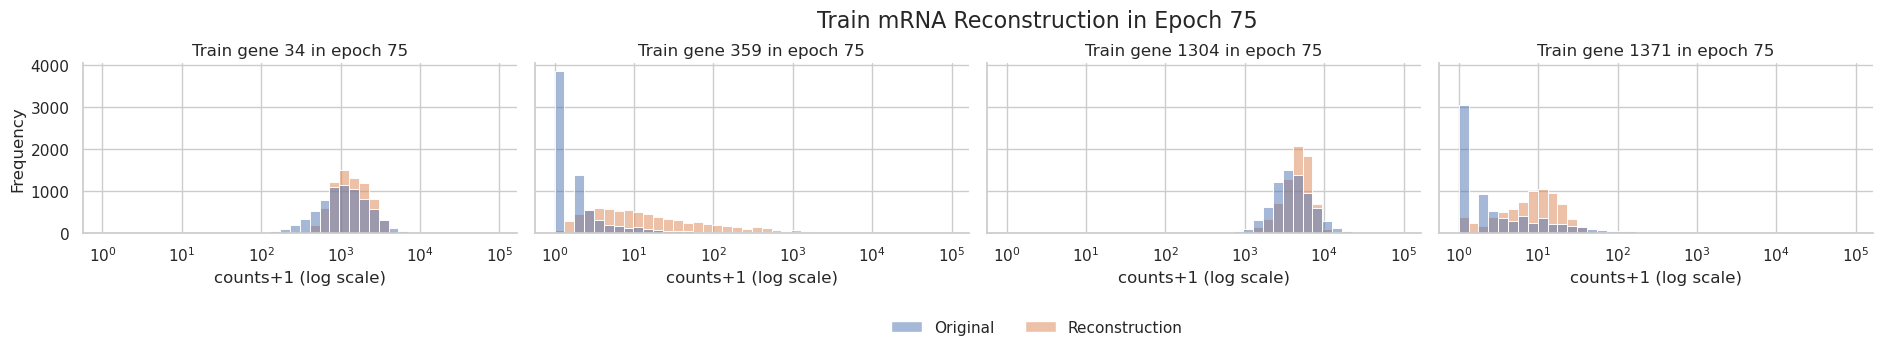

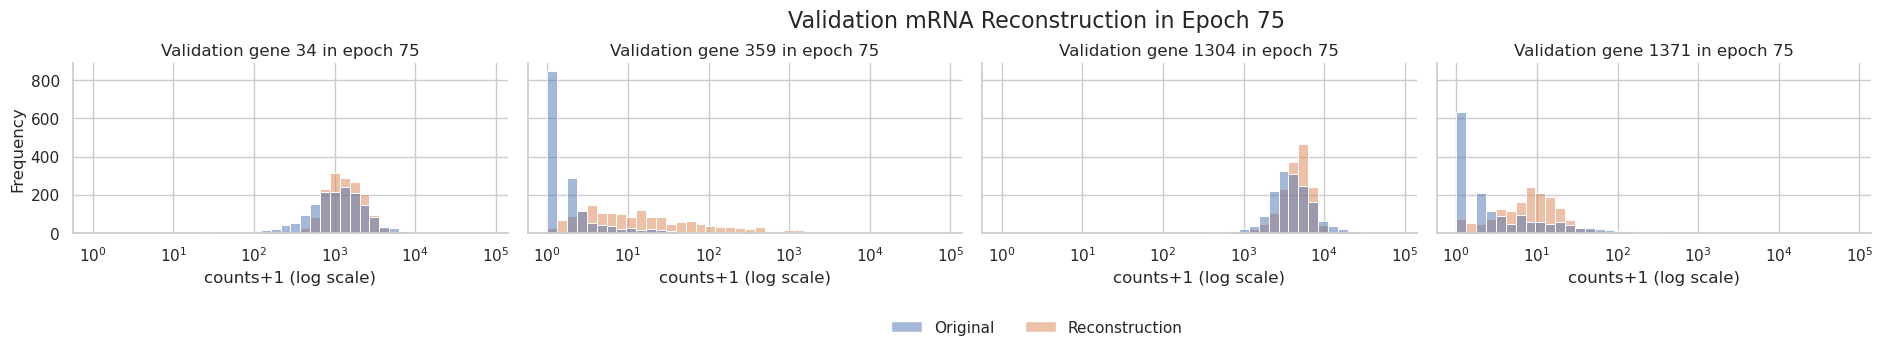

  5%|███████████▌                                                                                                                                                                                                         | 81/1500 [04:50<1:33:28,  3.95s/it]

80 train_loss: 10.940837987043828 train_recon_mirna: 2.311916992259598 train_recon_mrna: 7.013648761497636 train_gmm: 1.615272233286592 train_mse: 689895360.0 train_mae: 5538.8583984375 train_r2: 0.15966308116912842 train_spearman: 0.190958634018898 train_pearson: 0.7072389721870422 train_msle: 23.91132354736328
80 test_loss: 10.934932960149323 test_recon_mirna: 2.308105461220876 test_recon_mrna: 7.00877455374802 test_gmm: 1.618052945180429 test_mse: 592746048.0 test_mae: 5178.2041015625 test_r2: 0.1684899926185608 test_spearman: 0.189254492521286 test_pearson: 0.6990604400634766 test_msle: 23.516603469848633


  6%|████████████▏                                                                                                                                                                                                        | 86/1500 [05:06<1:18:45,  3.34s/it]

85 train_loss: 10.903768208866012 train_recon_mirna: 2.3011210917829095 train_recon_mrna: 6.983367350427512 train_gmm: 1.6192797666555918 train_mse: 671633792.0 train_mae: 5517.64013671875 train_r2: 0.18190687894821167 train_spearman: 0.18849201500415802 train_pearson: 0.72731614112854 train_msle: 24.526126861572266
85 test_loss: 10.879426424938865 test_recon_mirna: 2.2878869728729883 test_recon_mrna: 6.9711670555013825 test_gmm: 1.620372396564495 test_mse: 576963968.0 test_mae: 5165.05419921875 test_r2: 0.190629243850708 test_spearman: 0.18664701282978058 test_pearson: 0.7213665843009949 test_msle: 24.239723205566406


  6%|████████████▉                                                                                                                                                                                                        | 91/1500 [05:22<1:15:46,  3.23s/it]

90 train_loss: 10.871876756949156 train_recon_mirna: 2.2900276355121316 train_recon_mrna: 6.960614518934617 train_gmm: 1.6212346025024076 train_mse: 660505664.0 train_mae: 5465.89599609375 train_r2: 0.1954616904258728 train_spearman: 0.17743176221847534 train_pearson: 0.7431369423866272 train_msle: 24.447721481323242
90 test_loss: 10.836624170921842 test_recon_mirna: 2.2732539299215655 test_recon_mrna: 6.940962117417961 test_gmm: 1.6224081235823162 test_mse: 565796160.0 test_mae: 5126.13134765625 test_r2: 0.20629554986953735 test_spearman: 0.16937144100666046 test_pearson: 0.7349648475646973 test_msle: 24.295717239379883


  6%|█████████████▋                                                                                                                                                                                                       | 96/1500 [05:37<1:14:20,  3.18s/it]

95 train_loss: 10.816611817210452 train_recon_mirna: 2.2668467568850406 train_recon_mrna: 6.92838342399702 train_gmm: 1.6213816363283924 train_mse: 649458496.0 train_mae: 5552.46923828125 train_r2: 0.20891785621643066 train_spearman: 0.1673111766576767 train_pearson: 0.7350073456764221 train_msle: 25.411619186401367
95 test_loss: 10.815979107125521 test_recon_mirna: 2.2635430466714124 test_recon_mrna: 6.928949795824721 test_gmm: 1.6234862646293888 test_mse: 556655808.0 test_mae: 5210.13330078125 test_r2: 0.21911770105361938 test_spearman: 0.16117897629737854 test_pearson: 0.7292249798774719 test_msle: 25.262815475463867


  7%|██████████████▎                                                                                                                                                                                                     | 101/1500 [05:54<1:16:16,  3.27s/it]

100 train_loss: 10.777609222271007 train_recon_mirna: 2.260384244825958 train_recon_mrna: 6.895490510671885 train_gmm: 1.6217344667731644 train_mse: 641289536.0 train_mae: 5663.67138671875 train_r2: 0.21886813640594482 train_spearman: 0.16054223477840424 train_pearson: 0.7233957648277283 train_msle: 26.252620697021484
100 test_loss: 10.770298420718923 test_recon_mirna: 2.2556134738148717 test_recon_mrna: 6.890726982037674 test_gmm: 1.6239579648663776 test_mse: 550610304.0 test_mae: 5331.17138671875 test_r2: 0.2275983691215515 test_spearman: 0.15394707024097443 test_pearson: 0.7088157534599304 test_msle: 25.97340202331543


  7%|██████████████▉                                                                                                                                                                                                     | 106/1500 [06:10<1:16:24,  3.29s/it]

105 train_loss: 10.735324316597113 train_recon_mirna: 2.246735589671916 train_recon_mrna: 6.865921743449712 train_gmm: 1.6226669834754843 train_mse: 634099200.0 train_mae: 5627.1376953125 train_r2: 0.22762644290924072 train_spearman: 0.15666113793849945 train_pearson: 0.7325937151908875 train_msle: 26.13393211364746
105 test_loss: 10.733149629364876 test_recon_mirna: 2.2390838746806847 test_recon_mrna: 6.868990685554787 test_gmm: 1.6250750691294036 test_mse: 546538560.0 test_mae: 5327.3720703125 test_r2: 0.23331022262573242 test_spearman: 0.1494147628545761 test_pearson: 0.7143283486366272 test_msle: 26.224143981933594


  7%|███████████████▋                                                                                                                                                                                                    | 111/1500 [06:26<1:13:39,  3.18s/it]

110 train_loss: 10.694191871045698 train_recon_mirna: 2.2336561769292604 train_recon_mrna: 6.837528994625932 train_gmm: 1.6230066994905055 train_mse: 631005056.0 train_mae: 5518.85546875 train_r2: 0.23139530420303345 train_spearman: 0.15555384755134583 train_pearson: 0.7428877353668213 train_msle: 24.909406661987305
110 test_loss: 10.701231033147362 test_recon_mirna: 2.2296365709984736 test_recon_mrna: 6.8463500906307555 test_gmm: 1.6252443715181315 test_mse: 543313472.0 test_mae: 5187.44482421875 test_r2: 0.23783445358276367 test_spearman: 0.1480298638343811 test_pearson: 0.7309086918830872 test_msle: 24.79161834716797


  8%|████████████████▍                                                                                                                                                                                                   | 116/1500 [06:42<1:14:01,  3.21s/it]

115 train_loss: 10.671712301834196 train_recon_mirna: 2.225505948584921 train_recon_mrna: 6.821933246583118 train_gmm: 1.624273106666157 train_mse: 624308736.0 train_mae: 5550.556640625 train_r2: 0.239551842212677 train_spearman: 0.16064979135990143 train_pearson: 0.740547239780426 train_msle: 25.370817184448242
115 test_loss: 10.65743554559336 test_recon_mirna: 2.2093309857458228 test_recon_mrna: 6.821695837559332 test_gmm: 1.6264087222882064 test_mse: 533860416.0 test_mae: 5215.0517578125 test_r2: 0.2510952353477478 test_spearman: 0.15666043758392334 test_pearson: 0.7298685908317566 test_msle: 25.364959716796875


  8%|█████████████████                                                                                                                                                                                                   | 121/1500 [06:58<1:14:37,  3.25s/it]

120 train_loss: 10.639134188945114 train_recon_mirna: 2.210452093521456 train_recon_mrna: 6.804587303545791 train_gmm: 1.624094791877867 train_mse: 623517056.0 train_mae: 5425.4072265625 train_r2: 0.24051618576049805 train_spearman: 0.16431209444999695 train_pearson: 0.7556674480438232 train_msle: 24.443510055541992
120 test_loss: 10.628261117996091 test_recon_mirna: 2.195188861747457 test_recon_mrna: 6.80794230670802 test_gmm: 1.625129949540615 test_mse: 532589088.0 test_mae: 5102.6640625 test_r2: 0.25287872552871704 test_spearman: 0.16029809415340424 test_pearson: 0.7466039657592773 test_msle: 24.498374938964844


  8%|█████████████████▊                                                                                                                                                                                                  | 126/1500 [07:14<1:12:43,  3.18s/it]

125 train_loss: 10.613294187339159 train_recon_mirna: 2.1996225803323597 train_recon_mrna: 6.7876119245765985 train_gmm: 1.626059682430201 train_mse: 625287872.0 train_mae: 5211.7958984375 train_r2: 0.23835915327072144 train_spearman: 0.16987845301628113 train_pearson: 0.7829567790031433 train_msle: 22.486064910888672
125 test_loss: 10.606841915299919 test_recon_mirna: 2.1872962117143047 test_recon_mrna: 6.793789456425601 test_gmm: 1.6257562471600144 test_mse: 534493632.0 test_mae: 4891.49853515625 test_r2: 0.25020700693130493 test_spearman: 0.16669861972332 test_pearson: 0.771725058555603 test_msle: 22.4722957611084


  9%|██████████████████▌                                                                                                                                                                                                 | 131/1500 [07:30<1:12:48,  3.19s/it]

130 train_loss: 10.591407278549495 train_recon_mirna: 2.183938296443514 train_recon_mrna: 6.779400654138787 train_gmm: 1.6280683279671937 train_mse: 623980160.0 train_mae: 5068.18212890625 train_r2: 0.23995208740234375 train_spearman: 0.18192218244075775 train_pearson: 0.8047640323638916 train_msle: 21.28191566467285
130 test_loss: 10.581369516030845 test_recon_mirna: 2.1765264726404085 test_recon_mrna: 6.77764942876308 test_gmm: 1.627193614627357 test_mse: 532411232.0 test_mae: 4731.56103515625 test_r2: 0.2531282305717468 test_spearman: 0.17996974289417267 test_pearson: 0.7994002103805542 test_msle: 21.15460205078125


  9%|███████████████████▏                                                                                                                                                                                                | 136/1500 [07:46<1:11:51,  3.16s/it]

135 train_loss: 10.564798958120429 train_recon_mirna: 2.1766040878223514 train_recon_mrna: 6.758590177140216 train_gmm: 1.62960469315786 train_mse: 622276416.0 train_mae: 4928.89111328125 train_r2: 0.24202734231948853 train_spearman: 0.1917913407087326 train_pearson: 0.8234789967536926 train_msle: 20.25674057006836
135 test_loss: 10.548684029791975 test_recon_mirna: 2.1554865468410287 test_recon_mrna: 6.765080945184219 test_gmm: 1.6281165377667277 test_mse: 533124864.0 test_mae: 4608.14599609375 test_r2: 0.25212711095809937 test_spearman: 0.18897835910320282 test_pearson: 0.8153700828552246 test_msle: 20.192461013793945


  9%|███████████████████▉                                                                                                                                                                                                | 141/1500 [08:02<1:12:35,  3.21s/it]

140 train_loss: 10.537622856608913 train_recon_mirna: 2.162215565603337 train_recon_mrna: 6.741624245860108 train_gmm: 1.633783045145467 train_mse: 626498688.0 train_mae: 4757.74609375 train_r2: 0.23688435554504395 train_spearman: 0.20547908544540405 train_pearson: 0.8476346731185913 train_msle: 18.450340270996094
140 test_loss: 10.52316996248592 test_recon_mirna: 2.151879433951233 test_recon_mrna: 6.740593283805516 test_gmm: 1.6306972447291717 test_mse: 533889664.0 test_mae: 4427.91162109375 test_r2: 0.2510542869567871 test_spearman: 0.20000815391540527 test_pearson: 0.8453206419944763 test_msle: 18.46835708618164


 10%|████████████████████▋                                                                                                                                                                                               | 146/1500 [08:18<1:12:13,  3.20s/it]

145 train_loss: 10.516998405202129 train_recon_mirna: 2.1548143166446465 train_recon_mrna: 6.725639956307898 train_gmm: 1.636544132249585 train_mse: 628450624.0 train_mae: 4614.2880859375 train_r2: 0.2345067262649536 train_spearman: 0.21837928891181946 train_pearson: 0.8682950139045715 train_msle: 16.70980453491211
145 test_loss: 10.520584632665773 test_recon_mirna: 2.1477272928049365 test_recon_mrna: 6.737282463296306 test_gmm: 1.635574876564532 test_mse: 539396224.0 test_mae: 4302.69091796875 test_r2: 0.24332958459854126 test_spearman: 0.21362914144992828 test_pearson: 0.8644841313362122 test_msle: 16.628690719604492


 10%|█████████████████████▏                                                                                                                                                                                              | 150/1500 [08:31<1:12:36,  3.23s/it]

150 train_loss: 10.508848264508297 train_recon_mirna: 2.145359287483843 train_recon_mrna: 6.721153080708529 train_gmm: 1.6423358963159262 train_mse: 627436672.0 train_mae: 4488.4306640625 train_r2: 0.23574179410934448 train_spearman: 0.22882461547851562 train_pearson: 0.8825244903564453 train_msle: 15.10777759552002
150 test_loss: 10.503582263870454 test_recon_mirna: 2.146527331161305 test_recon_mrna: 6.717512330848335 test_gmm: 1.639542601860814 test_mse: 534513024.0 test_mae: 4163.34130859375 test_r2: 0.25017982721328735 test_spearman: 0.2221461534500122 test_pearson: 0.8762438297271729 test_msle: 15.142374992370605


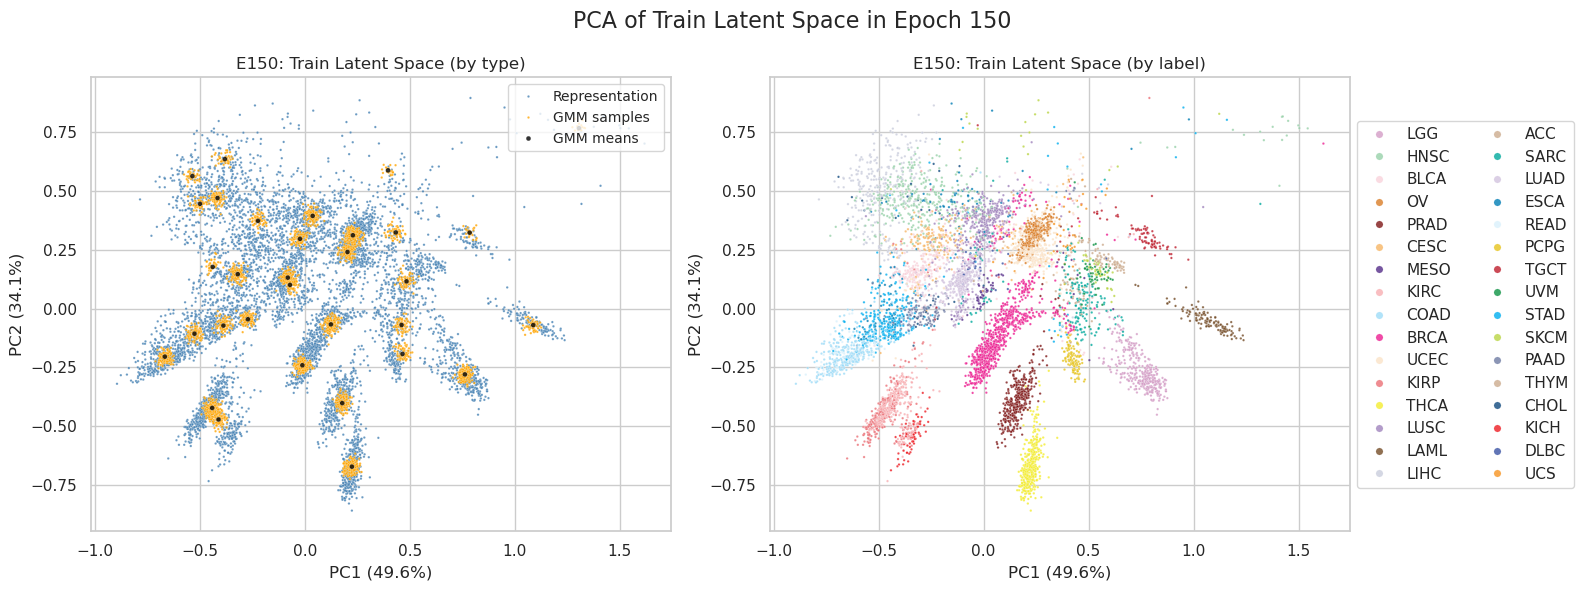

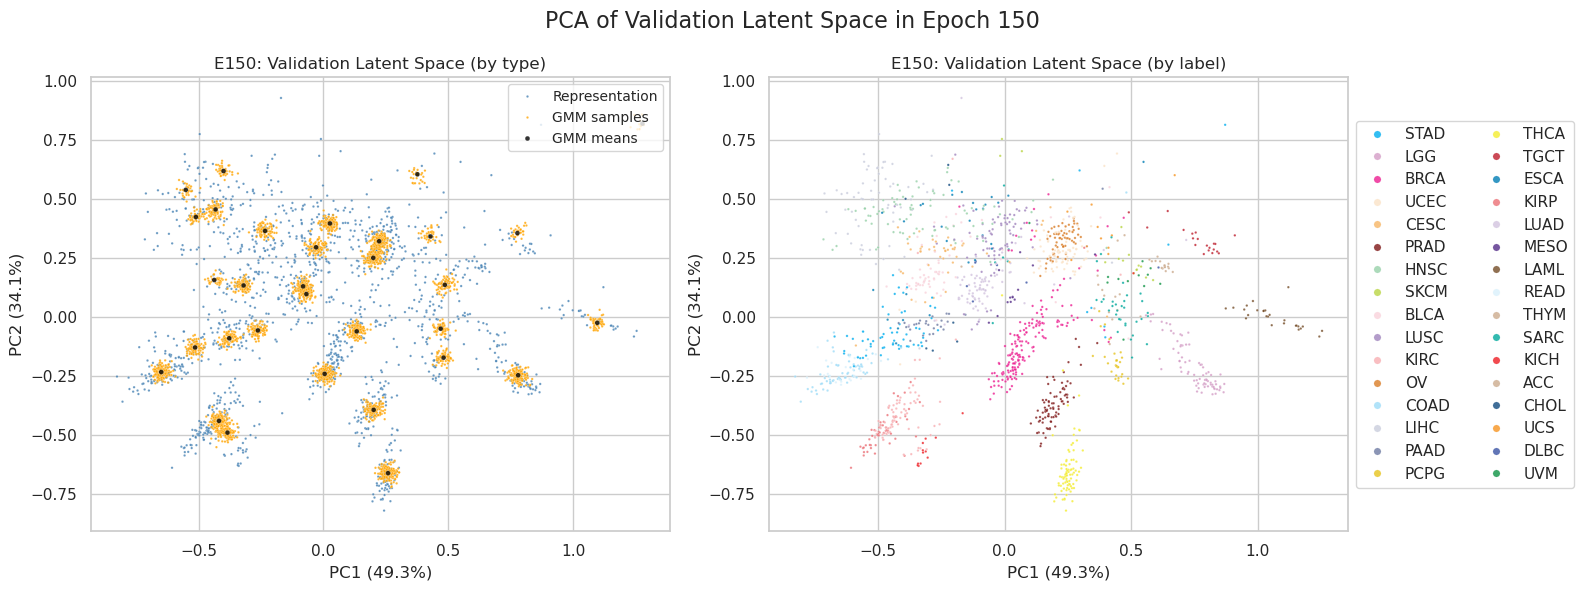

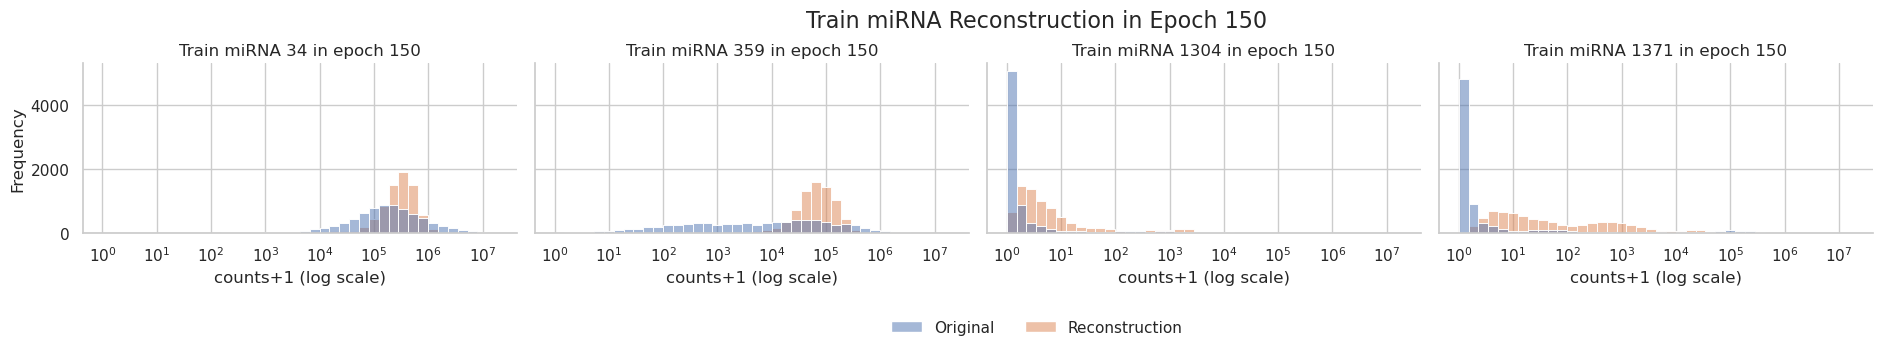

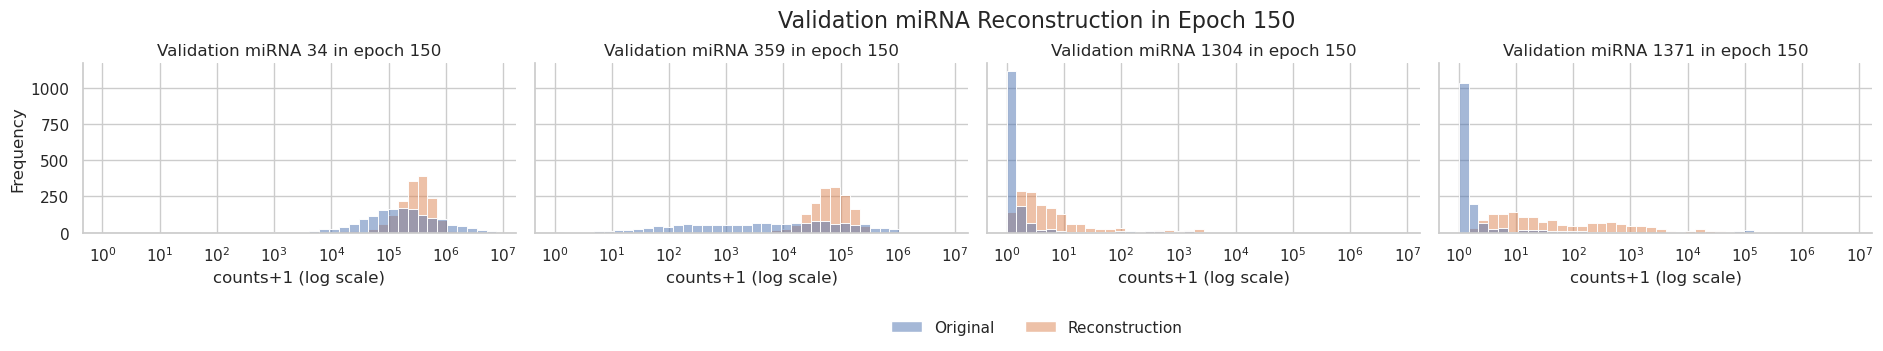

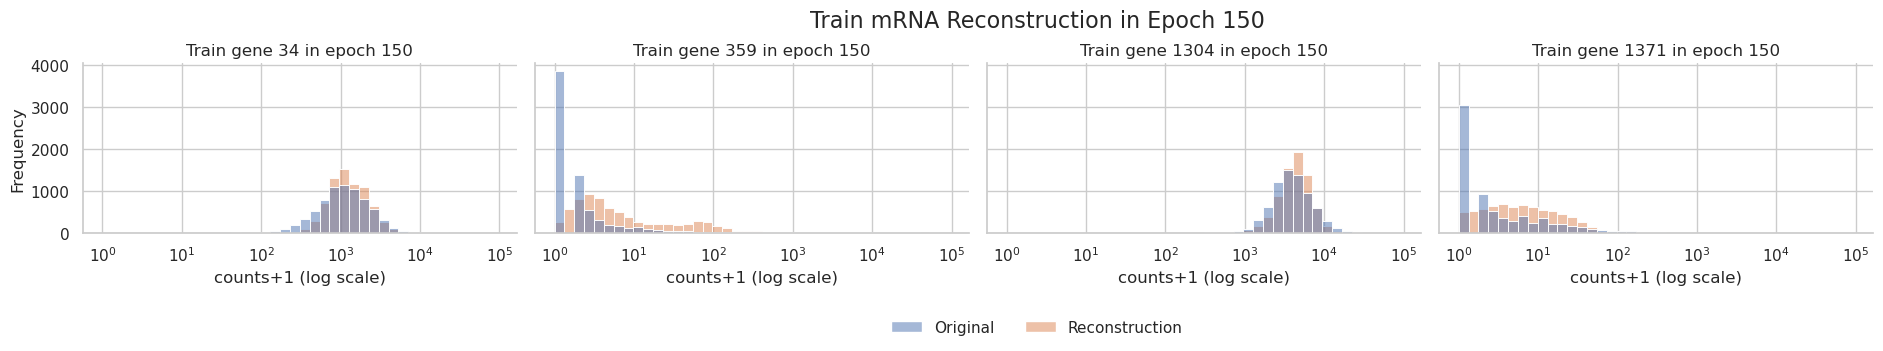

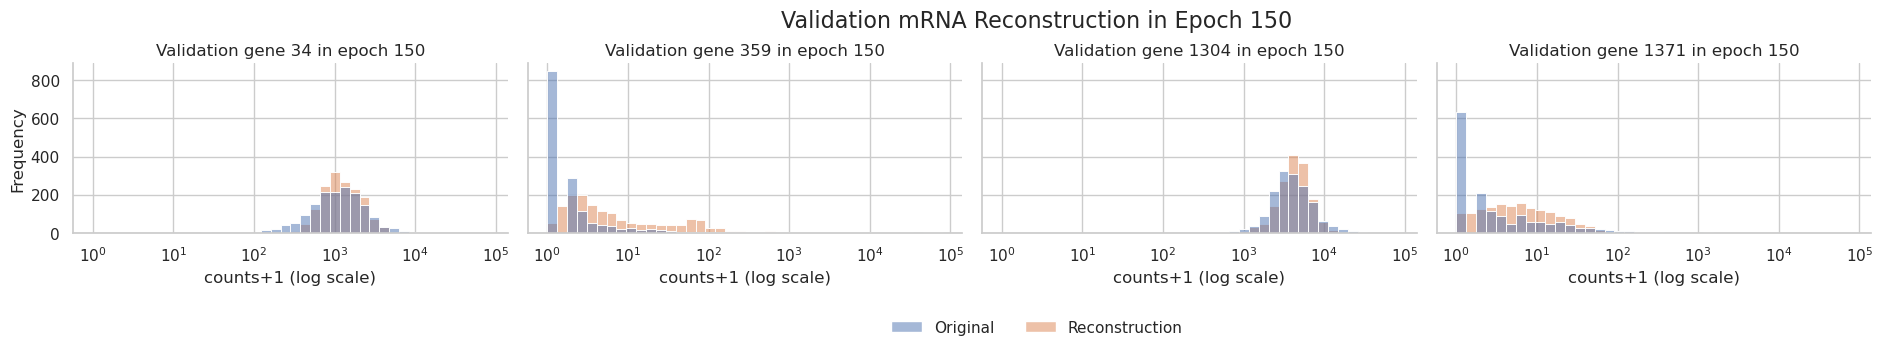

 10%|██████████████████████                                                                                                                                                                                              | 156/1500 [09:07<1:30:05,  4.02s/it]

155 train_loss: 10.492568178249524 train_recon_mirna: 2.1395421747987076 train_recon_mrna: 6.706781069661145 train_gmm: 1.6462449337896714 train_mse: 625207040.0 train_mae: 4384.3583984375 train_r2: 0.23845762014389038 train_spearman: 0.24429012835025787 train_pearson: 0.8909013867378235 train_msle: 13.369364738464355
155 test_loss: 10.489016830433929 test_recon_mirna: 2.1299656479206606 test_recon_mrna: 6.715395450406562 test_gmm: 1.6436557321067058 test_mse: 533677856.0 test_mae: 4070.050048828125 test_r2: 0.25135141611099243 test_spearman: 0.2399599552154541 test_pearson: 0.8855252265930176 test_msle: 13.461823463439941


 11%|██████████████████████▊                                                                                                                                                                                             | 161/1500 [09:22<1:13:58,  3.31s/it]

160 train_loss: 10.474210558014162 train_recon_mirna: 2.1279607509578398 train_recon_mrna: 6.695440262805619 train_gmm: 1.6508095442507034 train_mse: 621558400.0 train_mae: 4317.54638671875 train_r2: 0.2429019808769226 train_spearman: 0.25619789958000183 train_pearson: 0.8937647342681885 train_msle: 12.309536933898926
160 test_loss: 10.481289195155512 test_recon_mirna: 2.1313535565733948 test_recon_mrna: 6.7032131117477185 test_gmm: 1.6467225268343997 test_mse: 531559904.0 test_mae: 4007.742431640625 test_r2: 0.25432246923446655 test_spearman: 0.24956023693084717 test_pearson: 0.8875202536582947 test_msle: 12.389586448669434


 11%|███████████████████████▍                                                                                                                                                                                            | 166/1500 [09:38<1:10:51,  3.19s/it]

165 train_loss: 10.45979809137462 train_recon_mirna: 2.1202938716100963 train_recon_mrna: 6.685350731052719 train_gmm: 1.6541534887118017 train_mse: 616913728.0 train_mae: 4261.7919921875 train_r2: 0.24855941534042358 train_spearman: 0.26758235692977905 train_pearson: 0.8934965133666992 train_msle: 11.206337928771973
165 test_loss: 10.456753810480297 test_recon_mirna: 2.1177086960697893 test_recon_mrna: 6.686487542939848 test_gmm: 1.65255757147066 test_mse: 526724832.0 test_mae: 3951.391845703125 test_r2: 0.26110512018203735 test_spearman: 0.2573791742324829 test_pearson: 0.8899698257446289 test_msle: 11.36153507232666


 11%|████████████████████████▏                                                                                                                                                                                           | 171/1500 [09:54<1:11:23,  3.22s/it]

170 train_loss: 10.437919201904023 train_recon_mirna: 2.1112449713075105 train_recon_mrna: 6.669115865908172 train_gmm: 1.6575583646883396 train_mse: 614289792.0 train_mae: 4220.39501953125 train_r2: 0.2517555356025696 train_spearman: 0.28222545981407166 train_pearson: 0.8971677422523499 train_msle: 9.701809883117676
170 test_loss: 10.441463782850269 test_recon_mirna: 2.1140857619810647 test_recon_mrna: 6.672006482649927 test_gmm: 1.6553715382192782 test_mse: 522088608.0 test_mae: 3892.956298828125 test_r2: 0.2676088809967041 test_spearman: 0.26822641491889954 test_pearson: 0.8922169208526611 test_msle: 9.709819793701172


 12%|████████████████████████▊                                                                                                                                                                                           | 176/1500 [10:10<1:10:13,  3.18s/it]

175 train_loss: 10.413682388115808 train_recon_mirna: 2.1004162759459666 train_recon_mrna: 6.652975661241853 train_gmm: 1.660290450927988 train_mse: 608637184.0 train_mae: 4183.2109375 train_r2: 0.2586408257484436 train_spearman: 0.2940595746040344 train_pearson: 0.8963955640792847 train_msle: 8.851117134094238
175 test_loss: 10.43069812387922 test_recon_mirna: 2.11180295170567 test_recon_mrna: 6.660371610799384 test_gmm: 1.6585235613741651 test_mse: 516779488.0 test_mae: 3853.497802734375 test_r2: 0.2750566005706787 test_spearman: 0.2773352265357971 test_pearson: 0.894843578338623 test_msle: 8.954641342163086


 12%|█████████████████████████▌                                                                                                                                                                                          | 181/1500 [10:26<1:10:59,  3.23s/it]

180 train_loss: 10.407642667750006 train_recon_mirna: 2.099269479412646 train_recon_mrna: 6.645685243925563 train_gmm: 1.6626879444117963 train_mse: 591725056.0 train_mae: 4116.42236328125 train_r2: 0.27924084663391113 train_spearman: 0.3001434803009033 train_pearson: 0.8899615406990051 train_msle: 9.030582427978516
180 test_loss: 10.423398274567127 test_recon_mirna: 2.102995342463905 test_recon_mrna: 6.660656806028182 test_gmm: 1.6597461260750384 test_mse: 498571776.0 test_mae: 3777.5712890625 test_r2: 0.3005985617637634 test_spearman: 0.28460755944252014 test_pearson: 0.8879997730255127 test_msle: 9.160783767700195


 12%|██████████████████████████▎                                                                                                                                                                                         | 186/1500 [10:42<1:09:53,  3.19s/it]

185 train_loss: 10.376999075440951 train_recon_mirna: 2.081617672454521 train_recon_mrna: 6.630976674841907 train_gmm: 1.664404728144523 train_mse: 585991488.0 train_mae: 4083.974609375 train_r2: 0.28622472286224365 train_spearman: 0.3131612539291382 train_pearson: 0.8918492197990417 train_msle: 8.697611808776855
185 test_loss: 10.422422737962215 test_recon_mirna: 2.105290058793824 test_recon_mrna: 6.65278869157936 test_gmm: 1.6643439875890325 test_mse: 496452800.0 test_mae: 3762.65283203125 test_r2: 0.30357104539871216 test_spearman: 0.2947610914707184 test_pearson: 0.8876022696495056 test_msle: 8.737618446350098


 13%|██████████████████████████▉                                                                                                                                                                                         | 191/1500 [10:58<1:10:14,  3.22s/it]

190 train_loss: 10.36386888434317 train_recon_mirna: 2.075616245113007 train_recon_mrna: 6.623332689412361 train_gmm: 1.6649199498178 train_mse: 578605504.0 train_mae: 4042.738037109375 train_r2: 0.2952212691307068 train_spearman: 0.3250328302383423 train_pearson: 0.8931971192359924 train_msle: 7.96941614151001
190 test_loss: 10.402097702402221 test_recon_mirna: 2.104704172491866 test_recon_mrna: 6.633374336803346 test_gmm: 1.6640191931070087 test_mse: 492844960.0 test_mae: 3722.458740234375 test_r2: 0.3086321949958801 test_spearman: 0.30585944652557373 test_pearson: 0.893414318561554 test_msle: 8.053863525390625


 13%|███████████████████████████▋                                                                                                                                                                                        | 196/1500 [11:15<1:10:09,  3.23s/it]

195 train_loss: 10.360806280020201 train_recon_mirna: 2.0764150667836256 train_recon_mrna: 6.6176420031094905 train_gmm: 1.6667492101270847 train_mse: 572355072.0 train_mae: 4009.970458984375 train_r2: 0.30283474922180176 train_spearman: 0.33957162499427795 train_pearson: 0.8924424648284912 train_msle: 7.224102973937988
195 test_loss: 10.402757638592949 test_recon_mirna: 2.0991124026313623 test_recon_mrna: 6.636943180112232 test_gmm: 1.6667020558493542 test_mse: 487953696.0 test_mae: 3683.27099609375 test_r2: 0.31549370288848877 test_spearman: 0.3217029571533203 test_pearson: 0.8964921236038208 test_msle: 7.3357062339782715


 13%|████████████████████████████▍                                                                                                                                                                                       | 201/1500 [11:30<1:08:20,  3.16s/it]

200 train_loss: 10.347003326783188 train_recon_mirna: 2.0730851527729417 train_recon_mrna: 6.607038920962625 train_gmm: 1.6668792530476215 train_mse: 561344704.0 train_mae: 3964.145263671875 train_r2: 0.31624603271484375 train_spearman: 0.3437711000442505 train_pearson: 0.8929449319839478 train_msle: 7.31735897064209
200 test_loss: 10.385047559072541 test_recon_mirna: 2.096634377232636 test_recon_mrna: 6.617477411806694 test_gmm: 1.6709357700332117 test_mse: 479310784.0 test_mae: 3650.91357421875 test_r2: 0.3276180624961853 test_spearman: 0.3257933557033539 test_pearson: 0.8921399712562561 test_msle: 7.361527442932129


 14%|█████████████████████████████                                                                                                                                                                                       | 206/1500 [11:46<1:08:58,  3.20s/it]

205 train_loss: 10.332620219560033 train_recon_mirna: 2.066669646428528 train_recon_mrna: 6.599259899953068 train_gmm: 1.6666906731784363 train_mse: 554523456.0 train_mae: 3927.852783203125 train_r2: 0.32455480098724365 train_spearman: 0.3474867343902588 train_pearson: 0.893585205078125 train_msle: 6.93756628036499
205 test_loss: 10.377547634992743 test_recon_mirna: 2.0971606931066473 test_recon_mrna: 6.610016225069131 test_gmm: 1.6703707168169628 test_mse: 471473568.0 test_mae: 3609.57177734375 test_r2: 0.3386121988296509 test_spearman: 0.3261643350124359 test_pearson: 0.889354944229126 test_msle: 7.127171039581299


 14%|█████████████████████████████▊                                                                                                                                                                                      | 211/1500 [12:02<1:07:49,  3.16s/it]

210 train_loss: 10.314372294292369 train_recon_mirna: 2.0562683649633446 train_recon_mrna: 6.591043425519101 train_gmm: 1.6670605038099229 train_mse: 542853056.0 train_mae: 3873.692138671875 train_r2: 0.3387700915336609 train_spearman: 0.35207611322402954 train_pearson: 0.8923473358154297 train_msle: 6.595635414123535
210 test_loss: 10.367406291957206 test_recon_mirna: 2.0983879001398047 test_recon_mrna: 6.594675692612044 test_gmm: 1.6743426992053583 test_mse: 465041824.0 test_mae: 3570.007080078125 test_r2: 0.3476346731185913 test_spearman: 0.33058032393455505 test_pearson: 0.8866638541221619 test_msle: 6.74342679977417


 14%|██████████████████████████████▌                                                                                                                                                                                     | 216/1500 [12:18<1:07:12,  3.14s/it]

215 train_loss: 10.304746240910685 train_recon_mirna: 2.054906339892161 train_recon_mrna: 6.581423552653927 train_gmm: 1.6684163483645962 train_mse: 533190784.0 train_mae: 3837.20361328125 train_r2: 0.3505393862724304 train_spearman: 0.3506758511066437 train_pearson: 0.8930925726890564 train_msle: 6.955476760864258
215 test_loss: 10.374906244694442 test_recon_mirna: 2.096193792982262 test_recon_mrna: 6.60186047810696 test_gmm: 1.6768519736052208 test_mse: 458566816.0 test_mae: 3546.68212890625 test_r2: 0.35671788454055786 test_spearman: 0.323988139629364 test_pearson: 0.8909419178962708 test_msle: 7.100244522094727


 15%|███████████████████████████████▏                                                                                                                                                                                    | 221/1500 [12:33<1:06:46,  3.13s/it]

220 train_loss: 10.285431324003973 train_recon_mirna: 2.0451639089119857 train_recon_mrna: 6.571497936188331 train_gmm: 1.6687694789036562 train_mse: 526727456.0 train_mae: 3809.73583984375 train_r2: 0.35841214656829834 train_spearman: 0.35107481479644775 train_pearson: 0.8936974406242371 train_msle: 7.213588714599609
220 test_loss: 10.341898409699425 test_recon_mirna: 2.077236483074369 test_recon_mrna: 6.590512744725601 test_gmm: 1.6741491818994563 test_mse: 454346688.0 test_mae: 3534.564453125 test_r2: 0.3626379370689392 test_spearman: 0.32509371638298035 test_pearson: 0.8909657001495361 test_msle: 7.371313571929932


 15%|███████████████████████████████▊                                                                                                                                                                                    | 225/1500 [12:47<1:08:47,  3.24s/it]

225 train_loss: 10.27911071499263 train_recon_mirna: 2.043604290247584 train_recon_mrna: 6.567151088333534 train_gmm: 1.668355336411513 train_mse: 519563616.0 train_mae: 3768.122314453125 train_r2: 0.367138147354126 train_spearman: 0.3511451184749603 train_pearson: 0.8952546119689941 train_msle: 6.469586372375488
225 test_loss: 10.326561990412408 test_recon_mirna: 2.069938623786988 test_recon_mrna: 6.581298722223932 test_gmm: 1.675324644401488 test_mse: 444644704.0 test_mae: 3491.118408203125 test_r2: 0.37624794244766235 test_spearman: 0.3232850730419159 test_pearson: 0.8912695646286011 test_msle: 6.68989372253418


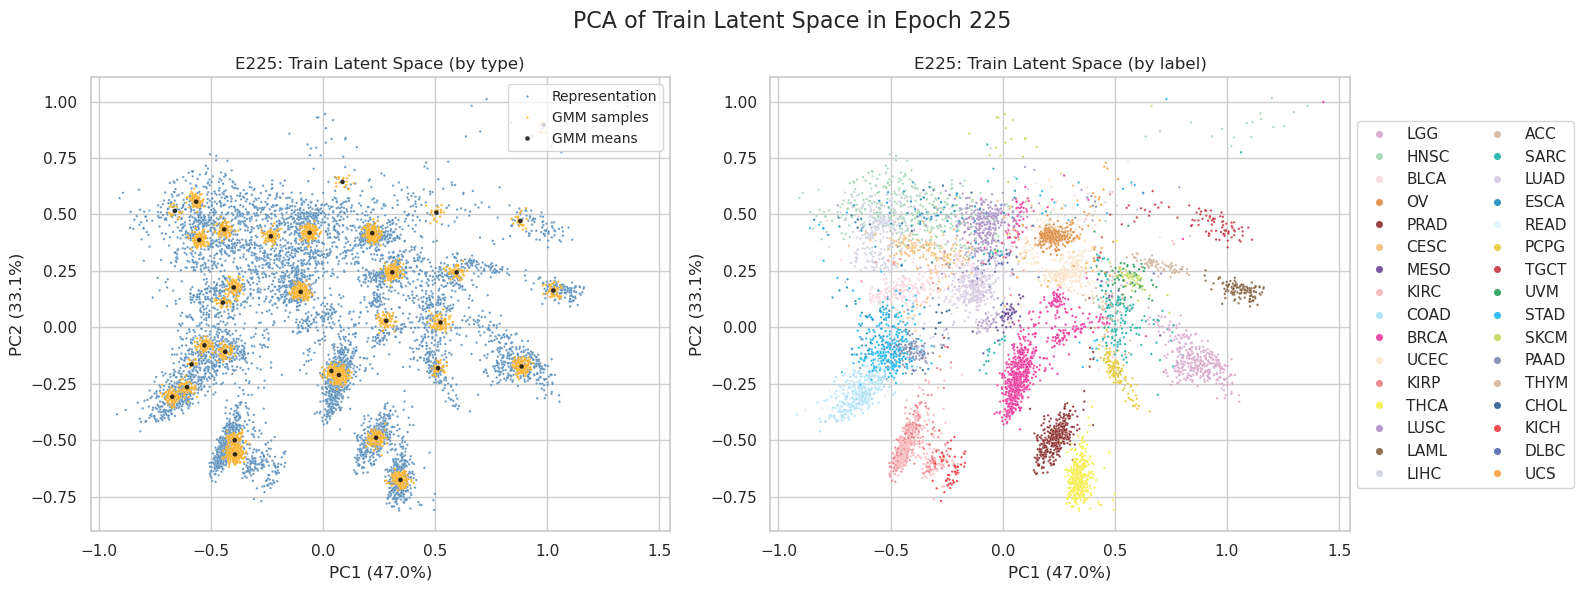

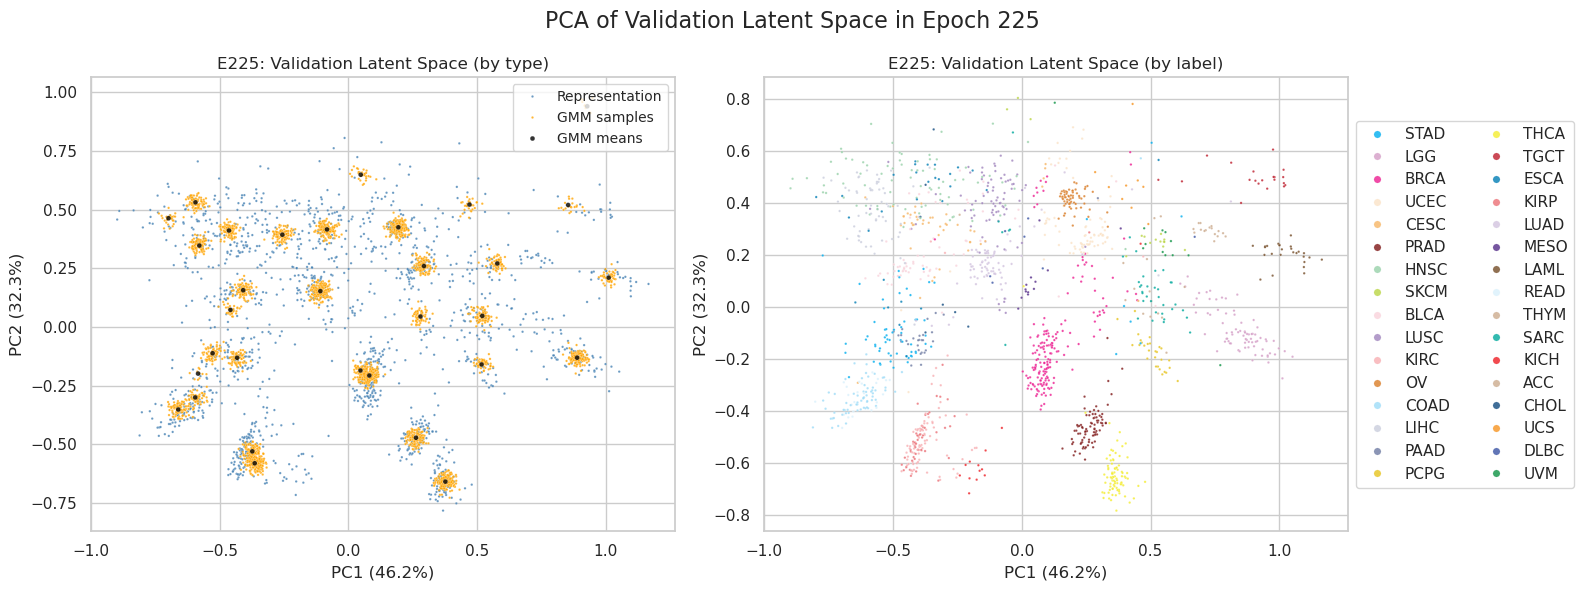

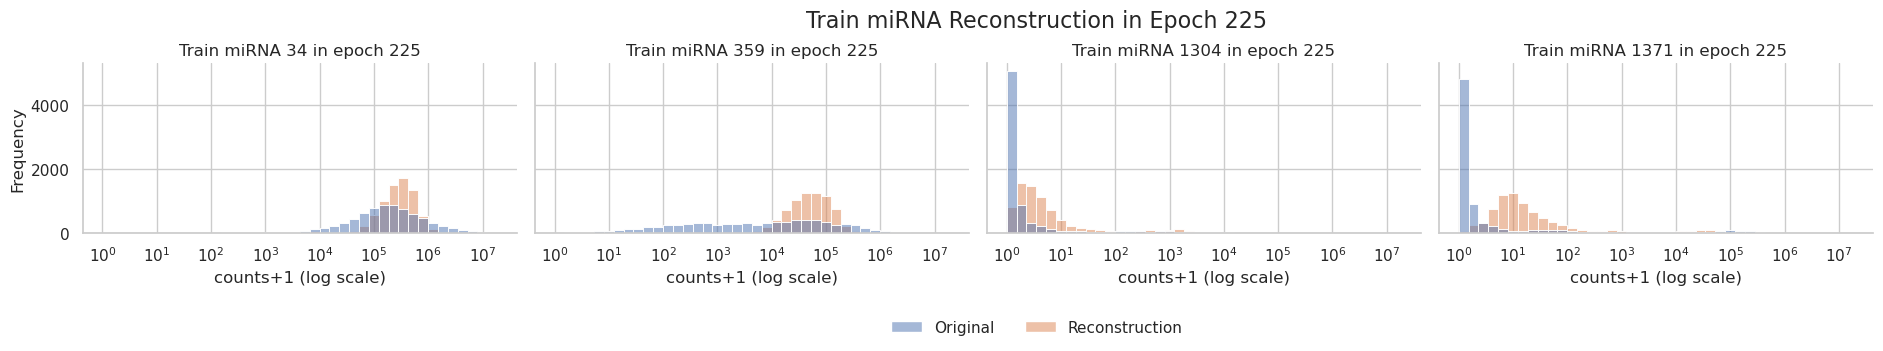

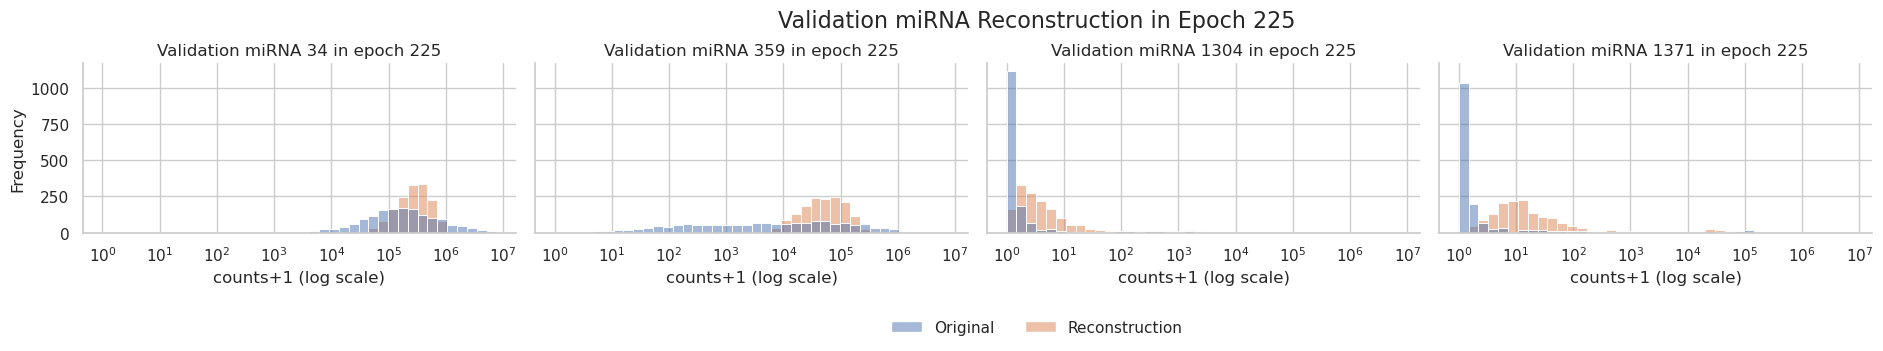

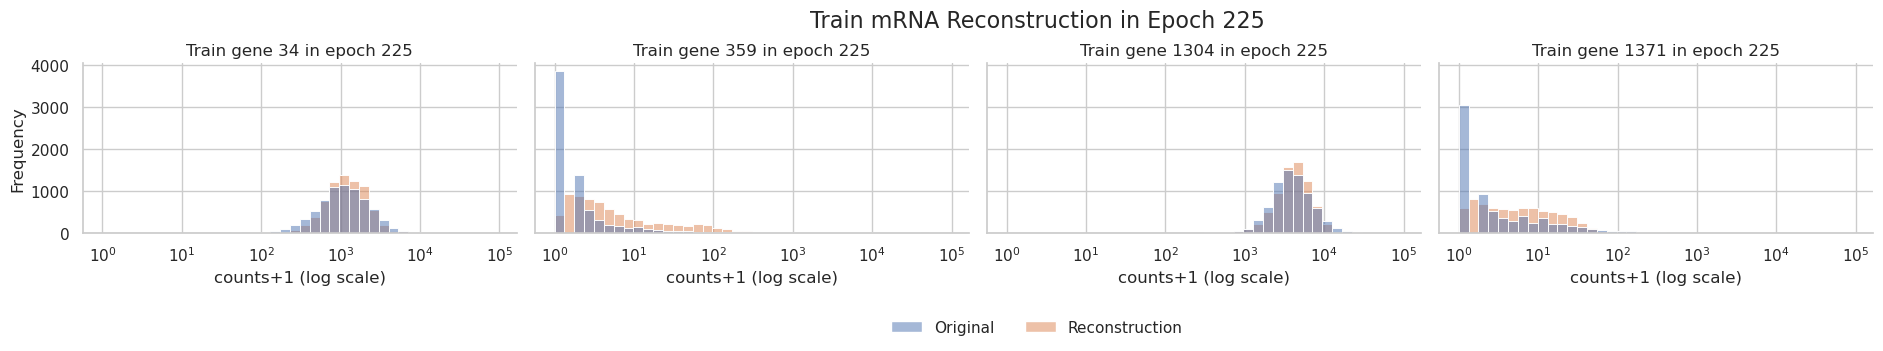

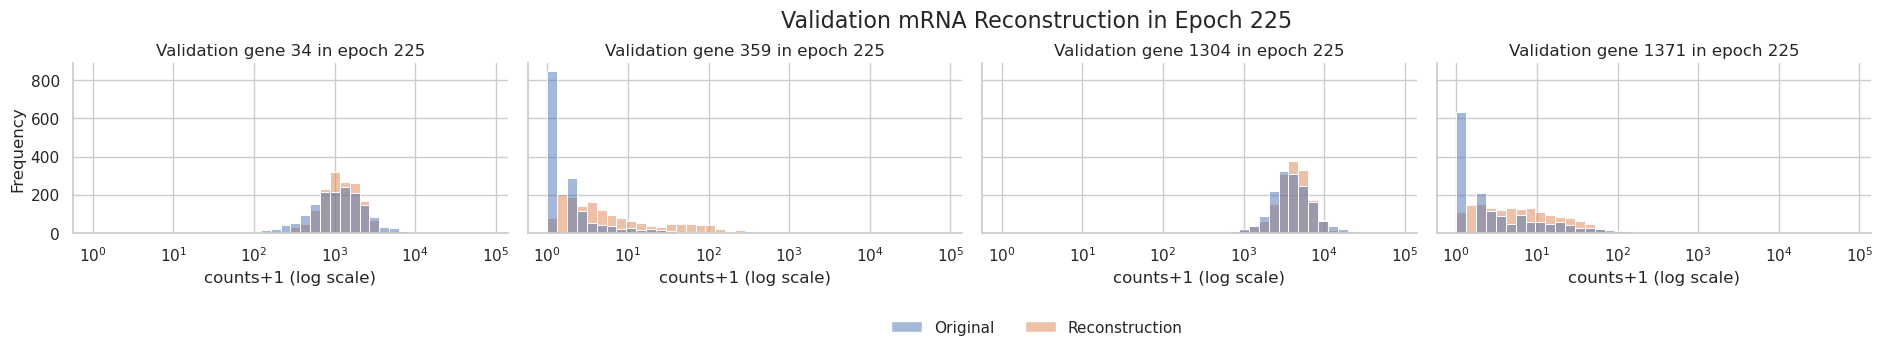

 15%|████████████████████████████████▋                                                                                                                                                                                   | 231/1500 [13:22<1:25:38,  4.05s/it]

230 train_loss: 10.268709854755965 train_recon_mirna: 2.040254023091731 train_recon_mrna: 6.559570278146322 train_gmm: 1.668885553517912 train_mse: 504372768.0 train_mae: 3707.432373046875 train_r2: 0.38564157485961914 train_spearman: 0.35052773356437683 train_pearson: 0.8916215896606445 train_msle: 6.971312522888184
230 test_loss: 10.318468064308043 test_recon_mirna: 2.0736244110016604 test_recon_mrna: 6.566304514727094 test_gmm: 1.678539138579287 test_mse: 432613632.0 test_mae: 3437.881103515625 test_r2: 0.3931252956390381 test_spearman: 0.3241877853870392 test_pearson: 0.8884244561195374 test_msle: 7.136094570159912


 16%|█████████████████████████████████▎                                                                                                                                                                                  | 236/1500 [13:38<1:08:44,  3.26s/it]

235 train_loss: 10.252612522994657 train_recon_mirna: 2.0339869287741417 train_recon_mrna: 6.549037015692781 train_gmm: 1.6695885785277327 train_mse: 502097824.0 train_mae: 3694.457275390625 train_r2: 0.38841259479522705 train_spearman: 0.34877824783325195 train_pearson: 0.8914880156517029 train_msle: 6.567806720733643
235 test_loss: 10.306355089987848 test_recon_mirna: 2.06239926032281 test_recon_mrna: 6.567284270180502 test_gmm: 1.6766715594845356 test_mse: 430648224.0 test_mae: 3424.57666015625 test_r2: 0.39588236808776855 test_spearman: 0.3228154182434082 test_pearson: 0.8884596824645996 test_msle: 6.711716651916504


 16%|██████████████████████████████████                                                                                                                                                                                  | 241/1500 [13:54<1:07:07,  3.20s/it]

240 train_loss: 10.246487697381509 train_recon_mirna: 2.0334410568611565 train_recon_mrna: 6.542964001607265 train_gmm: 1.670082638913089 train_mse: 490688000.0 train_mae: 3647.868896484375 train_r2: 0.40231049060821533 train_spearman: 0.3462228775024414 train_pearson: 0.8887286186218262 train_msle: 6.815993785858154
240 test_loss: 10.292070374787578 test_recon_mirna: 2.054117655751271 test_recon_mrna: 6.557269665576234 test_gmm: 1.680683053460072 test_mse: 424177440.0 test_mae: 3396.920654296875 test_r2: 0.40495961904525757 test_spearman: 0.31985071301460266 test_pearson: 0.8867032527923584 test_msle: 6.898403167724609


 16%|██████████████████████████████████▊                                                                                                                                                                                 | 246/1500 [14:10<1:07:14,  3.22s/it]

245 train_loss: 10.23515631960398 train_recon_mirna: 2.0258034213049485 train_recon_mrna: 6.5398298331387 train_gmm: 1.6695230651603328 train_mse: 484054176.0 train_mae: 3605.932861328125 train_r2: 0.4103909134864807 train_spearman: 0.34636199474334717 train_pearson: 0.8879568576812744 train_msle: 6.351219654083252
245 test_loss: 10.283529854014489 test_recon_mirna: 2.052517275223328 test_recon_mrna: 6.552070805882867 test_gmm: 1.678941772908293 test_mse: 418006944.0 test_mae: 3361.1494140625 test_r2: 0.41361570358276367 test_spearman: 0.3220258951187134 test_pearson: 0.8890672922134399 test_msle: 6.491987228393555


 17%|███████████████████████████████████▍                                                                                                                                                                                | 251/1500 [14:26<1:05:43,  3.16s/it]

250 train_loss: 10.220419486508531 train_recon_mirna: 2.021687878473374 train_recon_mrna: 6.527425794086388 train_gmm: 1.6713058139487686 train_mse: 485960704.0 train_mae: 3612.070068359375 train_r2: 0.4080686569213867 train_spearman: 0.350620299577713 train_pearson: 0.8913045525550842 train_msle: 6.277512073516846
250 test_loss: 10.28350213709583 test_recon_mirna: 2.0458536994460492 test_recon_mrna: 6.556471850120965 test_gmm: 1.6811765875288154 test_mse: 413291136.0 test_mae: 3342.7822265625 test_r2: 0.42023104429244995 test_spearman: 0.3293096125125885 test_pearson: 0.8828953504562378 test_msle: 6.460872650146484


 17%|████████████████████████████████████▏                                                                                                                                                                               | 256/1500 [14:41<1:04:20,  3.10s/it]

255 train_loss: 10.219454815383529 train_recon_mirna: 2.0196099788149953 train_recon_mrna: 6.527867823073225 train_gmm: 1.6719770134953083 train_mse: 479440672.0 train_mae: 3582.603759765625 train_r2: 0.41601043939590454 train_spearman: 0.34973299503326416 train_pearson: 0.8877465724945068 train_msle: 6.515882968902588
255 test_loss: 10.236993650730316 test_recon_mirna: 2.02941827459305 test_recon_mrna: 6.526867011017646 test_gmm: 1.680708365119621 test_mse: 408059392.0 test_mae: 3318.089599609375 test_r2: 0.4275702238082886 test_spearman: 0.32564210891723633 test_pearson: 0.882518470287323 test_msle: 6.678619384765625


 17%|████████████████████████████████████▉                                                                                                                                                                               | 261/1500 [14:57<1:04:58,  3.15s/it]

260 train_loss: 10.203077191096085 train_recon_mirna: 2.0133148437732435 train_recon_mrna: 6.517006066306085 train_gmm: 1.6727562810167556 train_mse: 472378144.0 train_mae: 3549.4609375 train_r2: 0.4246130585670471 train_spearman: 0.349491149187088 train_pearson: 0.8887144923210144 train_msle: 6.364436149597168
260 test_loss: 10.256207584542713 test_recon_mirna: 2.0352464187872963 test_recon_mrna: 6.537185024612293 test_gmm: 1.6837761411431242 test_mse: 403298304.0 test_mae: 3291.6474609375 test_r2: 0.4342491030693054 test_spearman: 0.32670480012893677 test_pearson: 0.8858333826065063 test_msle: 6.382352828979492


 18%|█████████████████████████████████████▌                                                                                                                                                                              | 266/1500 [15:13<1:04:55,  3.16s/it]

265 train_loss: 10.200637836444619 train_recon_mirna: 2.0124502795282924 train_recon_mrna: 6.51511938821567 train_gmm: 1.6730681687006583 train_mse: 467254944.0 train_mae: 3527.694580078125 train_r2: 0.4308534264564514 train_spearman: 0.3470035493373871 train_pearson: 0.8869682550430298 train_msle: 6.410094261169434
265 test_loss: 10.237893860373664 test_recon_mirna: 2.0239072872121024 test_recon_mrna: 6.532937496364658 test_gmm: 1.6810490767969026 test_mse: 397310944.0 test_mae: 3271.116455078125 test_r2: 0.4426482319831848 test_spearman: 0.3300528824329376 test_pearson: 0.8817294836044312 test_msle: 6.467739105224609


 18%|██████████████████████████████████████▎                                                                                                                                                                             | 271/1500 [15:29<1:04:27,  3.15s/it]

270 train_loss: 10.193523020617397 train_recon_mirna: 2.0094653165705427 train_recon_mrna: 6.510789762269452 train_gmm: 1.6732679417774017 train_mse: 463720576.0 train_mae: 3507.43896484375 train_r2: 0.43515855073928833 train_spearman: 0.3521454930305481 train_pearson: 0.886197030544281 train_msle: 6.4602952003479
270 test_loss: 10.23376521686385 test_recon_mirna: 2.0250362843536855 test_recon_mrna: 6.52590863120848 test_gmm: 1.6828203013016831 test_mse: 398422400.0 test_mae: 3287.59423828125 test_r2: 0.44108909368515015 test_spearman: 0.332209050655365 test_pearson: 0.8761549592018127 test_msle: 6.514725685119629


 18%|███████████████████████████████████████                                                                                                                                                                             | 276/1500 [15:45<1:04:57,  3.18s/it]

275 train_loss: 10.186037868240785 train_recon_mirna: 2.005213226668189 train_recon_mrna: 6.506262504507247 train_gmm: 1.6745621370653496 train_mse: 459066400.0 train_mae: 3485.28955078125 train_r2: 0.4408276081085205 train_spearman: 0.3500436544418335 train_pearson: 0.8848106265068054 train_msle: 6.9040727615356445
275 test_loss: 10.219534871894712 test_recon_mirna: 2.0219666705965347 test_recon_mrna: 6.5184330842538305 test_gmm: 1.6791351170443463 test_mse: 390332064.0 test_mae: 3251.732421875 test_r2: 0.4524382948875427 test_spearman: 0.33295881748199463 test_pearson: 0.8775917887687683 test_msle: 6.928624629974365


 19%|███████████████████████████████████████▋                                                                                                                                                                            | 281/1500 [16:00<1:04:09,  3.16s/it]

280 train_loss: 10.168609808353994 train_recon_mirna: 1.9961345509861588 train_recon_mrna: 6.498374863317429 train_gmm: 1.6741003940504062 train_mse: 454495328.0 train_mae: 3454.709716796875 train_r2: 0.4463954567909241 train_spearman: 0.34843921661376953 train_pearson: 0.8844677209854126 train_msle: 6.290647029876709
280 test_loss: 10.219557138933066 test_recon_mirna: 2.0221079972707225 test_recon_mrna: 6.516417482866054 test_gmm: 1.6810316587962895 test_mse: 387781024.0 test_mae: 3243.94091796875 test_r2: 0.4560168981552124 test_spearman: 0.3289632499217987 test_pearson: 0.8732345104217529 test_msle: 6.3140950202941895


 19%|████████████████████████████████████████▍                                                                                                                                                                           | 286/1500 [16:17<1:05:50,  3.25s/it]

285 train_loss: 10.16044226827299 train_recon_mirna: 1.9933556870281737 train_recon_mrna: 6.490606229117024 train_gmm: 1.6764803521277911 train_mse: 459649504.0 train_mae: 3471.390380859375 train_r2: 0.44011735916137695 train_spearman: 0.35294198989868164 train_pearson: 0.8830106854438782 train_msle: 6.270750522613525
285 test_loss: 10.194244352955948 test_recon_mirna: 2.00754759530626 test_recon_mrna: 6.507509603065814 test_gmm: 1.6791871545838752 test_mse: 389372896.0 test_mae: 3242.41162109375 test_r2: 0.4537838101387024 test_spearman: 0.3360233008861542 test_pearson: 0.8800125122070312 test_msle: 6.383739471435547


 19%|█████████████████████████████████████████▏                                                                                                                                                                          | 291/1500 [16:33<1:04:44,  3.21s/it]

290 train_loss: 10.152339374837489 train_recon_mirna: 1.9921785835274999 train_recon_mrna: 6.484414123309459 train_gmm: 1.675746668000529 train_mse: 452433088.0 train_mae: 3431.393310546875 train_r2: 0.44890743494033813 train_spearman: 0.35922878980636597 train_pearson: 0.8843117952346802 train_msle: 5.880748748779297
290 test_loss: 10.192261533431857 test_recon_mirna: 2.0096887074706897 test_recon_mrna: 6.50292108553492 test_gmm: 1.6796517404262472 test_mse: 384026976.0 test_mae: 3200.2294921875 test_r2: 0.4612831473350525 test_spearman: 0.34331202507019043 test_pearson: 0.8821195363998413 test_msle: 5.944680690765381


 20%|█████████████████████████████████████████▊                                                                                                                                                                          | 296/1500 [16:49<1:02:53,  3.13s/it]

295 train_loss: 10.142539101064306 train_recon_mirna: 1.9867873566925085 train_recon_mrna: 6.479067204378102 train_gmm: 1.6766845399936956 train_mse: 443773824.0 train_mae: 3403.754150390625 train_r2: 0.4594549536705017 train_spearman: 0.353347510099411 train_pearson: 0.8807610273361206 train_msle: 6.434572219848633
295 test_loss: 10.1920913367951 test_recon_mirna: 2.0062106738802767 test_recon_mrna: 6.501826613026205 test_gmm: 1.6840540498886172 test_mse: 385755968.0 test_mae: 3239.666748046875 test_r2: 0.4588576555252075 test_spearman: 0.33545321226119995 test_pearson: 0.87306147813797 test_msle: 6.451889991760254


 20%|██████████████████████████████████████████▍                                                                                                                                                                         | 300/1500 [17:01<1:02:43,  3.14s/it]

300 train_loss: 10.134039616474048 train_recon_mirna: 1.9808811933477941 train_recon_mrna: 6.4778902539206955 train_gmm: 1.6752681692055593 train_mse: 453805312.0 train_mae: 3445.815185546875 train_r2: 0.44723600149154663 train_spearman: 0.3599535822868347 train_pearson: 0.8832032084465027 train_msle: 5.805521011352539
300 test_loss: 10.180881869621127 test_recon_mirna: 1.996029973301526 test_recon_mrna: 6.499546434519485 test_gmm: 1.6853054618001166 test_mse: 385970336.0 test_mae: 3219.302001953125 test_r2: 0.4585569500923157 test_spearman: 0.3465338349342346 test_pearson: 0.8769100904464722 test_msle: 5.909790515899658


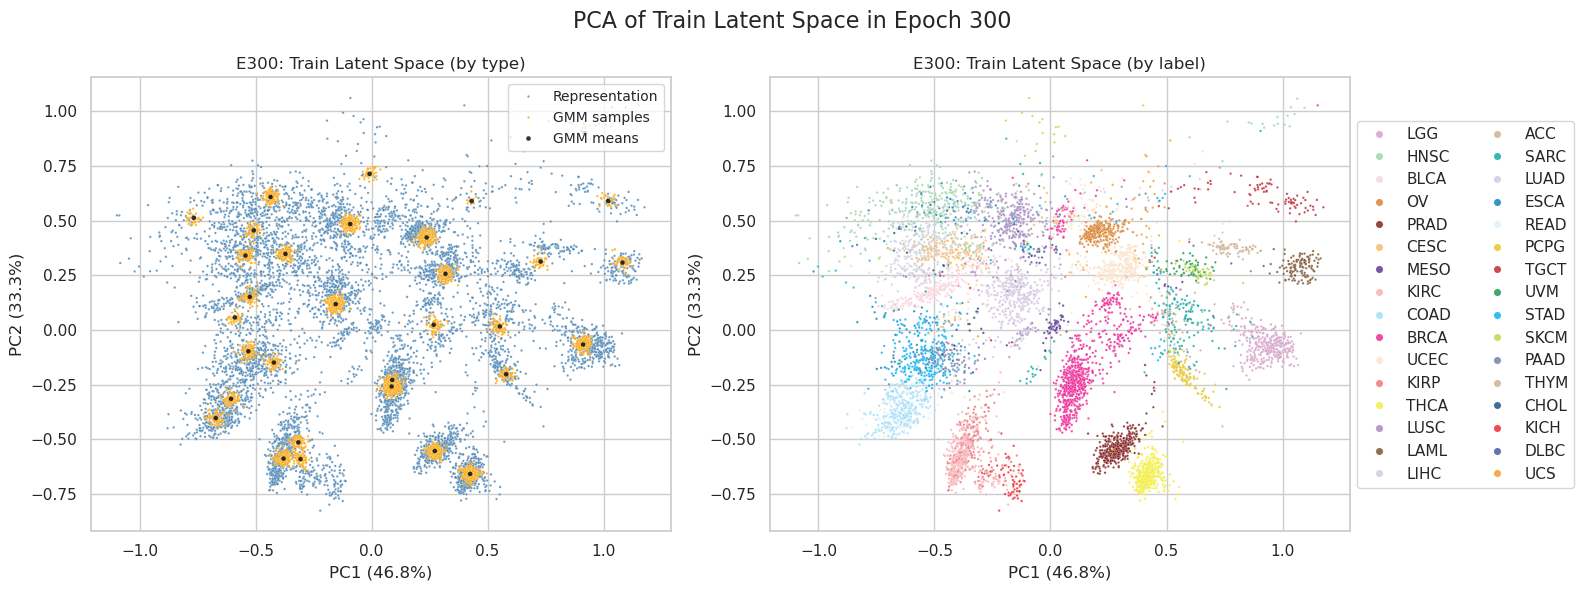

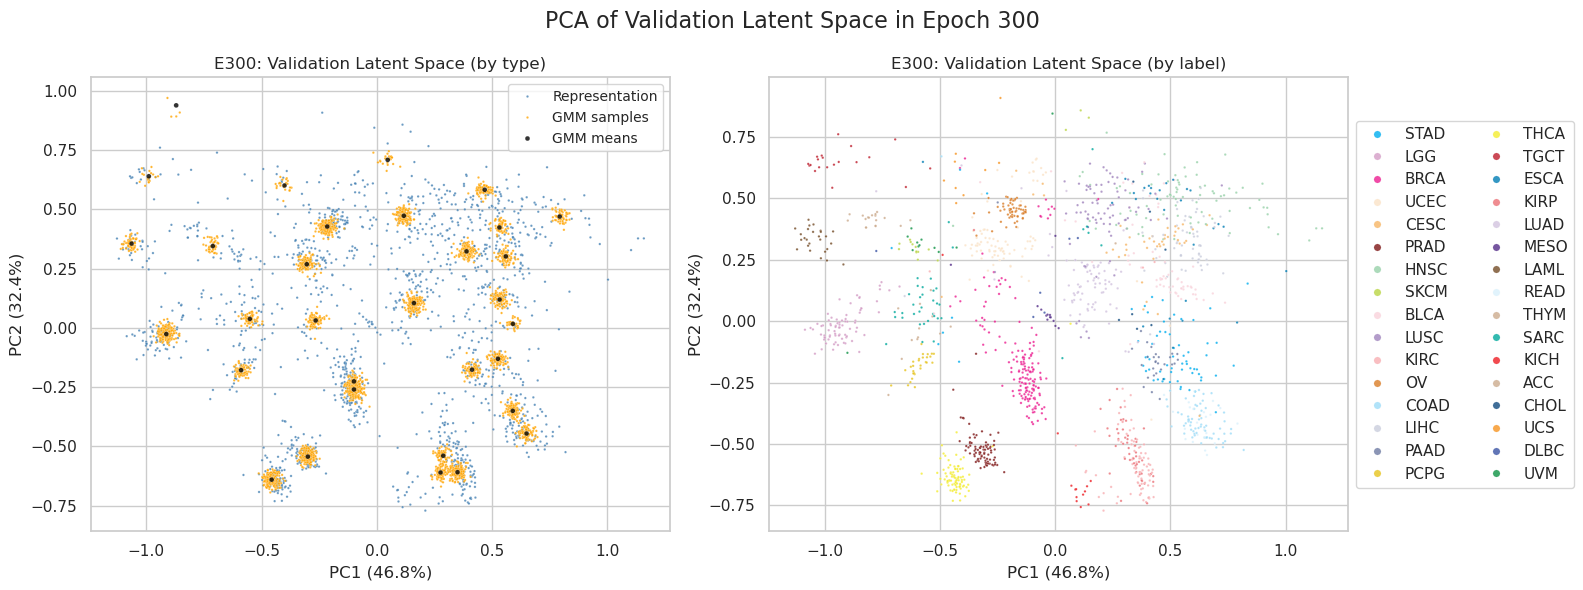

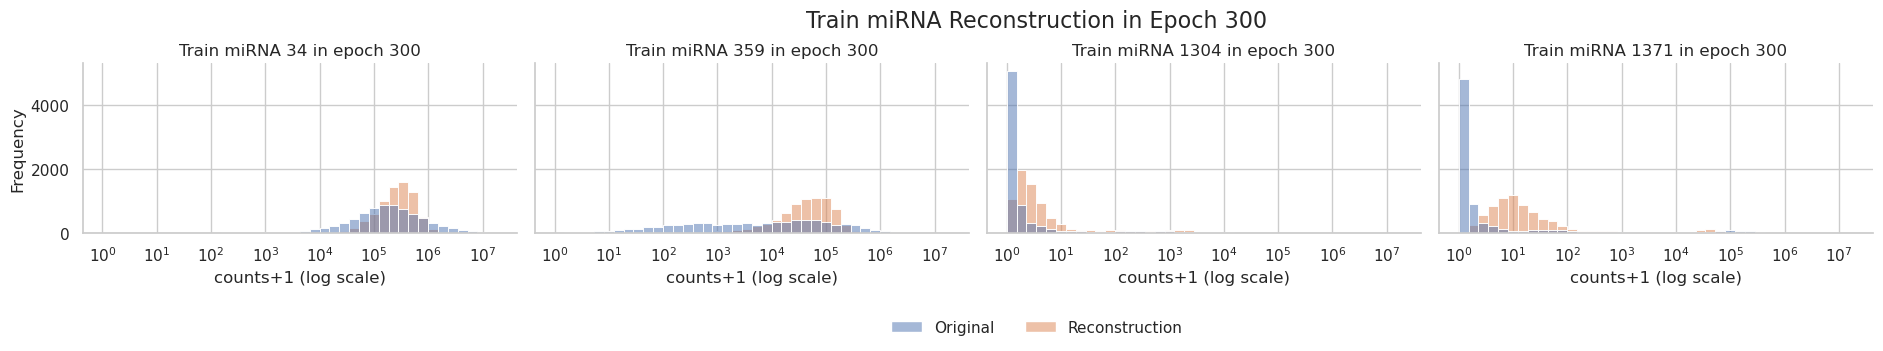

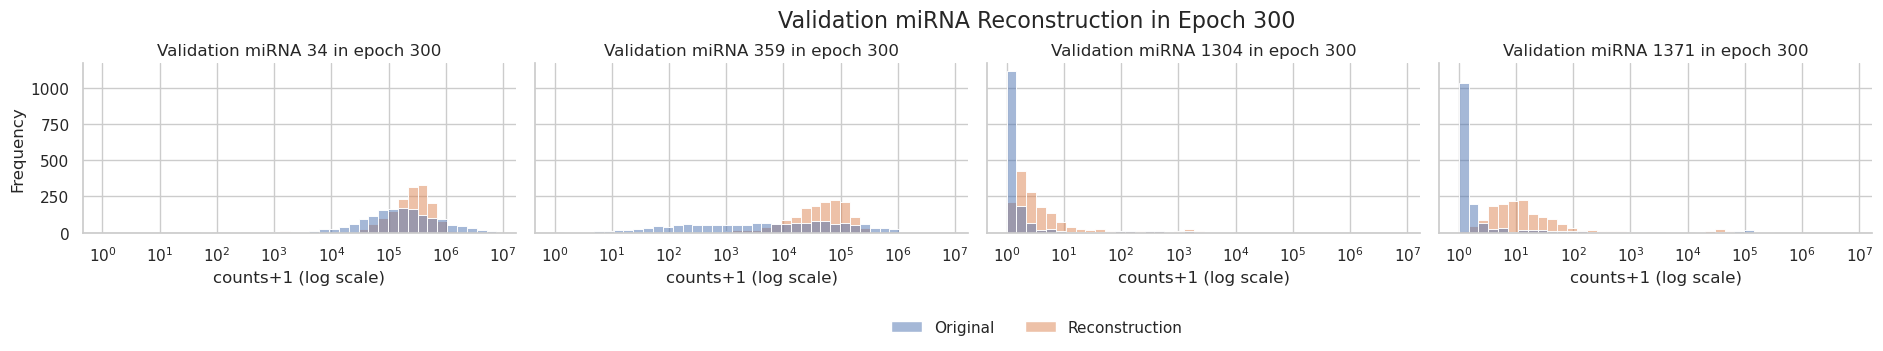

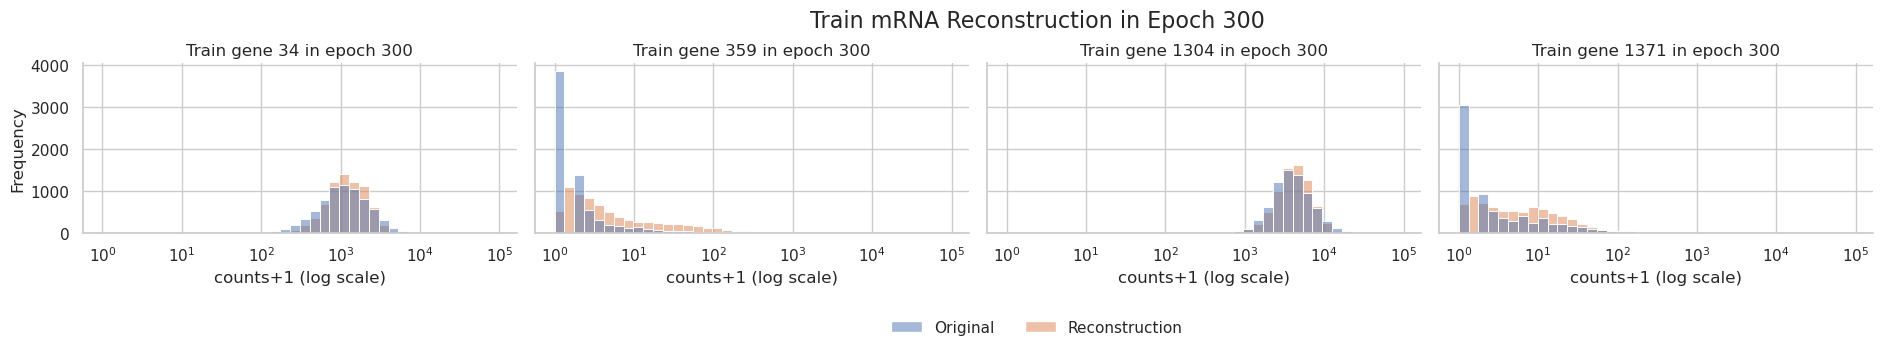

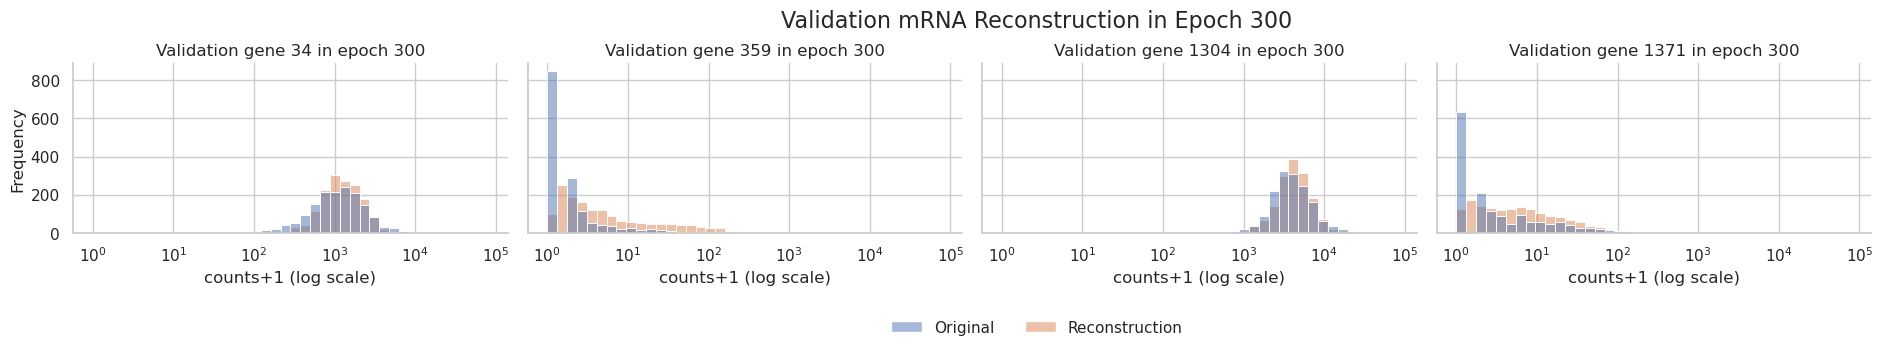

 20%|███████████████████████████████████████████▏                                                                                                                                                                        | 306/1500 [17:36<1:19:25,  3.99s/it]

305 train_loss: 10.13226309192344 train_recon_mirna: 1.9814595308624359 train_recon_mrna: 6.473321914951394 train_gmm: 1.6774816461096098 train_mse: 452765248.0 train_mae: 3433.936279296875 train_r2: 0.4485028386116028 train_spearman: 0.36110857129096985 train_pearson: 0.8845053315162659 train_msle: 5.728837013244629
305 test_loss: 10.162195787304146 test_recon_mirna: 1.9894716647145823 test_recon_mrna: 6.493839466869694 test_gmm: 1.6788846557198693 test_mse: 384237408.0 test_mae: 3194.34423828125 test_r2: 0.46098792552948 test_spearman: 0.3456957936286926 test_pearson: 0.8785845637321472 test_msle: 5.7425737380981445


 21%|███████████████████████████████████████████▉                                                                                                                                                                        | 311/1500 [17:52<1:05:48,  3.32s/it]

310 train_loss: 10.11557722772317 train_recon_mirna: 1.974752066538312 train_recon_mrna: 6.462994919981816 train_gmm: 1.6778302412030421 train_mse: 445528896.0 train_mae: 3404.404052734375 train_r2: 0.45731717348098755 train_spearman: 0.36335596442222595 train_pearson: 0.8808625340461731 train_msle: 6.00899600982666
310 test_loss: 10.15498498827631 test_recon_mirna: 1.9839473256873308 test_recon_mrna: 6.49128357878216 test_gmm: 1.6797540838068181 test_mse: 384261824.0 test_mae: 3199.138427734375 test_r2: 0.4609537124633789 test_spearman: 0.35058262944221497 test_pearson: 0.8842206001281738 test_msle: 5.948620796203613


 21%|████████████████████████████████████████████▋                                                                                                                                                                       | 316/1500 [18:08<1:03:38,  3.22s/it]

315 train_loss: 10.111522788047205 train_recon_mirna: 1.9738956289166192 train_recon_mrna: 6.459314684969632 train_gmm: 1.6783124741609536 train_mse: 442531680.0 train_mae: 3384.705078125 train_r2: 0.4609679579734802 train_spearman: 0.3619241714477539 train_pearson: 0.8831616044044495 train_msle: 5.952988624572754
315 test_loss: 10.164000179125663 test_recon_mirna: 1.9804690210484588 test_recon_mrna: 6.496735916068879 test_gmm: 1.686795242008327 test_mse: 380040032.0 test_mae: 3174.29150390625 test_r2: 0.4668760895729065 test_spearman: 0.3513409197330475 test_pearson: 0.8831422328948975 test_msle: 5.935359477996826


 21%|█████████████████████████████████████████████▎                                                                                                                                                                      | 321/1500 [18:24<1:02:00,  3.16s/it]

320 train_loss: 10.113696850995687 train_recon_mirna: 1.9765579244700615 train_recon_mrna: 6.457142669722333 train_gmm: 1.6799962568032922 train_mse: 442804352.0 train_mae: 3384.26904296875 train_r2: 0.46063584089279175 train_spearman: 0.3680760860443115 train_pearson: 0.8863662481307983 train_msle: 5.712543487548828
320 test_loss: 10.151238007544528 test_recon_mirna: 1.9848794914536614 test_recon_mrna: 6.481373909158716 test_gmm: 1.6849846069321506 test_mse: 371642112.0 test_mae: 3134.2666015625 test_r2: 0.47865670919418335 test_spearman: 0.3552490472793579 test_pearson: 0.8782942295074463 test_msle: 5.727113723754883


 22%|██████████████████████████████████████████████                                                                                                                                                                      | 326/1500 [18:40<1:01:37,  3.15s/it]

325 train_loss: 10.098517126387826 train_recon_mirna: 1.9678304390043206 train_recon_mrna: 6.450698053593873 train_gmm: 1.6799886337896317 train_mse: 440770208.0 train_mae: 3372.099609375 train_r2: 0.46311360597610474 train_spearman: 0.36535677313804626 train_pearson: 0.8880589008331299 train_msle: 5.405032157897949
325 test_loss: 10.133928633309353 test_recon_mirna: 1.9715395905827084 test_recon_mrna: 6.479486298146169 test_gmm: 1.6829027445804765 test_mse: 374559456.0 test_mae: 3131.046142578125 test_r2: 0.47456425428390503 test_spearman: 0.3510245084762573 test_pearson: 0.8812867403030396 test_msle: 5.469097137451172


 22%|██████████████████████████████████████████████▊                                                                                                                                                                     | 331/1500 [18:56<1:02:18,  3.20s/it]

330 train_loss: 10.089093800754581 train_recon_mirna: 1.9628572770054578 train_recon_mrna: 6.445262377224703 train_gmm: 1.6809741465244206 train_mse: 442686144.0 train_mae: 3376.64111328125 train_r2: 0.4607798457145691 train_spearman: 0.36733677983283997 train_pearson: 0.8884900808334351 train_msle: 5.263950347900391
330 test_loss: 10.145058366584788 test_recon_mirna: 1.9753772653226305 test_recon_mrna: 6.485104107292164 test_gmm: 1.684576993969995 test_mse: 371285760.0 test_mae: 3114.65478515625 test_r2: 0.47915661334991455 test_spearman: 0.35531729459762573 test_pearson: 0.8791789412498474 test_msle: 5.322212219238281


 22%|███████████████████████████████████████████████▍                                                                                                                                                                    | 336/1500 [19:12<1:02:41,  3.23s/it]

335 train_loss: 10.086249115774399 train_recon_mirna: 1.9585722243483825 train_recon_mrna: 6.4462213317889026 train_gmm: 1.6814555596371128 train_mse: 438110848.0 train_mae: 3358.569580078125 train_r2: 0.46635282039642334 train_spearman: 0.3718488812446594 train_pearson: 0.8893963098526001 train_msle: 5.318371772766113
335 test_loss: 10.124465098683016 test_recon_mirna: 1.9673533073694343 test_recon_mrna: 6.472919364285047 test_gmm: 1.6841924270285347 test_mse: 373174496.0 test_mae: 3127.13916015625 test_r2: 0.4765070676803589 test_spearman: 0.3571358323097229 test_pearson: 0.8799505829811096 test_msle: 5.421414852142334


 23%|████████████████████████████████████████████████▏                                                                                                                                                                   | 341/1500 [19:28<1:00:09,  3.11s/it]

340 train_loss: 10.08749559924357 train_recon_mirna: 1.9593219935832733 train_recon_mrna: 6.44486686645587 train_gmm: 1.6833067392044267 train_mse: 432105632.0 train_mae: 3325.916259765625 train_r2: 0.47366756200790405 train_spearman: 0.3708312511444092 train_pearson: 0.8910178542137146 train_msle: 5.514804840087891
340 test_loss: 10.09283018557018 test_recon_mirna: 1.95594947552324 test_recon_mrna: 6.456583464578911 test_gmm: 1.6802972454680296 test_mse: 367302336.0 test_mae: 3102.9609375 test_r2: 0.4847446084022522 test_spearman: 0.3548446595668793 test_pearson: 0.8830563426017761 test_msle: 5.554218292236328


 23%|████████████████████████████████████████████████▉                                                                                                                                                                   | 346/1500 [19:43<1:00:11,  3.13s/it]

345 train_loss: 10.080937764683325 train_recon_mirna: 1.9554596049662207 train_recon_mrna: 6.441453814632979 train_gmm: 1.6840243450841264 train_mse: 433377376.0 train_mae: 3326.729736328125 train_r2: 0.4721184968948364 train_spearman: 0.37089574337005615 train_pearson: 0.8931779265403748 train_msle: 5.512284755706787
345 test_loss: 10.093721659331226 test_recon_mirna: 1.9570323643103307 test_recon_mrna: 6.453201106474489 test_gmm: 1.6834881885464077 test_mse: 367393888.0 test_mae: 3103.354248046875 test_r2: 0.484616219997406 test_spearman: 0.35659077763557434 test_pearson: 0.8819078803062439 test_msle: 5.540431976318359


 23%|██████████████████████████████████████████████████                                                                                                                                                                    | 351/1500 [19:59<59:43,  3.12s/it]

350 train_loss: 10.067199312342552 train_recon_mirna: 1.9514141886950958 train_recon_mrna: 6.432462015382447 train_gmm: 1.68332310826501 train_mse: 429374240.0 train_mae: 3304.08154296875 train_r2: 0.4769945740699768 train_spearman: 0.3731464147567749 train_pearson: 0.8916329741477966 train_msle: 5.415175914764404
350 test_loss: 10.101201786417581 test_recon_mirna: 1.9534765297734082 test_recon_mrna: 6.461197013680874 test_gmm: 1.6865282429633008 test_mse: 361896480.0 test_mae: 3084.7490234375 test_r2: 0.4923279881477356 test_spearman: 0.3605559766292572 test_pearson: 0.8783526420593262 test_msle: 5.419818878173828


 24%|██████████████████████████████████████████████████▊                                                                                                                                                                   | 356/1500 [20:15<59:54,  3.14s/it]

355 train_loss: 10.069543942959244 train_recon_mirna: 1.9526488995381324 train_recon_mrna: 6.4318545388597785 train_gmm: 1.6850405045613341 train_mse: 429622688.0 train_mae: 3303.53271484375 train_r2: 0.47669196128845215 train_spearman: 0.37460073828697205 train_pearson: 0.8922731876373291 train_msle: 5.459987163543701
355 test_loss: 10.095787729753992 test_recon_mirna: 1.951016504000113 test_recon_mrna: 6.458083810837999 test_gmm: 1.686687414915881 test_mse: 365362912.0 test_mae: 3091.55517578125 test_r2: 0.4874652624130249 test_spearman: 0.36258700489997864 test_pearson: 0.8798565864562988 test_msle: 5.428718090057373


 24%|███████████████████████████████████████████████████▌                                                                                                                                                                  | 361/1500 [20:30<59:35,  3.14s/it]

360 train_loss: 10.054590111176182 train_recon_mirna: 1.9451572031564908 train_recon_mrna: 6.424086208284657 train_gmm: 1.685346699735036 train_mse: 433070048.0 train_mae: 3313.733154296875 train_r2: 0.47249287366867065 train_spearman: 0.37811294198036194 train_pearson: 0.8928921818733215 train_msle: 4.93814754486084
360 test_loss: 10.102905675542333 test_recon_mirna: 1.95692978752692 test_recon_mrna: 6.461613624657784 test_gmm: 1.6843622633576294 test_mse: 370046688.0 test_mae: 3098.877197265625 test_r2: 0.4808948040008545 test_spearman: 0.3648252487182617 test_pearson: 0.8840618133544922 test_msle: 4.937041759490967


 24%|████████████████████████████████████████████████████▏                                                                                                                                                                 | 366/1500 [20:46<59:43,  3.16s/it]

365 train_loss: 10.061975041905026 train_recon_mirna: 1.9453923285778354 train_recon_mrna: 6.42922741755525 train_gmm: 1.68735529577194 train_mse: 434165472.0 train_mae: 3325.22509765625 train_r2: 0.47115856409072876 train_spearman: 0.3819563686847687 train_pearson: 0.8950434923171997 train_msle: 5.01895809173584
365 test_loss: 10.089292278438858 test_recon_mirna: 1.9452138483998263 test_recon_mrna: 6.453733422595038 test_gmm: 1.6903450074439945 test_mse: 367679456.0 test_mae: 3090.66455078125 test_r2: 0.4842156171798706 test_spearman: 0.3685626983642578 test_pearson: 0.8860282897949219 test_msle: 5.033378601074219


 25%|████████████████████████████████████████████████████▉                                                                                                                                                                 | 371/1500 [21:02<59:20,  3.15s/it]

370 train_loss: 10.04274955947928 train_recon_mirna: 1.9369071051549238 train_recon_mrna: 6.418003499373198 train_gmm: 1.6878389549511572 train_mse: 436492384.0 train_mae: 3330.813232421875 train_r2: 0.4683242440223694 train_spearman: 0.38559091091156006 train_pearson: 0.8978066444396973 train_msle: 4.920018196105957
370 test_loss: 10.085112812453795 test_recon_mirna: 1.9442624683094158 test_recon_mrna: 6.452808538980316 test_gmm: 1.6880418051640633 test_mse: 366577376.0 test_mae: 3072.1669921875 test_r2: 0.4857616424560547 test_spearman: 0.37222644686698914 test_pearson: 0.885251522064209 test_msle: 4.969996929168701


 25%|█████████████████████████████████████████████████████▌                                                                                                                                                                | 375/1500 [21:14<59:19,  3.16s/it]

375 train_loss: 10.042558183695496 train_recon_mirna: 1.9365414544561994 train_recon_mrna: 6.4161844026222665 train_gmm: 1.6898323266170292 train_mse: 425518656.0 train_mae: 3278.44970703125 train_r2: 0.4816909432411194 train_spearman: 0.38168781995773315 train_pearson: 0.8961790800094604 train_msle: 5.161596775054932
375 test_loss: 10.08618222329875 test_recon_mirna: 1.9445978054471182 test_recon_mrna: 6.4507034497259665 test_gmm: 1.690880968125665 test_mse: 360810976.0 test_mae: 3060.486328125 test_r2: 0.4938507676124573 test_spearman: 0.36904293298721313 test_pearson: 0.8810158371925354 test_msle: 5.257357120513916


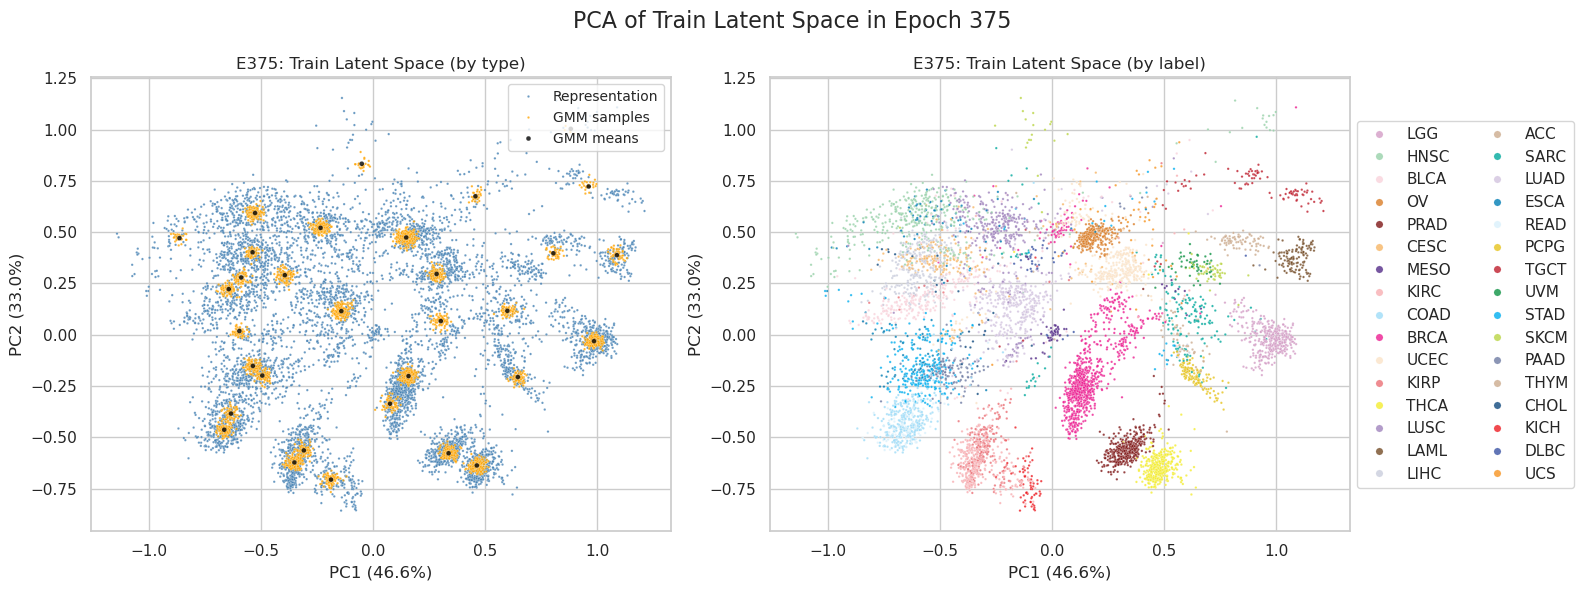

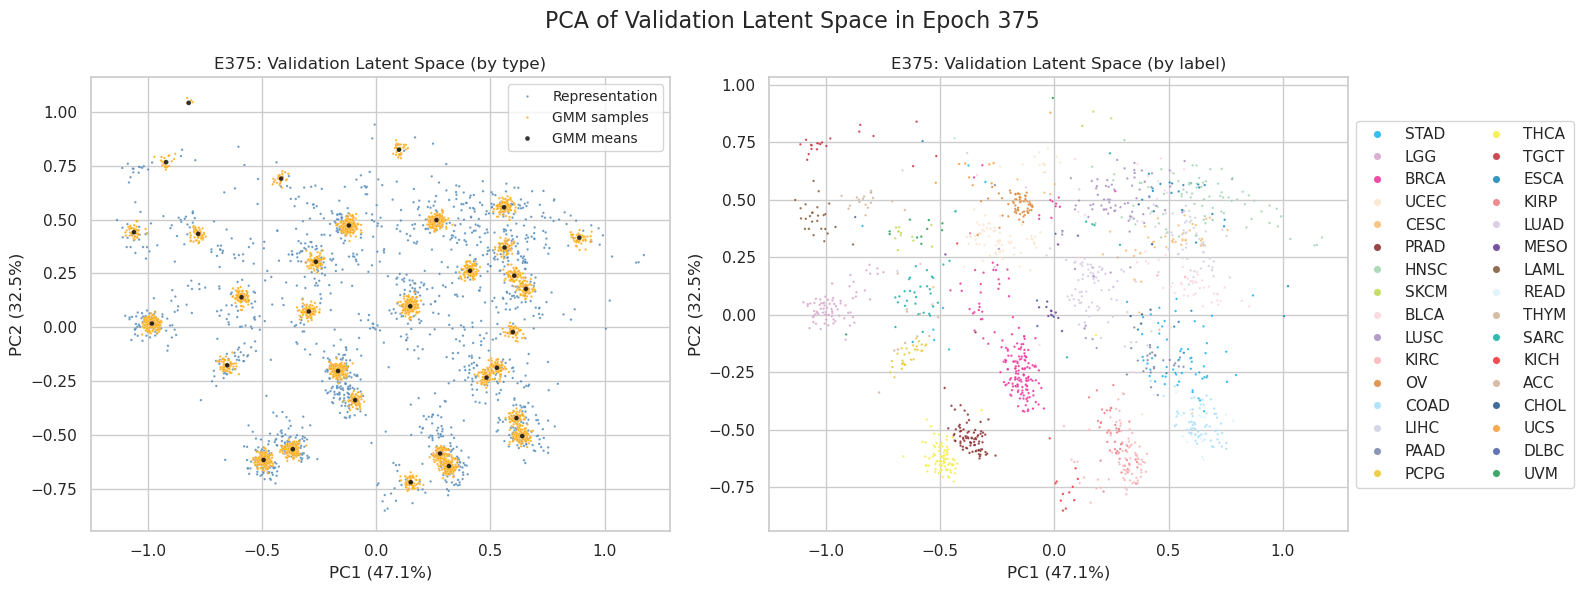

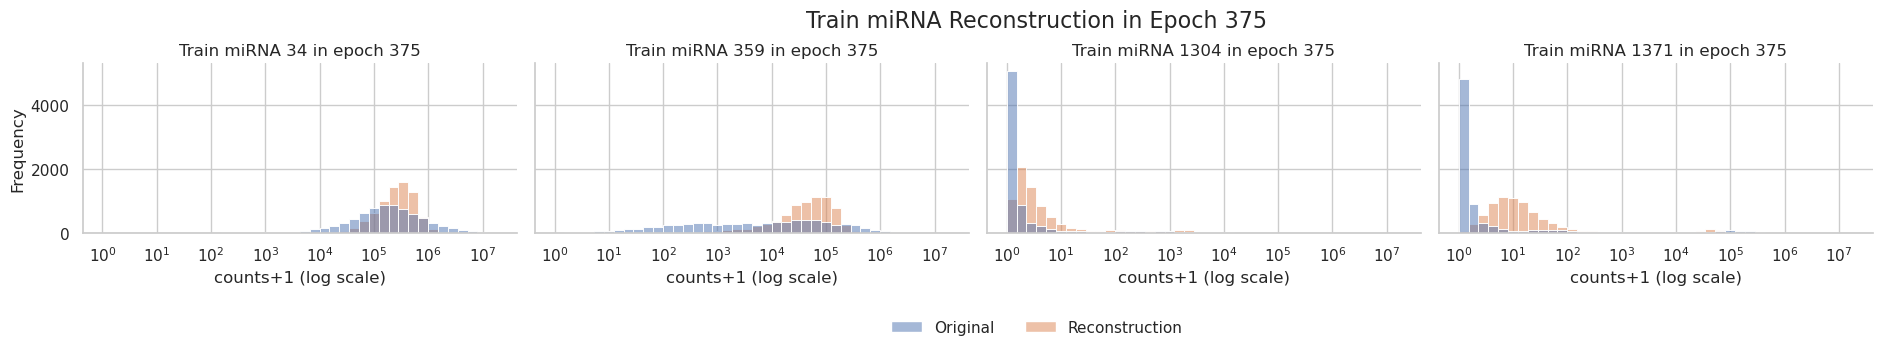

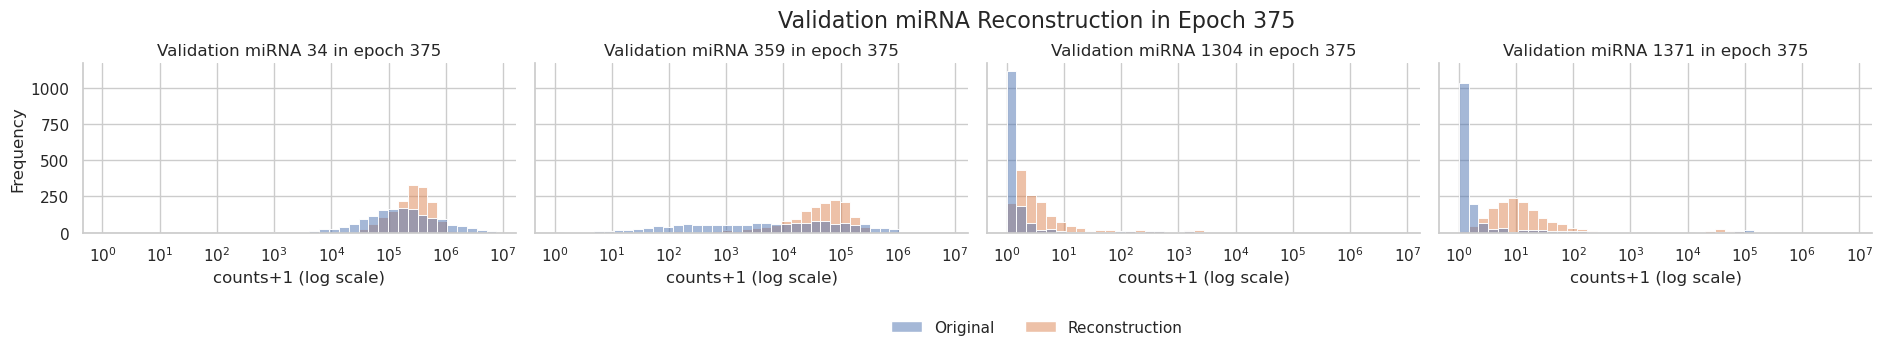

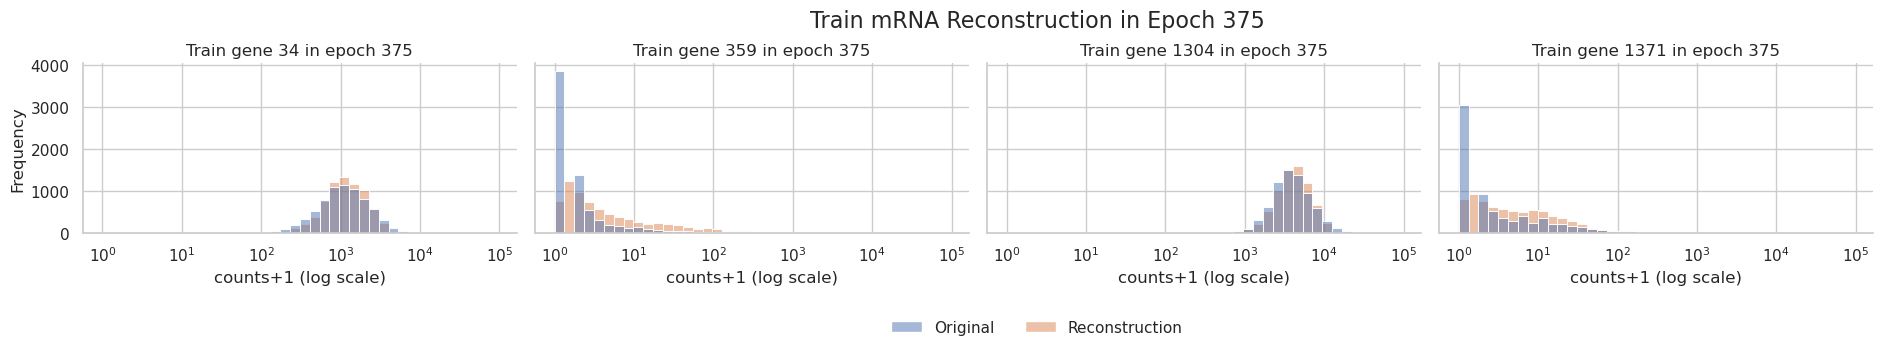

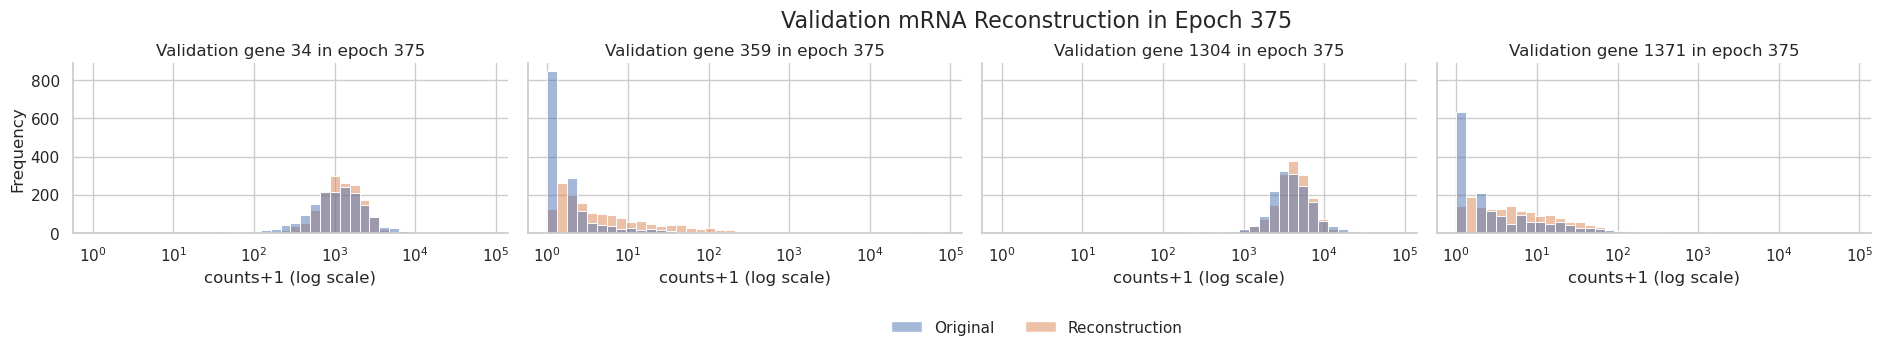

 25%|█████████████████████████████████████████████████████▊                                                                                                                                                              | 381/1500 [21:48<1:12:52,  3.91s/it]

380 train_loss: 10.032953336123867 train_recon_mirna: 1.9327945796765824 train_recon_mrna: 6.4090577734943235 train_gmm: 1.6911009829529615 train_mse: 426633696.0 train_mae: 3279.860107421875 train_r2: 0.48033273220062256 train_spearman: 0.3835744261741638 train_pearson: 0.8968668580055237 train_msle: 5.109384059906006
380 test_loss: 10.071591569961896 test_recon_mirna: 1.9443306118997261 test_recon_mrna: 6.435450659512732 test_gmm: 1.691810298549437 test_mse: 360468960.0 test_mae: 3039.955810546875 test_r2: 0.4943305253982544 test_spearman: 0.36986711621284485 test_pearson: 0.8876704573631287 test_msle: 5.158702373504639


 26%|██████████████████████████████████████████████████████▌                                                                                                                                                             | 386/1500 [22:04<1:01:12,  3.30s/it]

385 train_loss: 10.032597611778682 train_recon_mirna: 1.9290343850687486 train_recon_mrna: 6.4105012575241345 train_gmm: 1.6930619691857989 train_mse: 427497632.0 train_mae: 3288.968505859375 train_r2: 0.47928041219711304 train_spearman: 0.3811904489994049 train_pearson: 0.8982439041137695 train_msle: 5.065783977508545
385 test_loss: 10.080449282746997 test_recon_mirna: 1.9418021514099981 test_recon_mrna: 6.445231548290281 test_gmm: 1.693415583046718 test_mse: 362690208.0 test_mae: 3042.53369140625 test_r2: 0.4912145733833313 test_spearman: 0.37036216259002686 test_pearson: 0.8893340826034546 test_msle: 5.079418182373047


 26%|███████████████████████████████████████████████████████▊                                                                                                                                                              | 391/1500 [22:20<59:29,  3.22s/it]

390 train_loss: 10.03036883500317 train_recon_mirna: 1.9286450840885123 train_recon_mrna: 6.406403241181553 train_gmm: 1.6953205097331034 train_mse: 432160352.0 train_mae: 3311.41943359375 train_r2: 0.47360092401504517 train_spearman: 0.38533350825309753 train_pearson: 0.8997411727905273 train_msle: 5.122200965881348
390 test_loss: 10.067446973173016 test_recon_mirna: 1.941333759595517 test_recon_mrna: 6.4320760084972965 test_gmm: 1.694037205080203 test_mse: 368179200.0 test_mae: 3071.7099609375 test_r2: 0.48351454734802246 test_spearman: 0.3750699758529663 test_pearson: 0.8884240388870239 test_msle: 5.139500617980957


 26%|████████████████████████████████████████████████████████▍                                                                                                                                                             | 396/1500 [22:36<57:56,  3.15s/it]

395 train_loss: 10.025216388251607 train_recon_mirna: 1.9230076179861733 train_recon_mrna: 6.406619372956734 train_gmm: 1.6955893973087 train_mse: 429402848.0 train_mae: 3291.441650390625 train_r2: 0.476959764957428 train_spearman: 0.38810643553733826 train_pearson: 0.9012795090675354 train_msle: 4.984652996063232
395 test_loss: 10.069470545075484 test_recon_mirna: 1.9287096977042717 test_recon_mrna: 6.446817298317503 test_gmm: 1.6939435490537076 test_mse: 364389760.0 test_mae: 3044.383056640625 test_r2: 0.48883044719696045 test_spearman: 0.3791877031326294 test_pearson: 0.8904130458831787 test_msle: 4.951231956481934


 27%|█████████████████████████████████████████████████████████▏                                                                                                                                                            | 401/1500 [22:52<57:40,  3.15s/it]

400 train_loss: 10.025352823055561 train_recon_mirna: 1.9239023148720786 train_recon_mrna: 6.403137158118459 train_gmm: 1.6983133500650234 train_mse: 430819968.0 train_mae: 3295.515380859375 train_r2: 0.4752335548400879 train_spearman: 0.38747352361679077 train_pearson: 0.9016740918159485 train_msle: 4.839698791503906
400 test_loss: 10.057806765080922 test_recon_mirna: 1.926058532573359 test_recon_mrna: 6.433854304004083 test_gmm: 1.69789392850348 test_mse: 365564960.0 test_mae: 3056.636474609375 test_r2: 0.4871818423271179 test_spearman: 0.37961727380752563 test_pearson: 0.8904138207435608 test_msle: 4.85311222076416


 27%|█████████████████████████████████████████████████████████▉                                                                                                                                                            | 406/1500 [23:07<57:04,  3.13s/it]

405 train_loss: 10.019992360146416 train_recon_mirna: 1.9212916758894658 train_recon_mrna: 6.39996378668293 train_gmm: 1.6987368975740205 train_mse: 436209152.0 train_mae: 3333.055419921875 train_r2: 0.46866917610168457 train_spearman: 0.391530841588974 train_pearson: 0.9023190140724182 train_msle: 5.1151814460754395
405 test_loss: 10.043135731404623 test_recon_mirna: 1.9186769695063657 test_recon_mrna: 6.4270799704021435 test_gmm: 1.6973787914961136 test_mse: 368549280.0 test_mae: 3068.519287109375 test_r2: 0.4829953908920288 test_spearman: 0.38687512278556824 test_pearson: 0.8912116885185242 test_msle: 5.146172046661377


 27%|██████████████████████████████████████████████████████████▋                                                                                                                                                           | 411/1500 [23:23<55:40,  3.07s/it]

410 train_loss: 10.013523031139869 train_recon_mirna: 1.917368598011484 train_recon_mrna: 6.396353512585134 train_gmm: 1.6998009205432496 train_mse: 428937728.0 train_mae: 3295.15234375 train_r2: 0.47752630710601807 train_spearman: 0.3935878872871399 train_pearson: 0.9014049768447876 train_msle: 4.732640743255615
410 test_loss: 10.055176100782536 test_recon_mirna: 1.9269339086681538 test_recon_mrna: 6.4261572935180284 test_gmm: 1.7020848985963544 test_mse: 362032448.0 test_mae: 3042.6748046875 test_r2: 0.49213725328445435 test_spearman: 0.38599893450737 test_pearson: 0.8870401382446289 test_msle: 4.8721923828125


 28%|███████████████████████████████████████████████████████████▎                                                                                                                                                          | 416/1500 [23:38<56:33,  3.13s/it]

415 train_loss: 10.010145360239312 train_recon_mirna: 1.9148246205831114 train_recon_mrna: 6.393807911138962 train_gmm: 1.7015128285172387 train_mse: 435907328.0 train_mae: 3331.864013671875 train_r2: 0.46903687715530396 train_spearman: 0.3973004221916199 train_pearson: 0.9045644402503967 train_msle: 4.679646968841553
415 test_loss: 10.06512048807904 test_recon_mirna: 1.9286195791111345 test_recon_mrna: 6.431198124950884 test_gmm: 1.7053027840170234 test_mse: 370094176.0 test_mae: 3067.1806640625 test_r2: 0.4808281660079956 test_spearman: 0.3910248577594757 test_pearson: 0.8903168439865112 test_msle: 4.687675952911377


 28%|████████████████████████████████████████████████████████████                                                                                                                                                          | 421/1500 [23:54<56:49,  3.16s/it]

420 train_loss: 10.011229823082939 train_recon_mirna: 1.9122483131402814 train_recon_mrna: 6.395409675735681 train_gmm: 1.703571834206977 train_mse: 427046464.0 train_mae: 3293.484130859375 train_r2: 0.47982996702194214 train_spearman: 0.39575275778770447 train_pearson: 0.90488600730896 train_msle: 4.873591899871826
420 test_loss: 10.055095596963994 test_recon_mirna: 1.9251027052804577 test_recon_mrna: 6.4242740959666955 test_gmm: 1.70571879571684 test_mse: 366508064.0 test_mae: 3051.518798828125 test_r2: 0.4858587980270386 test_spearman: 0.3917153477668762 test_pearson: 0.8869461417198181 test_msle: 4.850528717041016


 28%|████████████████████████████████████████████████████████████▊                                                                                                                                                         | 426/1500 [24:10<57:29,  3.21s/it]

425 train_loss: 10.008340554087896 train_recon_mirna: 1.9110476540539179 train_recon_mrna: 6.390677633310671 train_gmm: 1.7066152667233079 train_mse: 425420000.0 train_mae: 3279.402587890625 train_r2: 0.4818111062049866 train_spearman: 0.3916134536266327 train_pearson: 0.904435396194458 train_msle: 4.827218055725098
425 test_loss: 10.055715744453286 test_recon_mirna: 1.9224546220709098 test_recon_mrna: 6.430915992795914 test_gmm: 1.7023451295864611 test_mse: 359766560.0 test_mae: 3014.509765625 test_r2: 0.49531590938568115 test_spearman: 0.38956910371780396 test_pearson: 0.8889659643173218 test_msle: 4.791191577911377


 29%|█████████████████████████████████████████████████████████████▍                                                                                                                                                        | 431/1500 [24:26<56:52,  3.19s/it]

430 train_loss: 9.996613227269783 train_recon_mirna: 1.906340094465797 train_recon_mrna: 6.382933020813005 train_gmm: 1.7073401119909808 train_mse: 431662464.0 train_mae: 3310.468994140625 train_r2: 0.47420740127563477 train_spearman: 0.3937969207763672 train_pearson: 0.9045430421829224 train_msle: 4.618114948272705
430 test_loss: 10.065324933327895 test_recon_mirna: 1.9255595323606964 test_recon_mrna: 6.431058573942174 test_gmm: 1.7087068270250252 test_mse: 364798208.0 test_mae: 3041.2294921875 test_r2: 0.48825740814208984 test_spearman: 0.3895934820175171 test_pearson: 0.8880578875541687 test_msle: 4.5948662757873535


 29%|██████████████████████████████████████████████████████████████▏                                                                                                                                                       | 436/1500 [24:42<55:50,  3.15s/it]

435 train_loss: 10.00063010788038 train_recon_mirna: 1.905825114912519 train_recon_mrna: 6.385476193256901 train_gmm: 1.7093287997109592 train_mse: 433529152.0 train_mae: 3316.951416015625 train_r2: 0.47193366289138794 train_spearman: 0.4006570875644684 train_pearson: 0.9054640531539917 train_msle: 4.316746711730957
435 test_loss: 10.046326218784346 test_recon_mirna: 1.9182115893414269 test_recon_mrna: 6.417712036674677 test_gmm: 1.7104025927682425 test_mse: 367260544.0 test_mae: 3055.721923828125 test_r2: 0.4848032593727112 test_spearman: 0.39587196707725525 test_pearson: 0.8879412412643433 test_msle: 4.334980487823486


 29%|██████████████████████████████████████████████████████████████▉                                                                                                                                                       | 441/1500 [24:58<54:52,  3.11s/it]

440 train_loss: 9.996827948252479 train_recon_mirna: 1.9031865255972105 train_recon_mrna: 6.382683250180724 train_gmm: 1.710958172474545 train_mse: 434184416.0 train_mae: 3322.266845703125 train_r2: 0.4711354970932007 train_spearman: 0.3947201669216156 train_pearson: 0.9058588743209839 train_msle: 4.693120002746582
440 test_loss: 10.049079632556422 test_recon_mirna: 1.9171068259398274 test_recon_mrna: 6.420403655162706 test_gmm: 1.7115691514538878 test_mse: 373703456.0 test_mae: 3085.038330078125 test_r2: 0.4757651090621948 test_spearman: 0.3913742005825043 test_pearson: 0.8860090374946594 test_msle: 4.725355625152588


 30%|███████████████████████████████████████████████████████████████▋                                                                                                                                                      | 446/1500 [25:14<55:39,  3.17s/it]

445 train_loss: 9.984975022875478 train_recon_mirna: 1.8989416992948296 train_recon_mrna: 6.374848122043017 train_gmm: 1.7111852015376312 train_mse: 439952736.0 train_mae: 3350.218994140625 train_r2: 0.46410930156707764 train_spearman: 0.40665289759635925 train_pearson: 0.9070076942443848 train_msle: 4.037921905517578
445 test_loss: 10.030455343440368 test_recon_mirna: 1.907003032851555 test_recon_mrna: 6.410587228141494 test_gmm: 1.7128650824473195 test_mse: 375347936.0 test_mae: 3090.64013671875 test_r2: 0.4734581708908081 test_spearman: 0.4022432267665863 test_pearson: 0.8891661763191223 test_msle: 4.070949554443359


 30%|████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 450/1500 [25:26<56:04,  3.20s/it]

450 train_loss: 9.986740737916074 train_recon_mirna: 1.8979947755109856 train_recon_mrna: 6.3763613551556215 train_gmm: 1.7123846072494662 train_mse: 429741248.0 train_mae: 3295.91455078125 train_r2: 0.4765475392341614 train_spearman: 0.40586575865745544 train_pearson: 0.9077869057655334 train_msle: 4.237071990966797
450 test_loss: 10.043603316954542 test_recon_mirna: 1.9191262473850852 test_recon_mrna: 6.412267637030889 test_gmm: 1.7122094325385684 test_mse: 370449216.0 test_mae: 3051.606689453125 test_r2: 0.48033010959625244 test_spearman: 0.4062923192977905 test_pearson: 0.8868198394775391 test_msle: 4.250755310058594


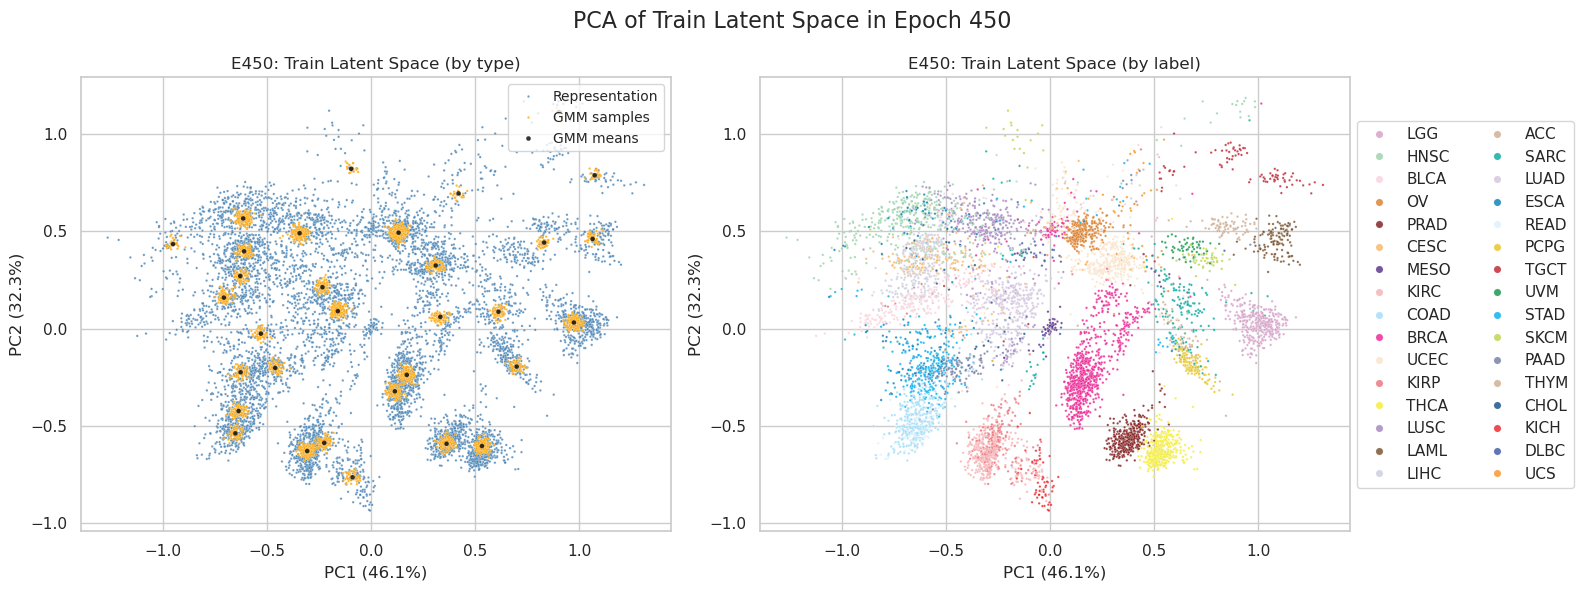

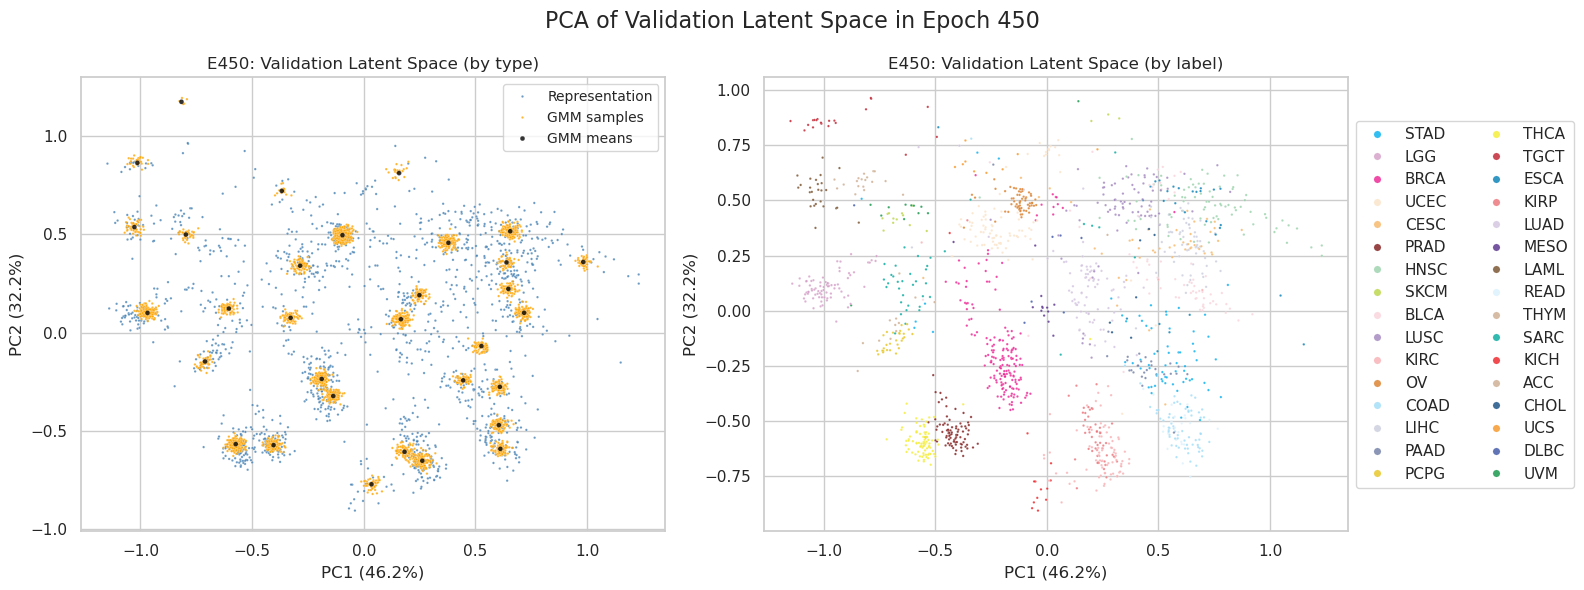

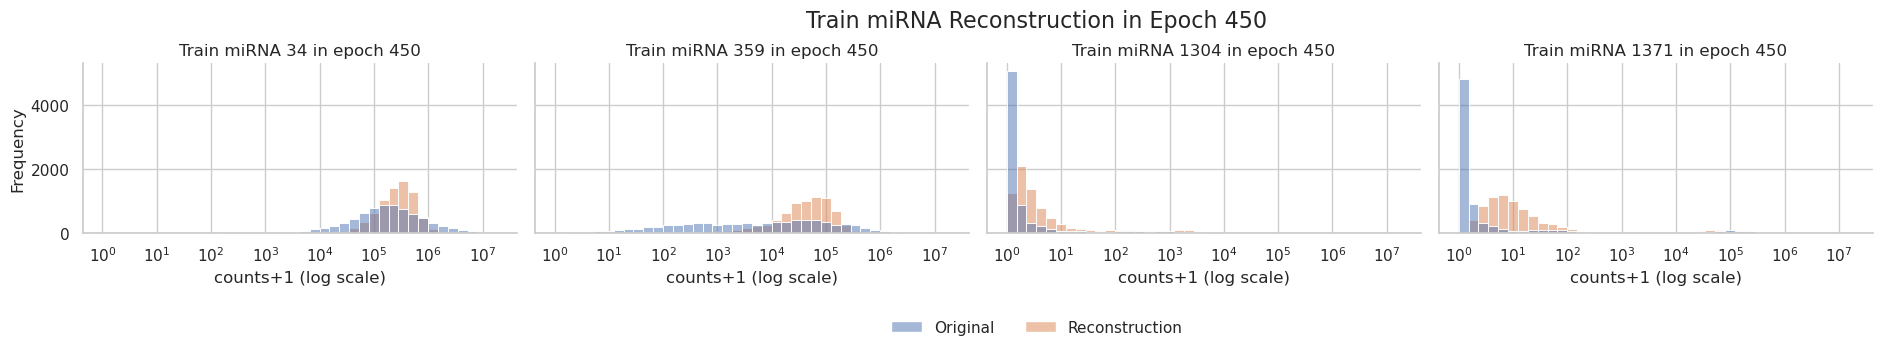

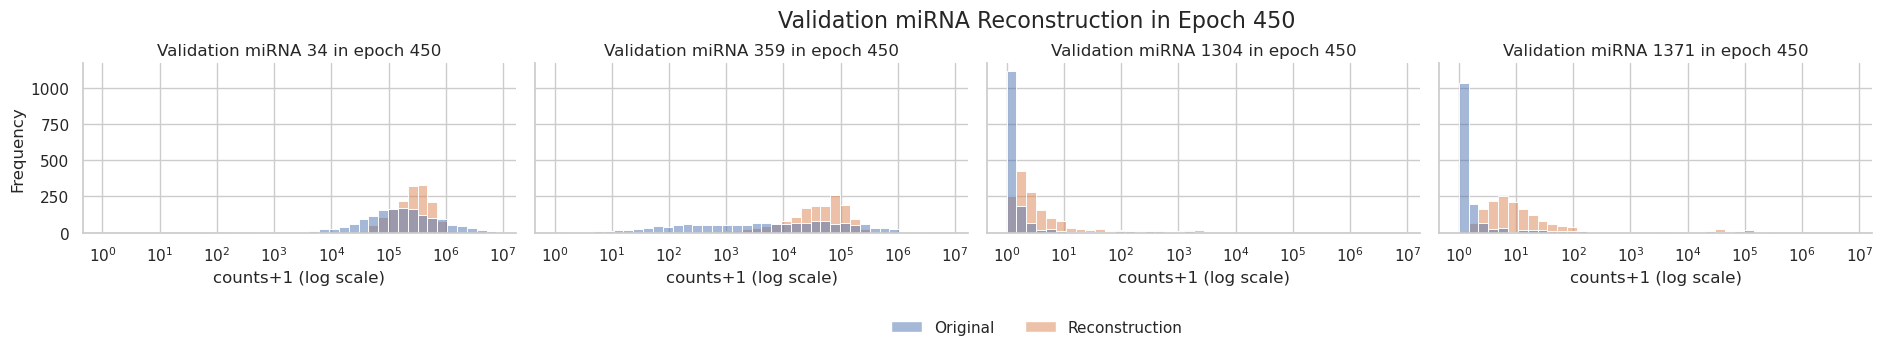

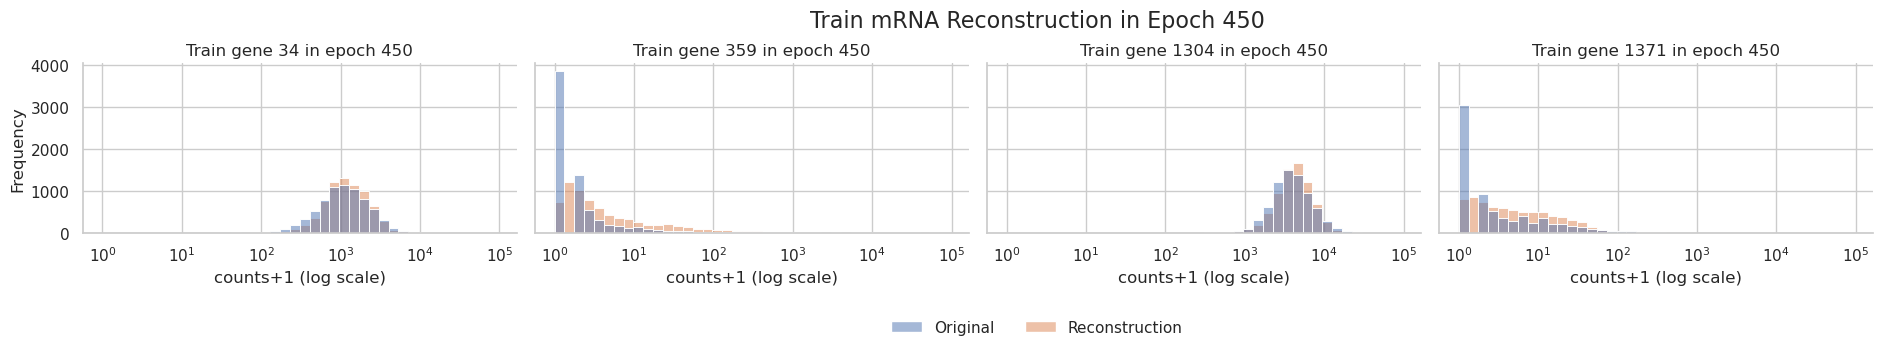

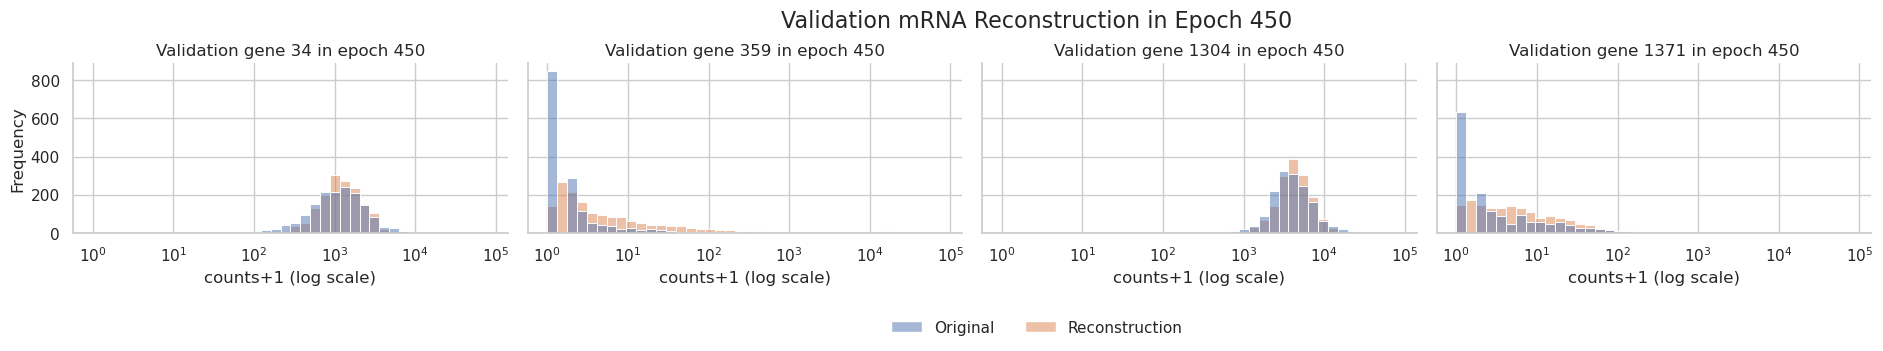

 30%|████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 456/1500 [26:01<1:07:53,  3.90s/it]

455 train_loss: 9.988626515246175 train_recon_mirna: 1.8967107195360442 train_recon_mrna: 6.377837221175076 train_gmm: 1.7140785745350555 train_mse: 424566208.0 train_mae: 3269.964599609375 train_r2: 0.4828510880470276 train_spearman: 0.4045525789260864 train_pearson: 0.9035268425941467 train_msle: 4.407306671142578
455 test_loss: 10.040869872191626 test_recon_mirna: 1.9084938997633085 test_recon_mrna: 6.4184014917762395 test_gmm: 1.7139744806520791 test_mse: 362262304.0 test_mae: 3017.451171875 test_r2: 0.49181485176086426 test_spearman: 0.4000173509120941 test_pearson: 0.8848294615745544 test_msle: 4.460329532623291


 31%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 461/1500 [26:17<58:38,  3.39s/it]

460 train_loss: 9.981679296026266 train_recon_mirna: 1.893861343777789 train_recon_mrna: 6.372504452594186 train_gmm: 1.7153134996542914 train_mse: 432854720.0 train_mae: 3301.568115234375 train_r2: 0.4727551341056824 train_spearman: 0.40369853377342224 train_pearson: 0.9032317399978638 train_msle: 4.252774715423584
460 test_loss: 10.03537913365984 test_recon_mirna: 1.9163268689413642 test_recon_mrna: 6.403212268579009 test_gmm: 1.7158399961394668 test_mse: 370561856.0 test_mae: 3065.568359375 test_r2: 0.48017215728759766 test_spearman: 0.4021749794483185 test_pearson: 0.8811789751052856 test_msle: 4.279263019561768


 31%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 466/1500 [26:33<54:22,  3.16s/it]

465 train_loss: 9.978654972414848 train_recon_mirna: 1.8917214118995527 train_recon_mrna: 6.369019759326264 train_gmm: 1.7179138011890318 train_mse: 440230240.0 train_mae: 3345.463623046875 train_r2: 0.4637712836265564 train_spearman: 0.40529558062553406 train_pearson: 0.9069476127624512 train_msle: 4.4645233154296875
465 test_loss: 10.024113110468543 test_recon_mirna: 1.8984494261321876 test_recon_mrna: 6.409314208071246 test_gmm: 1.7163494762651097 test_mse: 375002176.0 test_mae: 3091.85693359375 test_r2: 0.47394317388534546 test_spearman: 0.4056072533130646 test_pearson: 0.8819726705551147 test_msle: 4.547301769256592


 31%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 471/1500 [26:49<55:36,  3.24s/it]

470 train_loss: 9.980904725938462 train_recon_mirna: 1.8891738467908379 train_recon_mrna: 6.372429859628947 train_gmm: 1.719301019518677 train_mse: 426170176.0 train_mae: 3270.91748046875 train_r2: 0.48089730739593506 train_spearman: 0.40448105335235596 train_pearson: 0.9031252861022949 train_msle: 4.1841630935668945
470 test_loss: 10.030866853700077 test_recon_mirna: 1.9042755625600725 test_recon_mrna: 6.4087271847934 test_gmm: 1.7178641063466056 test_mse: 364464992.0 test_mae: 3036.261474609375 test_r2: 0.48872488737106323 test_spearman: 0.40322667360305786 test_pearson: 0.879209041595459 test_msle: 4.245875835418701


 32%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 476/1500 [27:05<54:46,  3.21s/it]

475 train_loss: 9.968605792959604 train_recon_mirna: 1.8861409742037563 train_recon_mrna: 6.363064149371099 train_gmm: 1.7194006693847494 train_mse: 438064000.0 train_mae: 3327.84033203125 train_r2: 0.4664098620414734 train_spearman: 0.4088444411754608 train_pearson: 0.9053881168365479 train_msle: 4.1141676902771
475 test_loss: 10.026464933427956 test_recon_mirna: 1.8941756444608777 test_recon_mrna: 6.417924772092486 test_gmm: 1.7143645168745936 test_mse: 373399936.0 test_mae: 3074.012939453125 test_r2: 0.47619086503982544 test_spearman: 0.40903303027153015 test_pearson: 0.8813148736953735 test_msle: 4.121268272399902


 32%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 481/1500 [27:21<54:13,  3.19s/it]

480 train_loss: 9.967664541590953 train_recon_mirna: 1.882793141160961 train_recon_mrna: 6.36416272213879 train_gmm: 1.7207086782912016 train_mse: 432040768.0 train_mae: 3299.348876953125 train_r2: 0.4737465977668762 train_spearman: 0.4081224203109741 train_pearson: 0.9044336080551147 train_msle: 4.176234245300293
480 test_loss: 10.036931556979967 test_recon_mirna: 1.9023016170229032 test_recon_mrna: 6.414814829941105 test_gmm: 1.7198151100159593 test_mse: 371657888.0 test_mae: 3053.84912109375 test_r2: 0.4786345958709717 test_spearman: 0.410013347864151 test_pearson: 0.8799046277999878 test_msle: 4.1526079177856445


 32%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 486/1500 [27:37<54:33,  3.23s/it]

485 train_loss: 9.968559330183272 train_recon_mirna: 1.8824473313890961 train_recon_mrna: 6.364875782588875 train_gmm: 1.7212362162052994 train_mse: 428110944.0 train_mae: 3278.450439453125 train_r2: 0.4785333275794983 train_spearman: 0.40704670548439026 train_pearson: 0.9055405259132385 train_msle: 4.272755146026611
485 test_loss: 10.02908722248641 test_recon_mirna: 1.904547434203087 test_recon_mrna: 6.40684306502629 test_gmm: 1.717696723257034 test_mse: 366094208.0 test_mae: 3042.4306640625 test_r2: 0.48643940687179565 test_spearman: 0.4059804677963257 test_pearson: 0.8794945478439331 test_msle: 4.378310680389404


 33%|██████████████████████████████████████████████████████████████████████                                                                                                                                                | 491/1500 [27:53<53:52,  3.20s/it]

490 train_loss: 9.962804329388105 train_recon_mirna: 1.8796152569879319 train_recon_mrna: 6.360585917432818 train_gmm: 1.7226031549673537 train_mse: 434016320.0 train_mae: 3302.926025390625 train_r2: 0.47134023904800415 train_spearman: 0.41017863154411316 train_pearson: 0.9051306247711182 train_msle: 4.1151204109191895
490 test_loss: 10.01124200872171 test_recon_mirna: 1.8931482603748515 test_recon_mrna: 6.398095222599504 test_gmm: 1.719998525747355 test_mse: 373122880.0 test_mae: 3069.341064453125 test_r2: 0.47657954692840576 test_spearman: 0.41473913192749023 test_pearson: 0.8785227537155151 test_msle: 4.075290679931641


 33%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 496/1500 [28:09<53:11,  3.18s/it]

495 train_loss: 9.963739881210564 train_recon_mirna: 1.8776543884523162 train_recon_mrna: 6.363915401691944 train_gmm: 1.7221700910663031 train_mse: 429288448.0 train_mae: 3284.15283203125 train_r2: 0.47709912061691284 train_spearman: 0.4062875211238861 train_pearson: 0.9037619829177856 train_msle: 4.146481513977051
495 test_loss: 10.025600742850198 test_recon_mirna: 1.9019776839981342 test_recon_mrna: 6.402833435512646 test_gmm: 1.7207896233394167 test_mse: 367504736.0 test_mae: 3040.452880859375 test_r2: 0.48446065187454224 test_spearman: 0.4078691303730011 test_pearson: 0.8776243925094604 test_msle: 4.197024822235107


 33%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 501/1500 [28:26<54:06,  3.25s/it]

500 train_loss: 9.958293007597888 train_recon_mirna: 1.8780325863474383 train_recon_mrna: 6.356994503407925 train_gmm: 1.7232659178425247 train_mse: 421413920.0 train_mae: 3242.494140625 train_r2: 0.4866907596588135 train_spearman: 0.40625548362731934 train_pearson: 0.9023707509040833 train_msle: 3.932415246963501
500 test_loss: 10.004148391555244 test_recon_mirna: 1.8876461071658948 test_recon_mrna: 6.398999092869039 test_gmm: 1.7175031915203112 test_mse: 362775936.0 test_mae: 3038.302001953125 test_r2: 0.49109429121017456 test_spearman: 0.4064452350139618 test_pearson: 0.876022219657898 test_msle: 3.979471206665039


 34%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 506/1500 [28:42<53:31,  3.23s/it]

505 train_loss: 9.967184754923117 train_recon_mirna: 1.8799006852602889 train_recon_mrna: 6.362376762910186 train_gmm: 1.7249073067526437 train_mse: 427025536.0 train_mae: 3274.324951171875 train_r2: 0.479855477809906 train_spearman: 0.40937095880508423 train_pearson: 0.905247688293457 train_msle: 3.965287208557129
505 test_loss: 10.021950289928961 test_recon_mirna: 1.8972986547644135 test_recon_mrna: 6.402426376056274 test_gmm: 1.7222252591082723 test_mse: 371739456.0 test_mae: 3073.34912109375 test_r2: 0.4785202145576477 test_spearman: 0.40703344345092773 test_pearson: 0.8755022287368774 test_msle: 4.017270088195801


 34%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 511/1500 [28:58<52:36,  3.19s/it]

510 train_loss: 9.959620853711632 train_recon_mirna: 1.8755989596820315 train_recon_mrna: 6.359446531778051 train_gmm: 1.7245753622515492 train_mse: 425578016.0 train_mae: 3262.0185546875 train_r2: 0.48161864280700684 train_spearman: 0.4076463282108307 train_pearson: 0.9024346470832825 train_msle: 4.095937252044678
510 test_loss: 10.021352695883458 test_recon_mirna: 1.9044035777432835 test_recon_mrna: 6.39598081237856 test_gmm: 1.7209683057616147 test_mse: 362534848.0 test_mae: 3020.126220703125 test_r2: 0.4914324879646301 test_spearman: 0.40985819697380066 test_pearson: 0.8767032623291016 test_msle: 4.103043556213379


 34%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 516/1500 [29:14<52:21,  3.19s/it]

515 train_loss: 9.948818043440557 train_recon_mirna: 1.8691369469281915 train_recon_mrna: 6.354267948353255 train_gmm: 1.7254131481591115 train_mse: 418250272.0 train_mae: 3228.83447265625 train_r2: 0.49054431915283203 train_spearman: 0.40650078654289246 train_pearson: 0.904377281665802 train_msle: 4.176547527313232
515 test_loss: 10.01052520245303 test_recon_mirna: 1.8918235562071783 test_recon_mrna: 6.3982580595565635 test_gmm: 1.720443586689288 test_mse: 359939008.0 test_mae: 3013.87548828125 test_r2: 0.49507397413253784 test_spearman: 0.4039083421230316 test_pearson: 0.8753266334533691 test_msle: 4.205989360809326


 35%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 521/1500 [29:29<51:34,  3.16s/it]

520 train_loss: 9.954726381045704 train_recon_mirna: 1.86868953930035 train_recon_mrna: 6.359666299995593 train_gmm: 1.7263705417497608 train_mse: 419759968.0 train_mae: 3235.646728515625 train_r2: 0.4887053966522217 train_spearman: 0.41273871064186096 train_pearson: 0.9032357931137085 train_msle: 3.9220447540283203
520 test_loss: 10.035432490548205 test_recon_mirna: 1.9038012980289838 test_recon_mrna: 6.405513262813249 test_gmm: 1.7261179297059714 test_mse: 369044000.0 test_mae: 3053.6865234375 test_r2: 0.48230141401290894 test_spearman: 0.41342103481292725 test_pearson: 0.8750877976417542 test_msle: 3.8809995651245117


 35%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 525/1500 [29:42<51:05,  3.14s/it]

525 train_loss: 9.955939766995652 train_recon_mirna: 1.8697760490299842 train_recon_mrna: 6.358222823026834 train_gmm: 1.7279408949388337 train_mse: 419588192.0 train_mae: 3233.927978515625 train_r2: 0.4889146089553833 train_spearman: 0.4097031354904175 train_pearson: 0.9034817814826965 train_msle: 4.102458953857422
525 test_loss: 10.00596051331158 test_recon_mirna: 1.888521724192653 test_recon_mrna: 6.3927016436322415 test_gmm: 1.7247371454866858 test_mse: 359720640.0 test_mae: 3018.60986328125 test_r2: 0.49538034200668335 test_spearman: 0.4101172685623169 test_pearson: 0.872563362121582 test_msle: 4.076637268066406


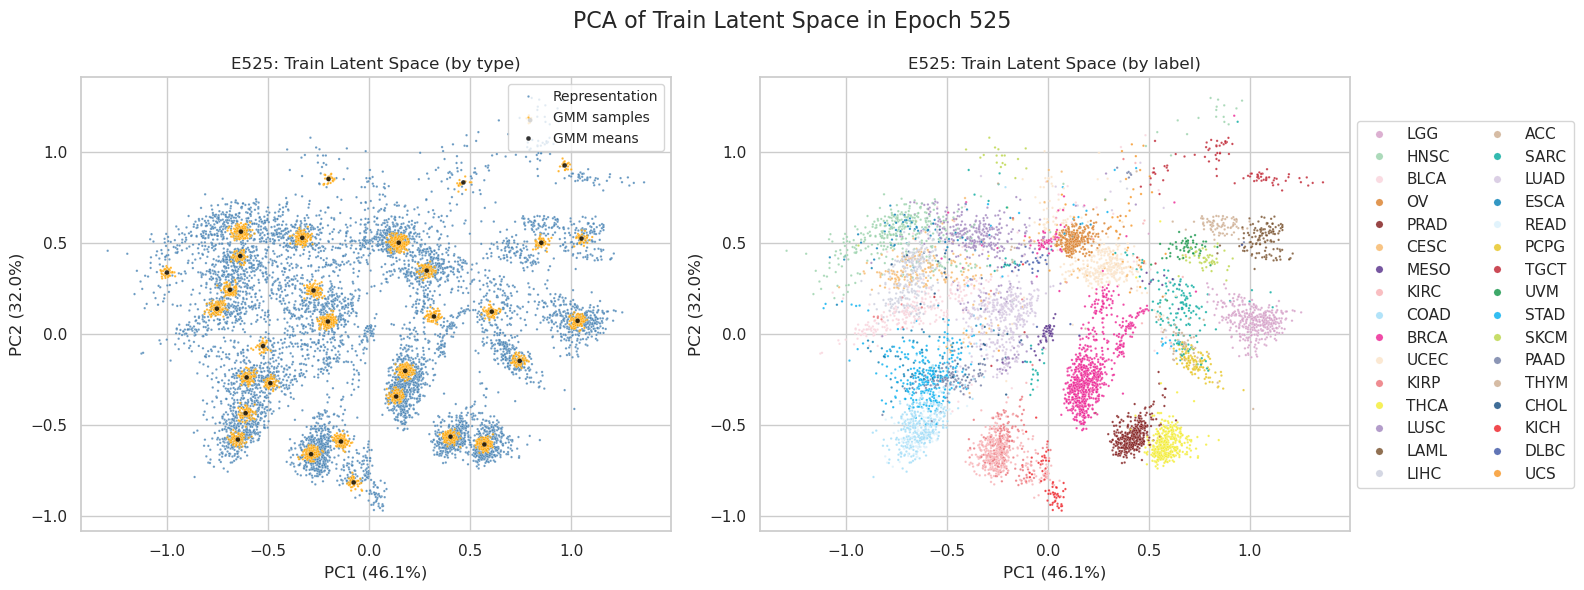

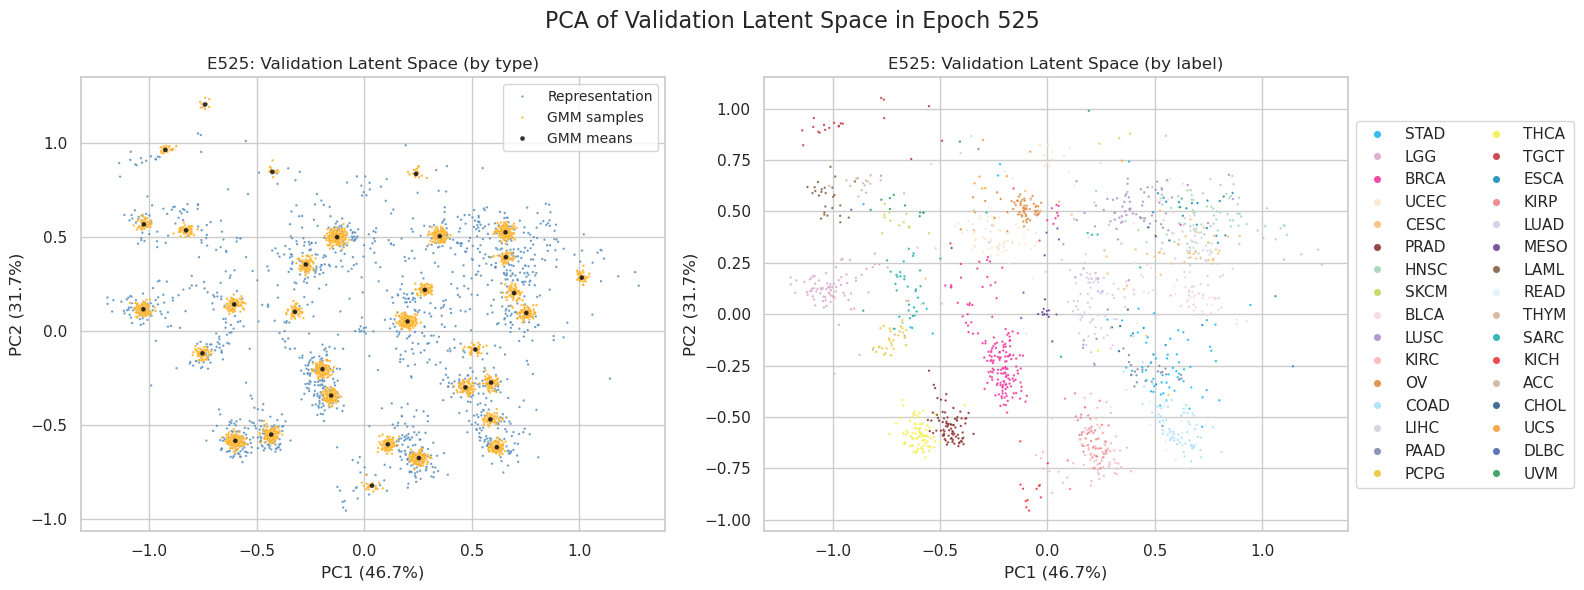

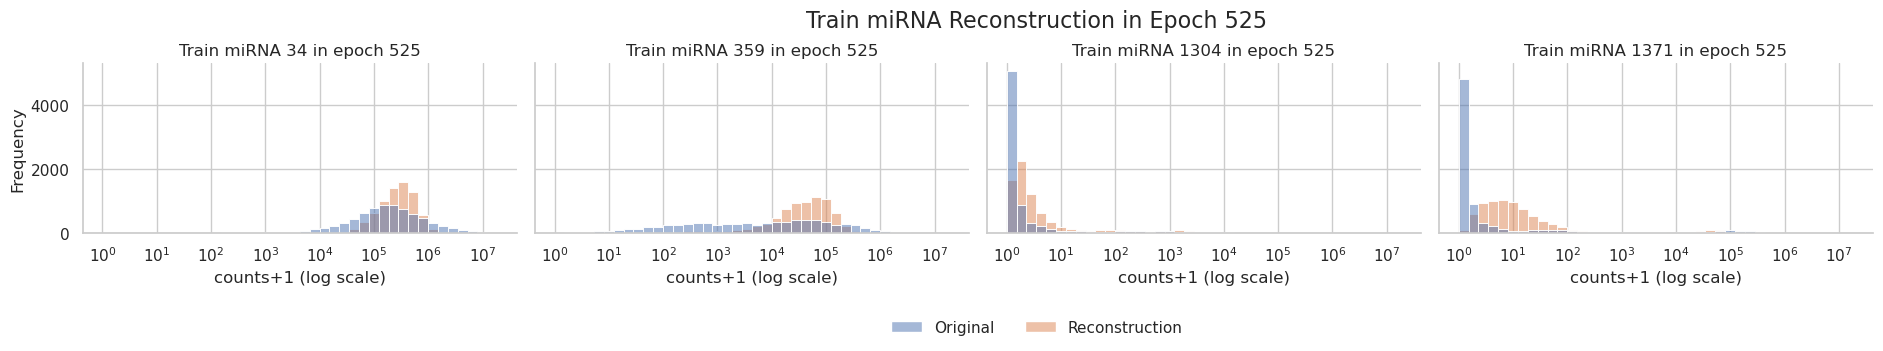

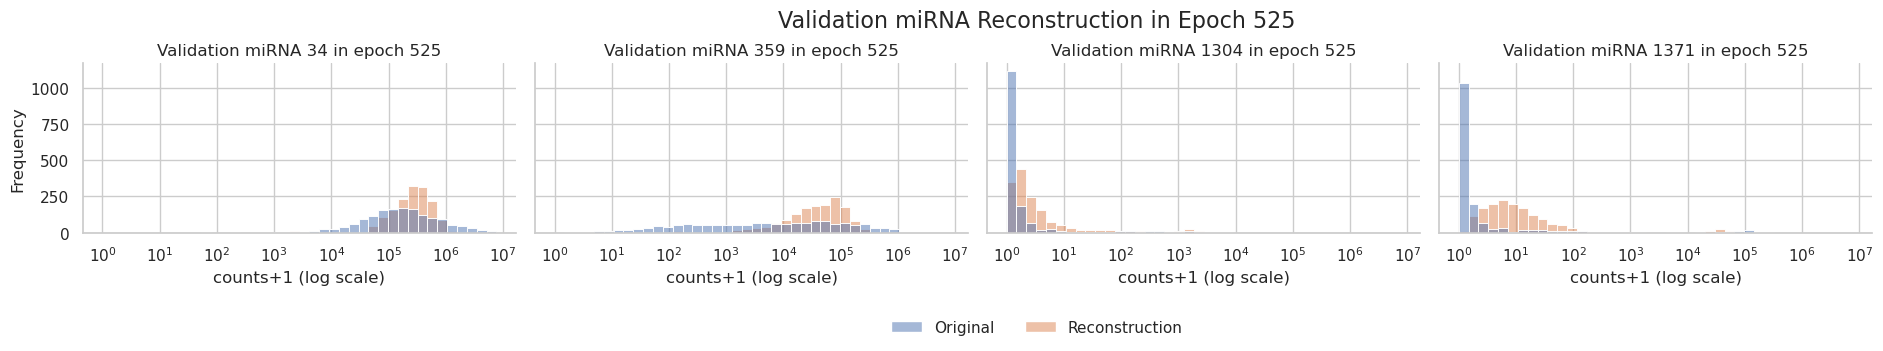

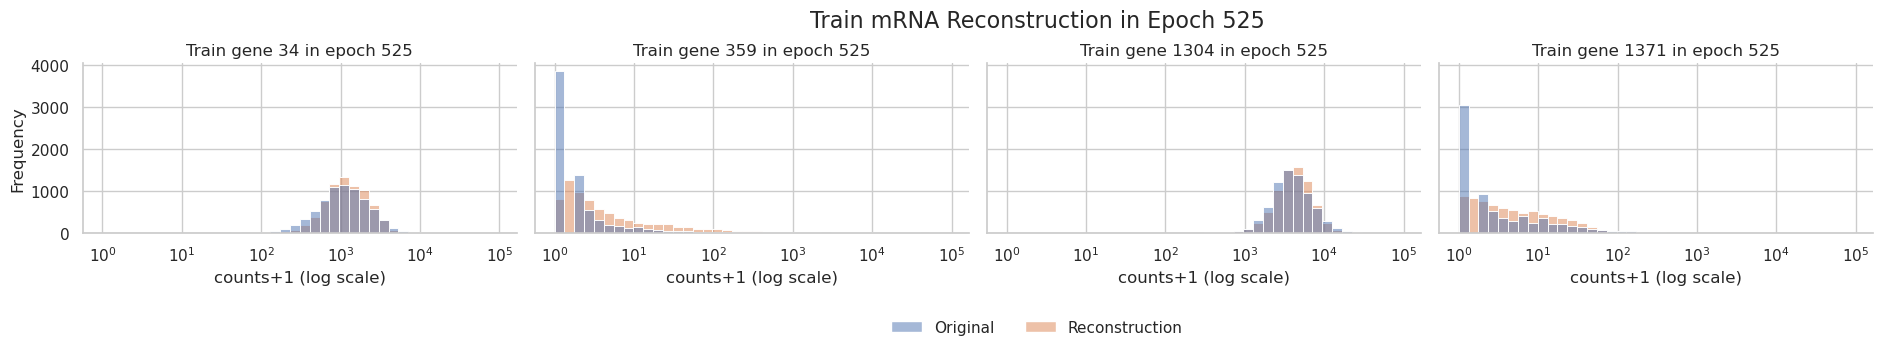

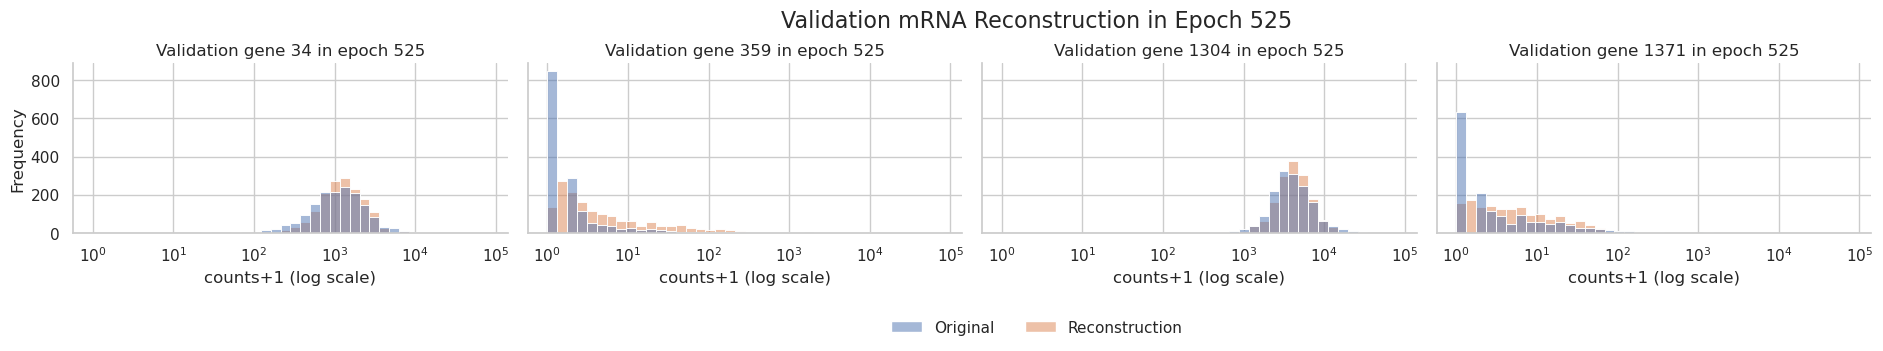

 35%|███████████████████████████████████████████████████████████████████████████                                                                                                                                         | 531/1500 [30:17<1:04:10,  3.97s/it]

530 train_loss: 9.944042861241787 train_recon_mirna: 1.8669545504303804 train_recon_mrna: 6.3494650765043215 train_gmm: 1.7276232343070859 train_mse: 419174240.0 train_mae: 3226.5166015625 train_r2: 0.4894188642501831 train_spearman: 0.41595956683158875 train_pearson: 0.9034658074378967 train_msle: 3.874701976776123
530 test_loss: 10.049814998253089 test_recon_mirna: 1.9091460122387012 test_recon_mrna: 6.411480394120769 test_gmm: 1.7291885918936192 test_mse: 361526656.0 test_mae: 3017.628173828125 test_r2: 0.4928467869758606 test_spearman: 0.4153590500354767 test_pearson: 0.8738174438476562 test_msle: 3.8655989170074463


 36%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 536/1500 [30:34<54:02,  3.36s/it]

535 train_loss: 9.941854689778484 train_recon_mirna: 1.8621393173884393 train_recon_mrna: 6.350165081067174 train_gmm: 1.729550291322872 train_mse: 412836096.0 train_mae: 3199.40185546875 train_r2: 0.4971390962600708 train_spearman: 0.4174177646636963 train_pearson: 0.9024959206581116 train_msle: 4.030070781707764
535 test_loss: 10.010931013221569 test_recon_mirna: 1.8918751658415014 test_recon_mrna: 6.391670112350254 test_gmm: 1.727385735029813 test_mse: 359426656.0 test_mae: 3014.20751953125 test_r2: 0.4957926869392395 test_spearman: 0.4145280718803406 test_pearson: 0.8710331320762634 test_msle: 4.013749122619629


 36%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 539/1500 [30:46<54:52,  3.43s/it]

Early stopped training at epoch 539


In [16]:
learning_rates={'dec':1e-4, 'rep':1e-2, 'gmm':1e-2}
weight_decay={'dec':1e-4, 'rep':1e-4, 'gmm':1e-4}
betas=(0.7, 0.9)
nepochs = 1500
pr = 5 # how often to print epoch
plot = 75 # how often to print plot

sample_mirna = ['MIMAT0000421', 'MIMAT0000422', 'MIMAT0000435', 'MIMAT0000728']
sample_index = [tcga_mirna.columns.get_loc(a) for a in sample_mirna]

print(sample_index)
subset = sample_index[0]

loss_tab = train_midgd(dgd, train_loader, validation_loader, device,
                       learning_rates=learning_rates, weight_decay=weight_decay, betas=betas, 
                       nepochs=nepochs, fold=None, pr=pr, plot=plot, 
                       reduction_type=reduction_type, scaling_type=scaling_type,
                       sample_index=sample_index, subset=subset, wandb_log=False, early_stopping=20, is_plot=True)

# Plotting Loss

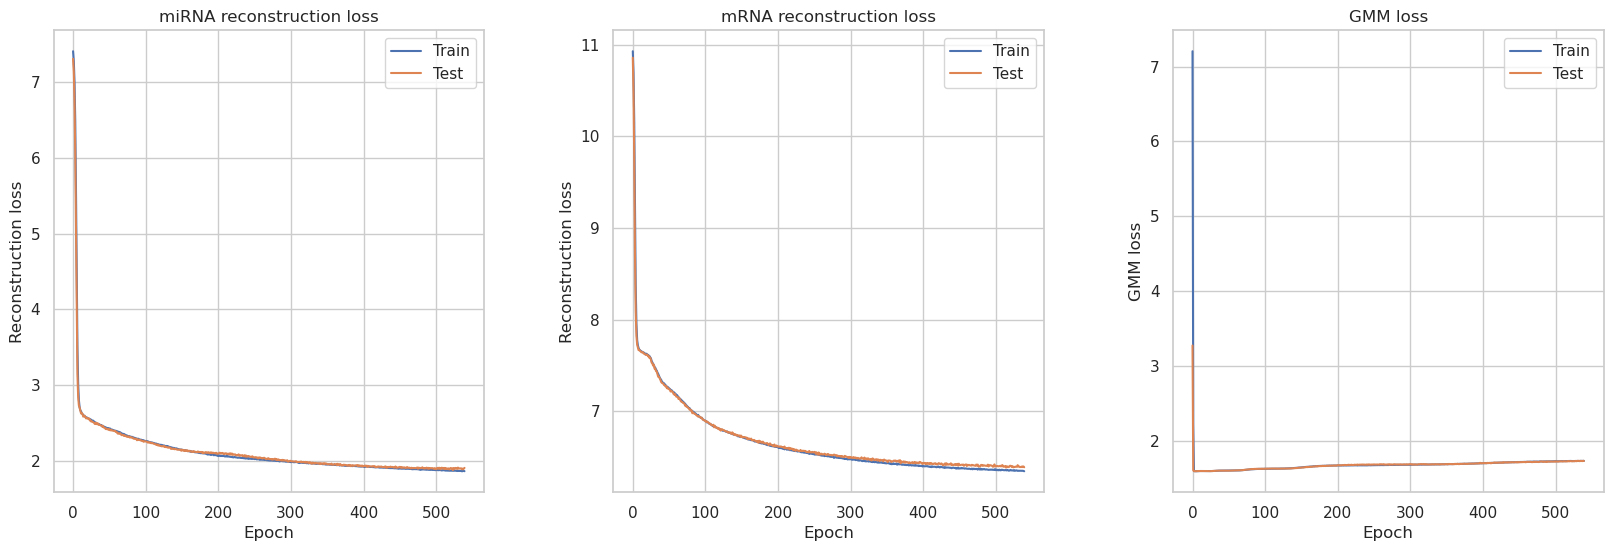

In [17]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon_mirna", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon_mirna", data=loss_tab, label="Test")
plt.title("miRNA reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_recon_mrna", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon_mrna", data=loss_tab, label="Test")
plt.title("mRNA reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Display the plots
plt.show()

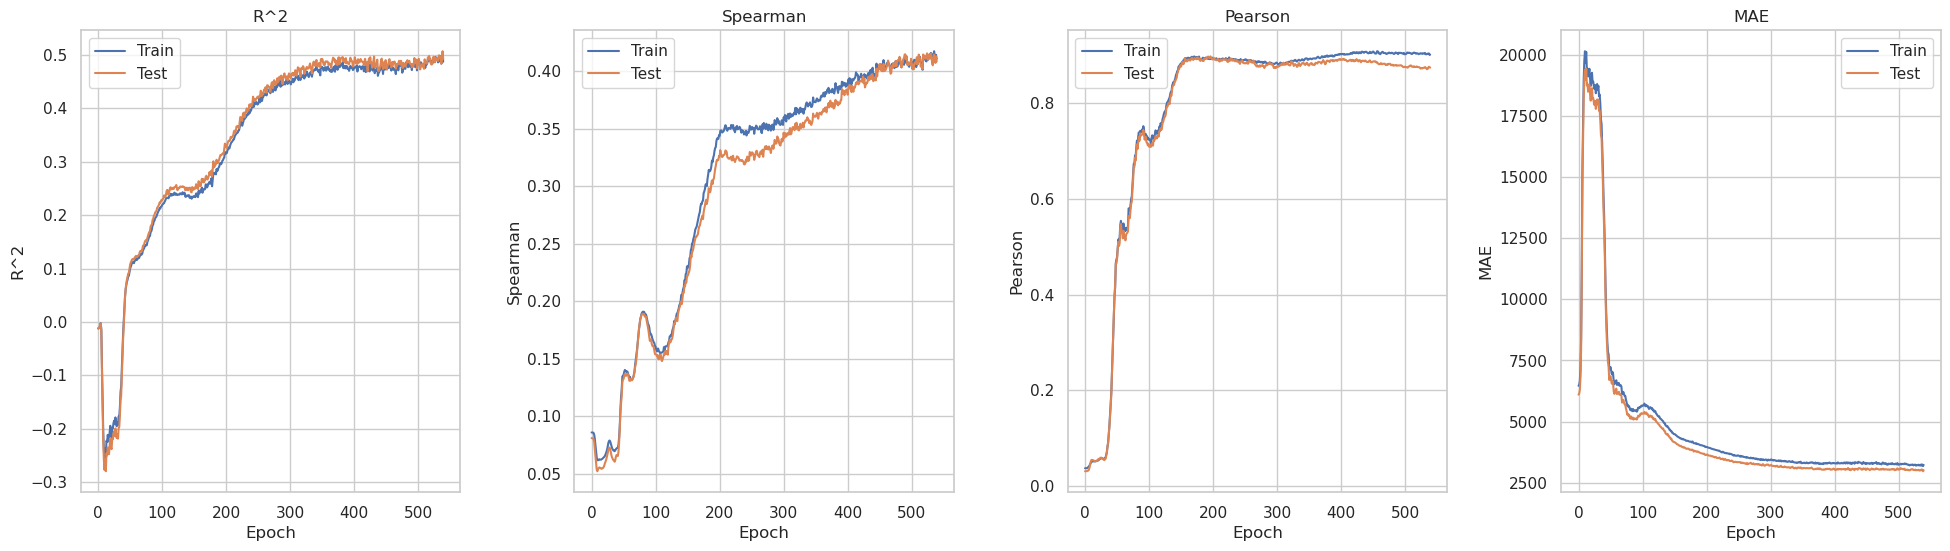

In [18]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for R-squared
plt.subplot(1, 4, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for Corr
plt.subplot(1, 4, 2)
sns.lineplot(x="epoch", y="train_spearman", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_spearman", data=loss_tab, label="Test")
plt.title("Spearman")
plt.xlabel("Epoch")
plt.ylabel("Spearman")

# Third subplot for MSE
plt.subplot(1, 4, 3)
sns.lineplot(x="epoch", y="train_pearson", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_pearson", data=loss_tab, label="Test")
plt.title("Pearson")
plt.xlabel("Epoch")
plt.ylabel("Pearson")

# Fourth subplot for MAE
plt.subplot(1, 4, 4)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Display the plots
plt.show()

# Save Model

In [ ]:
torch.save(dgd, "models/midgd-ms-filtered-best.pth")

# Overall Model Performance

In [20]:
from base.engine.predict import learn_new_representation #, learn_new_representation_mrna

In [21]:
new_rep = learn_new_representation(dgd, test_loader, learning_rates=1e-2, weight_decay=0., test_epochs=50)
dgd.test_rep = new_rep

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:04<00:00,  1.29s/it]


In [22]:
mirna_annot = pd.read_table("data/TCGA_mirna_anno_iso_match.tsv", sep='\t', index_col=[0])

# Change column name
mirna_column = pd.Series(train_mirna.columns[:-4])

# Convert mirna_annot DataFrame to a dictionary for mapping
mapping_dict = dict(zip(mirna_annot['mature_iso_id'], mirna_annot['mature_iso_name_miRBase']))

# Replace the values in mirna_column using the mapping dictionary
mirna_column = mirna_column.map(mapping_dict).fillna(mirna_column)
mirna_column = np.array(mirna_column)

print(mirna_column)

def _add_columns(X, y, data_loader):
    X = X.assign(tissue=data_loader.dataset.tissue_type)
    X = X.assign(sample=data_loader.dataset.sample_type)
    X = X.assign(color=data_loader.dataset.color)
    X = X.assign(cancer_type=data_loader.dataset.label)
    
    y = y.assign(tissue=data_loader.dataset.tissue_type)
    y = y.assign(sample=data_loader.dataset.sample_type)
    y = y.assign(color=data_loader.dataset.color)
    y = y.assign(cancer_type=data_loader.dataset.label)
    return X, y

def _get_data_prediction(dgd, data_loader, mirna_column_name, dataset="train"):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.mirna_data, axis=1)
        if dataset == "train":
            X, _ = dgd.forward(dgd.train_rep()) 
        elif dataset == "val":
            X, _ = dgd.forward(dgd.val_rep()) 
        elif dataset == "test":
            X, _ = dgd.forward(dgd.test_rep()) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.mirna_data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y

def _get_data_pred_from_rep(dgd, test_rep, data_loader, mirna_column_name):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.mirna_data, axis=1)
        X, _ = dgd.forward(test_rep.z) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.mirna_data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y
    
def generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column_name, subset=False, dataset="test"):
    if subset:
        if dataset == "train":
            X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
            train = pd.DataFrame(
                data={
                    'X': X_train[subset], 
                    'y': y_train[subset],
                    'cancer_type': train_loader.dataset.label,
                    'tissue': train_loader.dataset.tissue_type,
                    'color': train_loader.dataset.color
                }
            )
            return train
        elif dataset == "val":
            X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
            val = pd.DataFrame(
                data={
                    'X': X_val[subset], 
                    'y': y_val[subset],
                    'cancer_type': validation_loader.dataset.label,
                    'tissue': validation_loader.dataset.tissue_type,
                    'color': validation_loader.dataset.color
                }
            )
            return val
        elif dataset == "test":
            X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
            test = pd.DataFrame(
                data={
                    'X': X_test[subset], 
                    'y': y_test[subset],
                    'cancer_type': test_loader.dataset.label,
                    'tissue': test_loader.dataset.tissue_type,
                    'color': test_loader.dataset.color
                }
            )
            return test
    else:
        X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
        X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
        X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
        
    return X_train, y_train, X_val, y_val, X_test, y_test

def get_mirna_data(dgd, data_loader, subset, mirna_column_name=mirna_column, dataset="test"):
    return generate_analysis_data(dgd, *data_loader, mirna_column_name, subset=subset, dataset=dataset)

X_train, y_train, X_val, y_val, X_test, y_test = generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column)

['hsa-let-7a-5p' 'hsa-let-7a-2-3p' 'hsa-let-7b-5p' ... 'hsa-miR-3168'
 'hsa-miR-3119' 'hsa-miR-6823-3p']


In [23]:
from scipy import stats

def calculate_corr(X, y, axis=0):
    spearman_corr = []
    pearson_corr = []
    spearman_pval = []
    pearson_pval = []
    r2 = []
    r2_pval = []
    X = X.iloc[:,:-4]
    y = y.iloc[:,:-4]
    
    if axis == 0:
        for i in range(y.shape[1]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[:, i], y.iloc[:, i])
            pearson, pearson_p = stats.pearsonr(X.iloc[:, i], y.iloc[:, i])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[:, i], y.iloc[:, i])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.columns
            },
            index=np.arange(0, len(X.columns))
        )
    elif axis == 1:
        for i in range(y.shape[0]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[i, :], y.iloc[i, :])
            pearson, pearson_p = stats.pearsonr(X.iloc[i, :], y.iloc[i, :])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[i, :], y.iloc[i, :])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.index[:-4]
            },
            index=np.arange(0, len(X.index))
        )
    else:
        raise ValueError("Axis must be 0 (columns) or 1 (rows).")
    
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

def calculate_pearson(X, y, sparsity):
    pearson_corr = []
    pearson_pval = []
    
    for i in range(y_test.shape[1]-4):
        # Calculate Spearman correlation coefficient
        pearson, pearson_p = stats.pearsonr(X.iloc[:,i], y.iloc[:,i])
        pearson_corr.append(pearson)
        pearson_pval.append(pearson_p)
        
    corr_data = pd.DataFrame(
        data={  
            'mirna': X.columns[:-4],
            'pearson': pearson_corr,
            'sparsity': np.repeat(sparsity, len(X.columns[:-4]))
        },
        index=np.arange(0, len(X.columns[:-4]))
    )
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

def calculate_spearman(X, y, sparsity):
    spearman_corr = []
    spearman_pval = []
    
    for i in range(y_test.shape[1]-4):
        # Calculate Spearman correlation coefficient
        spearman, spearman_p = stats.spearmanr(X.iloc[:,i], y.iloc[:,i])
        spearman_corr.append(spearman)
        spearman_pval.append(spearman_p)
        
    corr_data = pd.DataFrame(
        data={  
            'mirna': X.columns[:-4],
            'spearman': spearman_corr,
            'sparsity': np.repeat(sparsity, len(X.columns[:-4]))
        },
        index=np.arange(0, len(X.columns[:-4]))
    )
    return corr_data.sort_values(by='spearman', ascending=False, ignore_index=True)

def plot_average_correlation(savedir='plots', filename='None'):
    sns.set_theme(style="whitegrid")
    sns.set_style("white")
    fig = plt.figure(figsize=(8,3))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=corr_data, x='spearman', bins=35)
    # plt.title("Spearman's Correlation")
    plt.xlabel("Spearman's Correlation")
    mean_spearman = corr_data['spearman'].mean()
    plt.axvline(mean_spearman, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_spearman, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_spearman:.2f}', color='red')
    
    plt.subplot(1,2,2)
    sns.histplot(data=corr_data, x='pearson', bins=30)
    # plt.title("Pearson's Correlation")
    plt.xlabel("Pearson's Correlation")
    plt.ylabel("")
    mean_pearson = corr_data['pearson'].mean()
    plt.axvline(mean_pearson, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_pearson, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_pearson:.2f}', color='red')
    
    # Add the main title to the figure
    # fig.suptitle("samples correlation histogram", fontsize=16)
    
    # Display the plots
    sns.despine()
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename))
    plt.show()

In [24]:
corr_data = calculate_corr(X_test, y_test, axis=0)

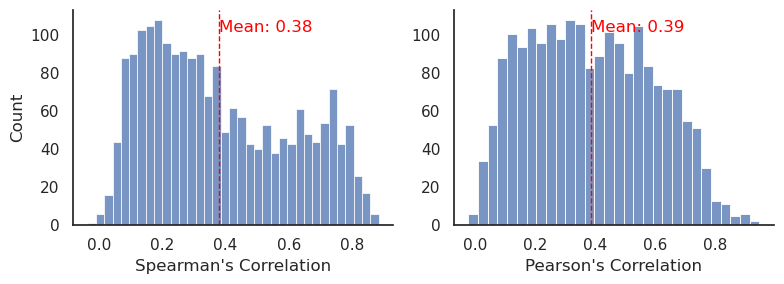

In [25]:
plot_average_correlation(corr_data, filename=None)